### 「賃料」データの外れ値がRMSEの悪化に寄与している事実に対して、施策を練る

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']


rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']

X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]]], axis=1)
y_train = rent
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]]], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S']

Duplicate key in file PosixPath('/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family : IPAexGothic')


「賃料」がわかりやすくなるように予測に用いる特徴量と合体させる

In [2]:
DATA = pd.concat([y_train, X_train],axis=1)

In [3]:
pd.set_option('display.max_rows', 150)
prime_place = DATA[DATA['賃料']>500000]
prime_place.to_csv('../data/handmade_data/over_500000yen.csv')
prime_place

,賃料,築年数,面積,契約期間,定期借家,所在階,全体の階数,最寄り駅,所要時間,平均地価,所在地,部屋数,L,D,S
274,650000,25.0,79.91,4.000000,2,30.0,38.0,172,2.0,1.840000e+06,208,3,1,1,0
666,505000,49.0,111.65,2.000000,1,53.0,53.0,23,1.0,1.408000e+06,2,3,1,1,0
671,900000,175.0,231.52,2.000000,1,3.0,1.0,267,6.0,3.751429e+06,369,5,1,1,0
1295,550000,544.0,214.78,2.000000,1,3.0,NaN,275,5.0,7.712500e+05,435,5,1,1,0
1501,1200000,222.0,163.62,5.000000,2,3.0,3.0,235,9.0,2.213333e+06,268,3,1,1,0
1712,515000,195.0,85.86,2.000000,1,13.0,34.0,13,8.0,5.746250e+06,569,2,1,1,0
1771,1450000,109.0,232.01,4.000000,2,2.0,NaN,372,5.0,7.138889e+05,493,4,1,1,1
1940,780000,23.0,112.30,2.000000,1,9.0,16.0,19,5.0,3.945000e+06,592,3,1,1,0
2047,820000,202.0,164.88,2.000000,1,2.0,7.0,152,5.0,3.793750e+06,174,3,1,1,0
2075,880000,250.0,256.68,5.000000,2,3.0,NaN,52,3.0,1.073667e+06,165,5,1,1,0


明らかな異常値を見つけたので修正を行う。レコードID:5775は、ワンルーム約20m^2で家賃月120万であり、これはあり得ない。12万の間違いとして修正を行う。

In [4]:
DATA = pd.concat([y_train, X_train],axis=1)
DATA.loc[[5775],'賃料'] = DATA.loc[[5775],'賃料']/10
DATA.loc[5775]

賃料        120350.00
築年数          149.00
面積            20.53
契約期間           2.00
定期借家           1.00
所在階           10.00
全体の階数         15.00
最寄り駅          90.00
所要時間           2.00
平均地価     6726000.00
所在地           93.00
部屋数            1.00
L              0.00
D              0.00
S              0.00
Name: 5775, dtype: float64

「賃料」は「面積」と強い相関がある。「L」「全体の階数」「D」「所在階」・・・というように相関は続く。

In [5]:
DATA.corr()['賃料']

賃料       1.000000
築年数     -0.251352
面積       0.752858
契約期間     0.191123
定期借家     0.013631
所在階      0.429444
全体の階数    0.495466
最寄り駅     0.059917
所要時間    -0.135984
平均地価     0.267642
所在地     -0.000540
部屋数      0.375435
L        0.565994
D        0.474419
S        0.196456
Name: 賃料, dtype: float64

「面積」が80m^2以下で賃料が500000以下の物件について調べた結果、やはりあまりない。

In [6]:
DATA[(DATA['賃料']>500000) & (DATA['面積']<80)]

,賃料,築年数,面積,契約期間,定期借家,所在階,全体の階数,最寄り駅,所要時間,平均地価,所在地,部屋数,L,D,S
274,650000,25.0,79.91,4.0,2,30.0,38.0,172,2.0,1.840000e+06,208,3,1,1,0
2624,520000,6.0,75.95,2.0,1,34.0,37.0,157,5.0,2.930000e+06,180,2,1,1,0
6387,680000,20.0,72.21,5.0,2,7.0,26.0,348,3.0,3.442222e+06,13,1,1,1,0
7874,510000,6.0,74.85,2.0,1,10.0,37.0,157,5.0,2.930000e+06,180,3,1,1,1
9543,590000,21.0,73.36,2.0,1,4.0,5.0,46,7.0,8.162222e+06,641,1,1,1,0
28522,630000,25.0,75.55,2.0,1,36.0,38.0,172,2.0,1.840000e+06,208,2,1,1,0
28524,535000,37.0,76.18,2.0,1,23.0,23.0,172,5.0,1.840000e+06,208,1,1,1,0


「面積」が80^2以上の物件はかなりの数ある。

In [7]:
DATA[DATA['面積']>=80]

,賃料,築年数,面積,契約期間,定期借家,所在階,全体の階数,最寄り駅,所要時間,平均地価,所在地,部屋数,L,D,S
22,346000,364.0,81.20,NaN,3,10.0,42.0,23,6.0,1.232750e+06,23,2,1,1,0
30,285000,158.0,92.17,5.0,2,4.0,11.0,31,7.0,7.090000e+05,30,2,1,1,0
33,238000,52.0,80.30,2.0,2,3.0,7.0,34,10.0,7.990000e+05,33,3,1,1,0
53,238000,365.0,93.15,2.0,1,2.0,3.0,51,12.0,6.600000e+05,51,3,1,1,0
153,255000,180.0,90.24,2.0,1,2.0,7.0,121,11.0,6.180000e+05,60,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31358,220000,128.0,130.83,2.0,1,2.0,NaN,149,9.0,3.510000e+05,168,4,1,1,0
31376,248000,191.0,105.27,3.0,2,2.0,1.0,131,5.0,7.496667e+05,140,2,1,1,0
31406,280000,67.0,86.14,NaN,3,7.0,9.0,228,12.0,5.116667e+05,580,4,1,1,0
31435,243000,50.0,93.25,4.0,2,2.0,NaN,258,8.0,4.855000e+05,510,3,1,1,0


「面積」が80^2以上かつリビング付きの物件の割合はほぼ１。つまり広い物件はリビングを必ず持っている。

In [8]:
len(DATA[(DATA['面積']>=80) & (DATA['L']==1)])/len(DATA[DATA['面積']>=80])

0.978391356542617

逆に80^2かつリビングなしの物件はどんなものかというと、単純に部屋の数が多い印象

In [9]:
DATA[(DATA['面積']>=80) & (DATA['L']==0)]

,賃料,築年数,面積,契約期間,定期借家,所在階,全体の階数,最寄り駅,所要時間,平均地価,所在地,部屋数,L,D,S
3189,170000,346.0,86.09,2.0,1,10.0,11.0,56,9.0,589500.000000,473,3,0,1,0
6733,148000,355.0,105.58,5.0,2,2.0,3.0,352,10.0,406500.000000,200,3,0,1,1
9019,417600,197.0,100.41,2.0,1,29.0,41.0,370,6.0,NaN,534,5,0,0,0
10432,100000,744.0,86.74,2.0,1,2.0,NaN,217,16.0,529333.333333,339,3,0,0,0
11828,230000,531.0,108.89,2.0,1,3.0,11.0,72,1.0,398000.000000,72,4,0,1,0
11994,150000,835.0,87.60,2.0,1,1.0,2.0,141,10.0,576666.666667,341,4,0,0,0
12498,130000,454.0,98.33,2.0,1,2.0,NaN,36,5.0,320500.000000,529,5,0,1,0
15259,238000,337.0,109.09,2.0,1,3.0,NaN,117,6.0,580000.000000,752,4,0,1,0
16241,150000,356.0,112.61,10.0,2,2.0,NaN,97,NaN,263000.000000,263,5,0,1,1
16667,205000,353.0,98.91,2.0,1,4.0,5.0,56,10.0,534600.000000,82,1,0,0,0


ひとまず、「面積」が80m^2以上の物件について目星をつけてみる

In [10]:
X_train['広い物件'] = 0
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10

for i in range(len(X_train)):
    if X_train.loc[i]['面積'] >= 80.0:
        #X_train.loc[i]['広い物件'] = 1#この代入方法だとエラーも出ずに代入に失敗する
        X_train.loc[i,'広い物件'] = 1

In [11]:
X_train[X_train['広い物件']==1]

,築年数,面積,契約期間,定期借家,所在階,全体の階数,最寄り駅,所要時間,平均地価,所在地,部屋数,L,D,S,広い物件
22,364.0,81.20,NaN,3,10.0,42.0,23,6.0,1.232750e+06,23,2,1,1,0,1
30,158.0,92.17,5.0,2,4.0,11.0,31,7.0,7.090000e+05,30,2,1,1,0,1
33,52.0,80.30,2.0,2,3.0,7.0,34,10.0,7.990000e+05,33,3,1,1,0,1
53,365.0,93.15,2.0,1,2.0,3.0,51,12.0,6.600000e+05,51,3,1,1,0,1
153,180.0,90.24,2.0,1,2.0,7.0,121,11.0,6.180000e+05,60,3,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31358,128.0,130.83,2.0,1,2.0,NaN,149,9.0,3.510000e+05,168,4,1,1,0,1
31376,191.0,105.27,3.0,2,2.0,1.0,131,5.0,7.496667e+05,140,2,1,1,0,1
31406,67.0,86.14,NaN,3,7.0,9.0,228,12.0,5.116667e+05,580,4,1,1,0,1
31435,50.0,93.25,4.0,2,2.0,NaN,258,8.0,4.855000e+05,510,3,1,1,0,1


次に、「面積」が70m^2以上に限って、「賃料」の相関を調べてみると、依然として「面積」と「賃料」の相関は強い。

In [12]:
DATA['広い物件'] = 0

for i in range(len(DATA)):
    if DATA.loc[i]['面積'] >= 70.0:
        #X_train.loc[i]['広い物件'] = 1#この代入方法だとエラーも出ずに代入に失敗する
        DATA.loc[i,'広い物件'] = 1

In [21]:
DATA[(DATA['面積']>60.0) & (DATA['面積']<=75.0)]

,賃料,築年数,面積,契約期間,定期借家,所在階,全体の階数,最寄り駅,所要時間,平均地価,所在地,部屋数,L,D,S,広い物件
3,150000,352.0,60.48,2.0,2,3.0,4.0,4,9.0,698875.0,4,2,1,1,0,0
8,184327,536.0,65.59,2.0,1,4.0,9.0,9,3.0,780000.0,9,2,0,1,0,0
18,310000,72.0,70.82,2.0,1,5.0,11.0,19,5.0,1037000.0,19,3,1,1,0,1
36,146000,260.0,70.04,2.0,1,2.0,3.0,7,10.0,348500.0,36,3,1,1,0,1
44,118000,318.0,61.00,NaN,3,4.0,4.0,43,9.0,322400.0,42,3,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31395,280000,187.0,61.19,2.0,1,3.0,15.0,235,3.0,3793750.0,174,1,1,1,0,0
31429,308000,139.0,71.29,2.0,1,21.0,58.0,2,5.0,1580000.0,169,1,1,1,0,1
31445,108000,312.0,65.61,2.0,1,3.0,5.0,88,18.0,296000.0,110,3,1,1,0,0
31460,192000,193.0,63.27,2.0,1,29.0,30.0,279,1.0,991000.0,393,1,0,0,0,0


In [13]:
DATA_over70m2 = DATA[DATA['面積']>70.0]
DATA_over70m2

,賃料,築年数,面積,契約期間,定期借家,所在階,全体の階数,最寄り駅,所要時間,平均地価,所在地,部屋数,L,D,S,広い物件
18,310000,72.0,70.82,2.0,1,5.0,11.0,19,5.0,1.037000e+06,19,3,1,1,0,1
22,346000,364.0,81.20,NaN,3,10.0,42.0,23,6.0,1.232750e+06,23,2,1,1,0,1
30,285000,158.0,92.17,5.0,2,4.0,11.0,31,7.0,7.090000e+05,30,2,1,1,0,1
33,238000,52.0,80.30,2.0,2,3.0,7.0,34,10.0,7.990000e+05,33,3,1,1,0,1
36,146000,260.0,70.04,2.0,1,2.0,3.0,7,10.0,3.485000e+05,36,3,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31376,248000,191.0,105.27,3.0,2,2.0,1.0,131,5.0,7.496667e+05,140,2,1,1,0,1
31406,280000,67.0,86.14,NaN,3,7.0,9.0,228,12.0,5.116667e+05,580,4,1,1,0,1
31429,308000,139.0,71.29,2.0,1,21.0,58.0,2,5.0,1.580000e+06,169,1,1,1,0,1
31435,243000,50.0,93.25,4.0,2,2.0,NaN,258,8.0,4.855000e+05,510,3,1,1,0,1


In [14]:
DATA_over70m2.corr()['賃料']

賃料       1.000000
築年数     -0.204320
面積       0.545984
契約期間     0.116142
定期借家     0.040640
所在階      0.265245
全体の階数    0.195074
最寄り駅     0.141049
所要時間    -0.294123
平均地価     0.466068
所在地      0.025937
部屋数     -0.097555
L        0.113633
D        0.041397
S        0.084708
広い物件          NaN
Name: 賃料, dtype: float64

「面積」が100m^2以上で、「賃料」が500000以上のもの

In [15]:
print(len(DATA[(DATA['賃料']>500000) & (DATA['面積']>100.0)]))
DATA[(DATA['賃料']>500000) & (DATA['面積']>100.0)]

88


,賃料,築年数,面積,契約期間,定期借家,所在階,全体の階数,最寄り駅,所要時間,平均地価,所在地,部屋数,L,D,S,広い物件
666,505000,49.0,111.65,2.000000,1,53.0,53.0,23,1.0,1.408000e+06,2,3,1,1,0,1
671,900000,175.0,231.52,2.000000,1,3.0,1.0,267,6.0,3.751429e+06,369,5,1,1,0,1
1295,550000,544.0,214.78,2.000000,1,3.0,NaN,275,5.0,7.712500e+05,435,5,1,1,0,1
1501,1200000,222.0,163.62,5.000000,2,3.0,3.0,235,9.0,2.213333e+06,268,3,1,1,0,1
1771,1450000,109.0,232.01,4.000000,2,2.0,NaN,372,5.0,7.138889e+05,493,4,1,1,1,1
1940,780000,23.0,112.30,2.000000,1,9.0,16.0,19,5.0,3.945000e+06,592,3,1,1,0,1
2047,820000,202.0,164.88,2.000000,1,2.0,7.0,152,5.0,3.793750e+06,174,3,1,1,0,1
2075,880000,250.0,256.68,5.000000,2,3.0,NaN,52,3.0,1.073667e+06,165,5,1,1,0,1
2266,700000,413.0,152.07,2.000000,2,5.0,7.0,13,9.0,5.746250e+06,569,2,1,1,1,1
2909,700000,20.0,103.04,3.000000,2,3.0,9.0,235,8.0,1.790000e+06,451,2,1,1,0,1


### 「面積」が100m^2以上という特徴量を作成し、モデルを動かしてみる。

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']


rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']

X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]]], axis=1)
y_train = rent
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]]], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S']

In [162]:
X_train['100m^2以上'] = 0
X_test['100m^2以上'] = 0
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10

for i in range(len(X_train)):
    if X_train.loc[i]['面積'] >= 100.0:
        #X_train.loc[i]['広い物件'] = 1#この代入方法だとエラーも出ずに代入に失敗する
        X_train.loc[i,'100m^2以上'] = 1

for i in range(len(X_test)):
    if X_test.loc[i]['面積'] >= 100.0:
        X_test.loc[i, '100m^2以上'] = 1

over100m2 = X_train['100m^2以上']
over100m2.to_csv('../data/handmade_data/over100m2.csv',index=False)
test_over100m2 = X_test['100m^2以上']
test_over100m2.to_csv('../data/test_data/test_over100m2.csv', index=False)

In [163]:
X_test[X_test['面積']>90.0]

,築年数,面積,契約期間,定期借家,所在階,全体の階数,最寄り駅,所要時間,平均地価,所在地,部屋数,L,D,S,100m^2以上
17,415.0,112.96,4.0,3,7.0,14.0,89,5.0,1.436667e+06,78,3,1,1,0,1
38,139.0,91.38,NaN,1,23.0,58.0,2,5.0,1.580000e+06,169,2,1,1,0,0
109,65.0,105.26,2.0,2,2.0,NaN,154,17.0,5.396667e+05,185,3,1,1,0,1
132,376.0,102.70,2.0,2,4.0,4.0,77,10.0,5.270000e+05,79,3,1,1,0,1
199,197.0,93.22,2.0,2,37.0,41.0,124,4.0,NaN,534,2,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30828,476.0,120.00,2.0,2,2.0,NaN,292,7.0,4.091429e+05,76,6,1,1,0,1
30923,184.0,104.96,2.0,3,10.0,11.0,290,6.0,1.645500e+06,26,1,1,1,0,1
31119,301.0,93.97,2.0,2,29.0,33.0,120,9.0,NaN,506,2,1,1,0,0
31158,197.0,118.38,2.0,2,5.0,6.0,8,12.0,7.816667e+05,254,3,1,1,1,1


GBDTを動かしてみる

In [164]:
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S', '100m^2以上']

n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  2.903886846508796e-05,
        'max_bin': 288,
        'num_leaves': 116
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2162
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48636.7	valid_1's rmse: 50260.4
[20]	training's rmse: 34353.3	valid_1's rmse: 38117.8
[30]	training's rmse: 25685	valid_1's rmse: 31116.3
[40]	training's rmse: 20777.4	valid_1's rmse: 27333.6
[50]	training's rmse: 17492.5	valid_1's rmse: 24937
[60]	training's rmse: 15587.3	valid_1's rmse: 23592.1
[70]	training's rmse: 14245.5	valid_1's rmse: 22738.5
[80]	training's rmse: 13253.4	valid_1's rmse: 22109.3
[90]	training's rmse: 12465	valid_1's rmse: 21659.5
[100]	training's rmse: 11831.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48699.1	valid_1's rmse: 49226.4
[20]	training's rmse: 34648.6	valid_1's rmse: 35830.6
[30]	training's rmse: 26543.7	valid_1's rmse: 28412.4
[40]	training's rmse: 21850.7	valid_1's rmse: 24414.9
[50]	training's rmse: 18820.8	valid_1's rmse: 21796.6
[60]	training's rmse: 17046.1	valid_1's rmse: 20286
[70]	training's rmse: 15755.4	valid_1's rmse: 19394.9
[80]	training's rmse: 14768.4	valid_1's rmse: 18770.8
[90]	training's rmse: 14000.9	valid_1's rmse: 18436.6
[100]	training's rmse: 13320.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48874	valid_1's rmse: 48342.7
[20]	training's rmse: 34957.2	valid_1's rmse: 33955.1
[30]	training's rmse: 26775.7	valid_1's rmse: 26387.4
[40]	training's rmse: 22093.8	valid_1's rmse: 22495.4
[50]	training's rmse: 19043.8	valid_1's rmse: 20075.5
[60]	training's rmse: 17113.5	valid_1's rmse: 19000.5
[70]	training's rmse: 15862.9	valid_1's rmse: 18404.5
[80]	training's rmse: 14891.5	valid_1's rmse: 18085.2
[90]	training's rmse: 14138.3	valid_1's rmse: 17888
[100]	training's rmse: 13492.7	valid_1's rmse: 17769.6
[110]	training's rmse: 12956.6	valid_1's rmse: 17673.3
[120]	training's rmse: 12491.4	valid_1's rmse: 17603.7
[130]	training's rmse: 12093	valid_1's rmse: 17476.8
[140]	training's rmse: 11680.3	valid_1's rmse: 17435.6
[150]	training's rmse: 11293	valid_1's rmse: 17350.5
[160]	training's rmse: 10983	valid_1's rmse: 17294.1
[170]	training's rmse: 10664.9	valid_1's rmse: 17250.7
[180]	training's rmse: 10366.3	valid_1's rmse: 17212.7
[190]	training's rmse: 10124.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2159
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49083.7	valid_1's rmse: 48054.1
[20]	training's rmse: 34691.6	valid_1's rmse: 35403.1
[30]	training's rmse: 26285.3	valid_1's rmse: 28519.4
[40]	training's rmse: 21569.9	valid_1's rmse: 24885.9
[50]	training's rmse: 18365.4	valid_1's rmse: 23033.9
[60]	training's rmse: 16484.4	valid_1's rmse: 22155.9
[70]	training's rmse: 15292.5	valid_1's rmse: 21654.4
[80]	training's rmse: 14403.6	valid_1's rmse: 21177.9
[90]	training's rmse: 13705	valid_1's rmse: 20731.3
[100]	training's rmse: 13134.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48495.2	valid_1's rmse: 51085.3
[20]	training's rmse: 34811.1	valid_1's rmse: 37028.9
[30]	training's rmse: 26671.8	valid_1's rmse: 28598.4
[40]	training's rmse: 22117.3	valid_1's rmse: 24039.4
[50]	training's rmse: 19064.5	valid_1's rmse: 21442.4
[60]	training's rmse: 17221	valid_1's rmse: 20018.4
[70]	training's rmse: 16008	valid_1's rmse: 19188.4
[80]	training's rmse: 15044.6	valid_1's rmse: 18682.4
[90]	training's rmse: 14311.3	valid_1's rmse: 18345.9
[100]	training's rmse: 13730	valid_1's rmse

,importance
面積,4.452362e+14
L,4.120082e+14
平均地価,2.082377e+14
最寄り駅,9.001409e+13
築年数,7.439839e+13
所在地,3.986304e+13
全体の階数,3.422603e+13
契約期間,1.907748e+13
所在階,9.622100e+12
所要時間,6.611033e+12


チューニングを行ってみる

In [176]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'S']], over100m2], axis=1)
y_train = rent
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]], test_over100m2], axis=1)
category_lists = ['定期借家', '最寄り駅', '所在地', 'L', 'D', 'S', '100m^2以上']

cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=1000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [177]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-15 15:40:39,492] A new study created in memory with name: no-name-14782278-f859-4b14-bb59-dec4467d326f
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2824
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48789.7	valid_1's rmse: 50204
[20]	training's rmse: 34455.9	valid_1's rmse: 37892.9
[30]	training's rmse: 26131.4	valid_1's rmse: 31185.5
[40]	training's rmse: 20982.9	valid_1's rmse: 27388.9
[50]	training's rmse: 17746.4	valid_1's rmse: 25051.1
[60]	training's rmse: 15751.7	valid_1's rmse: 23676.1
[70]	training's rmse: 14387.1	valid_1's rmse: 22897.4
[80]	training's rmse: 13389.1	valid_1's rmse: 22309.3
[90]	training's rmse: 12619.2	valid_1's rmse: 21881
[100]	training's rmse: 11986.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2823
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48983	valid_1's rmse: 49549.4
[20]	training's rmse: 34955.9	valid_1's rmse: 35957
[30]	training's rmse: 27005.4	valid_1's rmse: 28594.6
[40]	training's rmse: 22272.1	valid_1's rmse: 24370.7
[50]	training's rmse: 19309.3	valid_1's rmse: 21690.2
[60]	training's rmse: 17629.4	valid_1's rmse: 20353.1
[70]	training's rmse: 16455.4	valid_1's rmse: 19459.9
[80]	training's rmse: 15557.4	valid_1's rmse: 18969.6
[90]	training's rmse: 14811.5	valid_1's rmse: 18667.4
[100]	training's rmse: 14246.6	valid_1's rm

[W 2022-09-15 15:40:47,162] Trial 0 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_2340/98581951.py", line 34, in objective
    model = lgb.train(
  File "/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py", line 292, in train
    booster.update(fobj=fobj)
  File "/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py", line 3021, in update
    _safe_call(_LIB.LGBM_BoosterUpdateOneIter(
KeyboardInterrupt


[120]	training's rmse: 13395.4	valid_1's rmse: 18280.8
[130]	training's rmse: 13028.6	valid_1's rmse: 18209.9


KeyboardInterrupt: 

In [ ]:
study.best_params

{'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}

チューニング結果を用いてモデルを動かしてみる

In [167]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'S']], over100m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]], test_over100m2], axis=1)
category_lists = ['定期借家', '最寄り駅', '所在地', 'L', 'D', 'S', '100m^2以上']

n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  2.903886846508796e-05,
        'max_bin': 288,
        'num_leaves': 116
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2162
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48636.7	valid_1's rmse: 50260.4
[20]	training's rmse: 34353.3	valid_1's rmse: 38117.8
[30]	training's rmse: 25685	valid_1's rmse: 31116.3
[40]	training's rmse: 20777.4	valid_1's rmse: 27333.6
[50]	training's rmse: 17492.5	valid_1's rmse: 24937
[60]	training's rmse: 15587.3	valid_1's rmse: 23592.1
[70]	training's rmse: 14245.5	valid_1's rmse: 22738.5
[80]	training's rmse: 13253.4	valid_1's rmse: 22109.3
[90]	training's rmse: 12465	valid_1's rmse: 21659.5
[100]	training's rmse: 11831.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 15
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48699.1	valid_1's rmse: 49226.4
[20]	training's rmse: 34648.6	valid_1's rmse: 35830.6
[30]	training's rmse: 26543.7	valid_1's rmse: 28412.4
[40]	training's rmse: 21850.7	valid_1's rmse: 24414.9
[50]	training's rmse: 18820.8	valid_1's rmse: 21796.6
[60]	training's rmse: 17046.1	valid_1's rmse: 20286
[70]	training's rmse: 15755.4	valid_1's rmse: 19394.9
[80]	training's rmse: 14768.4	valid_1's rmse: 18770.8
[90]	training's rmse: 14000.9	valid_1's rmse: 18436.6
[100]	training's rmse: 13320.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48874	valid_1's rmse: 48342.7
[20]	training's rmse: 34957.2	valid_1's rmse: 33955.1
[30]	training's rmse: 26775.7	valid_1's rmse: 26387.4
[40]	training's rmse: 22093.8	valid_1's rmse: 22495.4
[50]	training's rmse: 19043.8	valid_1's rmse: 20075.5
[60]	training's rmse: 17113.5	valid_1's rmse: 19000.5
[70]	training's rmse: 15862.9	valid_1's rmse: 18404.5
[80]	training's rmse: 14891.5	valid_1's rmse: 18085.2
[90]	training's rmse: 14138.3	valid_1's rmse: 17888
[100]	training's rmse: 13492.7	valid_1's rmse: 17769.6
[110]	training's rmse: 12956.6	valid_1's rmse: 17673.3
[120]	training's rmse: 12491.4	valid_1's rmse: 17603.7
[130]	training's rmse: 12093	valid_1's rmse: 17476.8
[140]	training's rmse: 11680.3	valid_1's rmse: 17435.6
[150]	training's rmse: 11293	valid_1's rmse: 17350.5
[160]	training's rmse: 10983	valid_1's rmse: 17294.1
[170]	training's rmse: 10664.9	valid_1's rmse: 17250.7
[180]	training's rmse: 10366.3	valid_1's rmse: 17212.7
[190]	training's rmse: 10124.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[20]	training's rmse: 34691.6	valid_1's rmse: 35403.1
[30]	training's rmse: 26285.3	valid_1's rmse: 28519.4
[40]	training's rmse: 21569.9	valid_1's rmse: 24885.9
[50]	training's rmse: 18365.4	valid_1's rmse: 23033.9
[60]	training's rmse: 16484.4	valid_1's rmse: 22155.9
[70]	training's rmse: 15292.5	valid_1's rmse: 21654.4
[80]	training's rmse: 14403.6	valid_1's rmse: 21177.9
[90]	training's rmse: 13705	valid_1's rmse: 20731.3
[100]	training's rmse: 13134.7	valid_1's rmse: 20402.8
[110]	training's rmse: 12645.3	valid_1's rmse: 20060.5
[120]	training's rmse: 12209.6	valid_1's rmse: 19852.9
[130]	training's rmse: 11815.4	valid_1's rmse: 19681.8
[140]	training's rmse: 11466.9	valid_1's rmse: 19615.7
[150]	training's rmse: 11140.7	valid_1's rmse: 19530.3
[160]	training's rmse: 10836.2	valid_1's rmse: 19451.6
[170]	training's rmse: 10560	valid_1's rmse: 19424.5
[180]	training's rmse: 10288.6	valid_1's rmse: 19337
[190]	training's rmse: 10041.8	valid_1's rmse: 19315.8
[200]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_e

[10]	training's rmse: 48495.2	valid_1's rmse: 51085.3
[20]	training's rmse: 34811.1	valid_1's rmse: 37028.9
[30]	training's rmse: 26671.8	valid_1's rmse: 28598.4
[40]	training's rmse: 22117.3	valid_1's rmse: 24039.4
[50]	training's rmse: 19064.5	valid_1's rmse: 21442.4
[60]	training's rmse: 17221	valid_1's rmse: 20018.4
[70]	training's rmse: 16008	valid_1's rmse: 19188.4
[80]	training's rmse: 15044.6	valid_1's rmse: 18682.4
[90]	training's rmse: 14311.3	valid_1's rmse: 18345.9
[100]	training's rmse: 13730	valid_1's rmse: 17986.7
[110]	training's rmse: 13216.8	valid_1's rmse: 17744.9
[120]	training's rmse: 12786.2	valid_1's rmse: 17580.5
[130]	training's rmse: 12397.7	valid_1's rmse: 17364.3
[140]	training's rmse: 12035.9	valid_1's rmse: 17262.9
[150]	training's rmse: 11727.6	valid_1's rmse: 17138.9
[160]	training's rmse: 11460.5	valid_1's rmse: 17007.6
[170]	training's rmse: 11201.3	valid_1's rmse: 16906
[180]	training's rmse: 10970.9	valid_1's rmse: 16794.8
[190]	training's rmse: 1076

,importance
面積,4.452362e+14
L,4.120082e+14
平均地価,2.082377e+14
最寄り駅,9.001409e+13
築年数,7.439839e+13
所在地,3.986304e+13
全体の階数,3.422603e+13
契約期間,1.907748e+13
所在階,9.622100e+12
所要時間,6.611033e+12


「面積」が75m^2以上100未満にもフラグを立ててみる

In [168]:
X_train['75m^2以上100m^2未満'] = 0
X_test['75m^2以上100m^2未満'] = 0
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10

for i in range(len(X_train)):
    if X_train.loc[i]['面積'] >= 70.0 and X_train.loc[i]['面積'] < 100.0:
        #X_train.loc[i]['広い物件'] = 1#この代入方法だとエラーも出ずに代入に失敗する
        X_train.loc[i,'75m^2以上100m^2未満'] = 1

for i in range(len(X_test)):
    if X_test.loc[i]['面積'] >= 70.0 and X_test.loc[i]['面積'] < 100.0:
        X_test.loc[i, '75m^2以上100m^2未満'] = 1

bt75and100m2 = X_train['75m^2以上100m^2未満']
bt75and100m2.to_csv('../data/handmade_data/bt75and100m2.csv', index=False)
test_bt75and100m2 = X_test['75m^2以上100m^2未満']
test_bt75and100m2.to_csv('../data/test_data/test_bt75and100m2.csv', index=False)

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48636.7	valid_1's rmse: 50260.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34353.4	valid_1's rmse: 38117.6
[30]	training's rmse: 25744.1	valid_1's rmse: 31208.7
[40]	training's rmse: 20773.7	valid_1's rmse: 27422.9
[50]	training's rmse: 17493.4	valid_1's rmse: 25044.9
[60]	training's rmse: 15596.9	valid_1's rmse: 23695.6
[70]	training's rmse: 14239.9	valid_1's rmse: 22827.4
[80]	training's rmse: 13277	valid_1's rmse: 22177.2
[90]	training's rmse: 12485	valid_1's rmse: 21656.7
[100]	training's rmse: 11844	valid_1's rmse: 21260.3
[110]	training's rmse: 11344	valid_1's rmse: 20949.3
[120]	training's rmse: 10905	valid_1's rmse: 20718.4
[130]	training's rmse: 10518.1	valid_1's rmse: 20461.9
[140]	training's rmse: 10192.5	valid_1's rmse: 20233.4
[150]	training's rmse: 9847.58	valid_1's rmse: 20019.3
[160]	training's rmse: 9571.12	valid_1's rmse: 19824.3
[170]	training's rmse: 9317.58	valid_1's rmse: 19667.8
[180]	training's rmse: 9080.4	valid_1's rmse: 19483.7
[190]	training's rmse: 8864.48	valid_1's rmse: 19332.2
[200]	training's rmse: 8661.4

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48699.1	valid_1's rmse: 49226.4
[20]	training's rmse: 34670.6	valid_1's rmse: 35828.7
[30]	training's rmse: 26496.5	valid_1's rmse: 28314.2
[40]	training's rmse: 21900.3	valid_1's rmse: 24424.1
[50]	training's rmse: 18818.4	valid_1's rmse: 21831.3
[60]	training's rmse: 17005.9	valid_1's rmse: 20212.8
[70]	training's rmse: 15739	valid_1's rmse: 19270.3
[80]	training's rmse: 14719.2	valid_1's rmse: 18678.7
[90]	training's rmse: 13936.7	valid_1's rmse: 18294.9
[100]	training's rmse: 13300.1	valid_1's rmse: 18061
[110]	training's rmse: 12714.9	valid_1's rmse: 17841.5
[120]	training's rmse: 12214.7	valid_1's rmse: 17679.2
[130]	training's rmse: 11782.3	valid_1's rmse: 17504.3
[140]	training's rmse: 11345.6	valid_1's rmse: 17387.4
[150]	training's rmse: 10985	valid_1's rmse: 17325.6
[160]	training's rmse: 10660.1	valid_1's rmse: 17244.8
[170]	training's rmse: 10352.1	valid_1's rmse: 17187.1
[180]	training's rmse: 10072.2	valid_1's rmse: 17156.9
[190]	training's rmse: 98

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34982.7	valid_1's rmse: 33967.2
[30]	training's rmse: 26743.5	valid_1's rmse: 26448.5
[40]	training's rmse: 22068.5	valid_1's rmse: 22475.6
[50]	training's rmse: 19027.4	valid_1's rmse: 20135.2
[60]	training's rmse: 17163.6	valid_1's rmse: 19096.7
[70]	training's rmse: 15910.9	valid_1's rmse: 18575.1
[80]	training's rmse: 14921	valid_1's rmse: 18221.6
[90]	training's rmse: 14111.9	valid_1's rmse: 18031.5
[100]	training's rmse: 13477.4	valid_1's rmse: 17862.9
[110]	training's rmse: 12943.4	valid_1's rmse: 17800.8
[120]	training's rmse: 12467.8	valid_1's rmse: 17689.4
[130]	training's rmse: 12039.4	valid_1's rmse: 17569.1
[140]	training's rmse: 11689	valid_1's rmse: 17519.1
[150]	training's rmse: 11310.5	valid_1's rmse: 17455.7
[160]	training's rmse: 10983.5	valid_1's rmse: 17401.8
[170]	training's rmse: 10660.9	valid_1's rmse: 17312.9
[180]	training's rmse: 10364.3	valid_1's rmse: 17262.7
[190]	training's rmse: 10114.6	valid_1's rmse: 17252
[200]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 26285.3	valid_1's rmse: 28519.5
[40]	training's rmse: 21471.4	valid_1's rmse: 24834.4
[50]	training's rmse: 18318.4	valid_1's rmse: 22929
[60]	training's rmse: 16435.3	valid_1's rmse: 22093.2
[70]	training's rmse: 15239	valid_1's rmse: 21596.5
[80]	training's rmse: 14335.8	valid_1's rmse: 21112.5
[90]	training's rmse: 13637.1	valid_1's rmse: 20628.3
[100]	training's rmse: 13077.2	valid_1's rmse: 20298.3
[110]	training's rmse: 12597	valid_1's rmse: 19962.8
[120]	training's rmse: 12147.1	valid_1's rmse: 19741.7
[130]	training's rmse: 11764.3	valid_1's rmse: 19593.4
[140]	training's rmse: 11421	valid_1's rmse: 19506.9
[150]	training's rmse: 11087.6	valid_1's rmse: 19487.8
[160]	training's rmse: 10783.9	valid_1's rmse: 19366.7
[170]	training's rmse: 10502.8	valid_1's rmse: 19310.8
[180]	training's rmse: 10247.3	valid_1's rmse: 19216.6
[190]	training's rmse: 10011.4	valid_1's rmse: 19212.1
[200]	training's rmse: 9794.88	valid_1's rmse: 19164.8
[210]	training's rmse: 95

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48495.2	valid_1's rmse: 51085.2
[20]	training's rmse: 34817	valid_1's rmse: 37004.4
[30]	training's rmse: 26635.1	valid_1's rmse: 28565.5
[40]	training's rmse: 22110.3	valid_1's rmse: 23929.1
[50]	training's rmse: 19060.9	valid_1's rmse: 21317.9
[60]	training's rmse: 17240	valid_1's rmse: 19918.6
[70]	training's rmse: 16023.4	valid_1's rmse: 19111.8
[80]	training's rmse: 15068.5	valid_1's rmse: 18550.7
[90]	training's rmse: 14330.4	valid_1's rmse: 18188.6
[100]	training's rmse: 13750.3	valid_1's rmse: 17873.7
[110]	training's rmse: 13258.3	valid_1's rmse: 17609.8
[120]	training's rmse: 12831.4	valid_1's rmse: 17366.6
[130]	training's rmse: 12430.6	valid_1's rmse: 17246.2
[140]	training's rmse: 12079	valid_1's rmse: 17085
[150]	training's rmse: 11767	valid_1's rmse: 16953.6
[160]	training's rmse: 11486.7	valid_1's rmse: 16853
[170]	training's rmse: 11232.4	valid_1's rmse: 16740.4
[180]	training's rmse: 10981.8	valid_1's rmse: 16642.4
[190]	training's rmse: 10750.5	

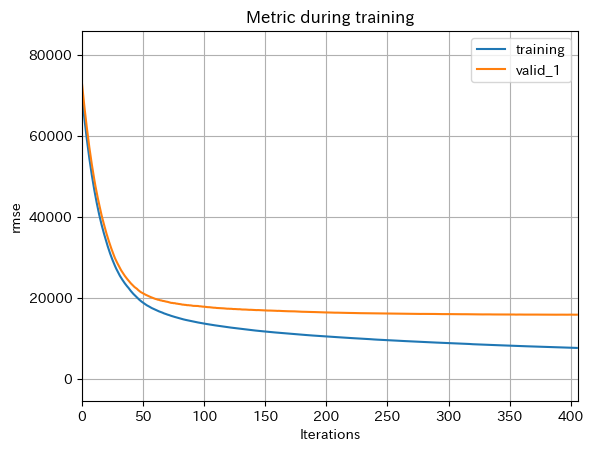

,importance
面積,4.475731e+14
L,4.120296e+14
平均地価,2.092252e+14
最寄り駅,9.157513e+13
築年数,7.601341e+13
所在地,3.831284e+13
全体の階数,3.392870e+13
契約期間,1.861676e+13
所在階,9.916454e+12
所要時間,7.036154e+12


In [160]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'S']], over100m2, bt75and100m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]], test_over100m2, test_bt75and100m2], axis=1)

category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S', '100m^2以上', '75m^2以上100m^2未満']

n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  2.903886846508796e-05,
        'max_bin': 288,
        'num_leaves': 116,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

チューニングをしてみる

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], over100m2, bt75and100m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]], test_over100m2, test_bt75and100m2], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S', '100m^2以上', '75m^2以上100m^2未満']

In [170]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=1000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [171]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-15 15:04:10,300] A new study created in memory with name: no-name-0d3f7cb1-e573-49bd-a588-e9e3f3691247
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be r

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48789.7	valid_1's rmse: 50204
[20]	training's rmse: 34455.9	valid_1's rmse: 37892.9
[30]	training's rmse: 26132	valid_1's rmse: 31188
[40]	training's rmse: 21079	valid_1's rmse: 27406.7
[50]	training's rmse: 17743.9	valid_1's rmse: 25045.7
[60]	training's rmse: 15757.5	valid_1's rmse: 23633.6
[70]	training's rmse: 14386.5	valid_1's rmse: 22775.6
[80]	training's rmse: 13372.5	valid_1's rmse: 22141.1
[90]	training's rmse: 12614.5	valid_1's rmse: 21659.8
[100]	training's rmse: 11993.8	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48983	valid_1's rmse: 49549.4
[20]	training's rmse: 34955.9	valid_1's rmse: 35957
[30]	training's rmse: 27005.4	valid_1's rmse: 28594.6
[40]	training's rmse: 22282.6	valid_1's rmse: 24388.8
[50]	training's rmse: 19308.9	valid_1's rmse: 21663.8
[60]	training's rmse: 17659.3	valid_1's rmse: 20372
[70]	training's rmse: 16465.8	valid_1's rmse: 19468.6
[80]	training's rmse: 15612.9	valid_1's rmse: 18933.9
[90]	training's rmse: 14896.8	valid_1's rmse: 18621.4
[100]	training's rmse: 14308.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35415.7	valid_1's rmse: 33841.9
[30]	training's rmse: 27164.2	valid_1's rmse: 25906
[40]	training's rmse: 22441.5	valid_1's rmse: 21621.3
[50]	training's rmse: 19382.9	valid_1's rmse: 19158.6
[60]	training's rmse: 17474.6	valid_1's rmse: 17973.3
[70]	training's rmse: 16319	valid_1's rmse: 17314.6
[80]	training's rmse: 15494.3	valid_1's rmse: 16848.7
[90]	training's rmse: 14810.6	valid_1's rmse: 16538.7
[100]	training's rmse: 14308	valid_1's rmse: 16348.6
[110]	training's rmse: 13825.5	valid_1's rmse: 16138.2
[120]	training's rmse: 13443	valid_1's rmse: 16013.7
[130]	training's rmse: 13080	valid_1's rmse: 15939.9
[140]	training's rmse: 12761.3	valid_1's rmse: 15870.7
[150]	training's rmse: 12479.7	valid_1's rmse: 15822.9
[160]	training's rmse: 12202.3	valid_1's rmse: 15759.8
[170]	training's rmse: 11949.3	valid_1's rmse: 15687.7
[180]	training's rmse: 11678.7	valid_1's rmse: 15650.4
[190]	training's rmse: 11464.1	valid_1's rmse: 15598.3
[200]	training's rmse: 11247

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49244.6	valid_1's rmse: 48168.1
[20]	training's rmse: 35084	valid_1's rmse: 35167.4
[30]	training's rmse: 26728.6	valid_1's rmse: 28129.5
[40]	training's rmse: 21822.9	valid_1's rmse: 24394.4
[50]	training's rmse: 18696.3	valid_1's rmse: 22438
[60]	training's rmse: 16943	valid_1's rmse: 21313.9
[70]	training's rmse: 15832.6	valid_1's rmse: 20650.7
[80]	training's rmse: 14998.5	valid_1's rmse: 20089.5
[90]	training's rmse: 14343.6	valid_1's rmse: 19699.5
[100]	training's rmse: 13817.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48664.2	valid_1's rmse: 50985.9
[20]	training's rmse: 34971.1	valid_1's rmse: 37042.2
[30]	training's rmse: 26940.8	valid_1's rmse: 28802
[40]	training's rmse: 22278.5	valid_1's rmse: 24047.9
[50]	training's rmse: 19123.3	valid_1's rmse: 21296.1
[60]	training's rmse: 17339.5	valid_1's rmse: 19879.6
[70]	training's rmse: 16096.4	valid_1's rmse: 19078
[80]	training's rmse: 15144.5	valid_1's rmse: 18536.3
[90]	training's rmse: 14441.1	valid_1's rmse: 18232.9
[100]	training's rmse: 13912.1	valid_1's rm

[I 2022-09-15 15:04:28,161] Trial 0 finished with value: 16401.202109206344 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16401.202109206344.


[350]	training's rmse: 9022.98	valid_1's rmse: 16415.1
Early stopping, best iteration is:
[342]	training's rmse: 9102.63	valid_1's rmse: 16401.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2507
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48703.2	valid_1's rmse: 50044.9
[20]	training's rmse: 34361.1	valid_1's rmse: 37800.4
[30]	training's rmse: 25876.3	valid_1's rmse: 30957.2
[40]	training's rmse: 20934.7	valid_1's rmse: 27188.8
[50]	training's rmse: 17678.3	valid_1's rmse: 24894.3
[60]	training's rmse: 15724.3	valid_1's rmse: 23498.8
[70]	training's rmse: 14340.7	valid_1's rmse: 22578.6
[80]	training's rmse: 13378.7	valid_1's rmse: 21962.1
[90]	training's rmse: 12643.1	valid_1's rmse: 21466.5
[100]	training's rmse: 12127.2	valid_1's rmse: 21100
[110]	training's rmse: 11653	valid_1's rmse: 20782.1
[120]	training's rmse: 11252.4	valid_1's rmse: 20482.1
[130]	training's rmse: 10886.1	valid_1's rmse: 20245.6
[140]	training's rmse: 10554.4	valid_1's rmse: 20048.6
[150]	training's rmse: 10274.6	valid_1's rmse: 19900.8
[160]	training's rmse: 10009.9	valid_1's rmse: 19733.9
[170]	training's rmse: 9761.54	valid_1's rmse: 19598
[180]	training's rmse: 9543.08	valid_1's rmse: 19487.6
[190]	training's rmse: 93

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2503
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48966	valid_1's rmse: 49789.5
[20]	training's rmse: 34881.7	valid_1's rmse: 36380.3
[30]	training's rmse: 26623.8	valid_1's rmse: 29109.1
[40]	training's rmse: 21822.6	valid_1's rmse: 24728.8
[50]	training's rmse: 18840.6	valid_1's rmse: 22049.9
[60]	training's rmse: 17004.7	valid_1's rmse: 20724.6
[70]	training's rmse: 15741.6	valid_1's rmse: 19855.3
[80]	training's rmse: 14771.5	valid_1's rmse: 19369.8
[90]	training's rmse: 14022.8	valid_1's rmse: 19038.4
[100]	training's rmse: 13416.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34938.5	valid_1's rmse: 34319
[30]	training's rmse: 26769.7	valid_1's rmse: 26502.5
[40]	training's rmse: 22004.9	valid_1's rmse: 22384.9
[50]	training's rmse: 18940.4	valid_1's rmse: 20088.3
[60]	training's rmse: 17138.4	valid_1's rmse: 18912.8
[70]	training's rmse: 15965.4	valid_1's rmse: 18274.3
[80]	training's rmse: 15058.1	valid_1's rmse: 17817.7
[90]	training's rmse: 14333.3	valid_1's rmse: 17555.9
[100]	training's rmse: 13769.8	valid_1's rmse: 17363.4
[110]	training's rmse: 13288.3	valid_1's rmse: 17258.3
[120]	training's rmse: 12871.1	valid_1's rmse: 17244.6
[130]	training's rmse: 12508.5	valid_1's rmse: 17207.1
[140]	training's rmse: 12164.9	valid_1's rmse: 17171
[150]	training's rmse: 11836.4	valid_1's rmse: 17137.6
[160]	training's rmse: 11554.9	valid_1's rmse: 17099.7
[170]	training's rmse: 11269	valid_1's rmse: 17081.7
[180]	training's rmse: 11005.1	valid_1's rmse: 17077.8
[190]	training's rmse: 10758.8	valid_1's rmse: 17090
Early stopping, best itera

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34791.1	valid_1's rmse: 35445.1
[30]	training's rmse: 26368.8	valid_1's rmse: 28472.7
[40]	training's rmse: 21508.7	valid_1's rmse: 24673.4
[50]	training's rmse: 18499	valid_1's rmse: 22825.4
[60]	training's rmse: 16627.3	valid_1's rmse: 21817.5
[70]	training's rmse: 15406.6	valid_1's rmse: 21253.2
[80]	training's rmse: 14542.5	valid_1's rmse: 20865
[90]	training's rmse: 13886.9	valid_1's rmse: 20624.8
[100]	training's rmse: 13341.2	valid_1's rmse: 20423.7
[110]	training's rmse: 12907.8	valid_1's rmse: 20213.6
[120]	training's rmse: 12544.5	valid_1's rmse: 20119.8
[130]	training's rmse: 12216.9	valid_1's rmse: 20017.3
[140]	training's rmse: 11929.8	valid_1's rmse: 19908.6
[150]	training's rmse: 11646.9	valid_1's rmse: 19839.6
[160]	training's rmse: 11378.4	valid_1's rmse: 19815.9
[170]	training's rmse: 11119.1	valid_1's rmse: 19722.5
[180]	training's rmse: 10896.5	valid_1's rmse: 19723.6
Early stopping, best iteration is:
[173]	training's rmse: 11048.3	valid_1's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48654.5	valid_1's rmse: 50970.8
[20]	training's rmse: 34981.1	valid_1's rmse: 36946.1
[30]	training's rmse: 26815	valid_1's rmse: 28366.6
[40]	training's rmse: 22160.2	valid_1's rmse: 23493.7
[50]	training's rmse: 18949.7	valid_1's rmse: 20731.6
[60]	training's rmse: 17017.6	valid_1's rmse: 19439.8
[70]	training's rmse: 15736.1	valid_1's rmse: 18711.6
[80]	training's rmse: 14847.9	valid_1's rmse: 18240.4
[90]	training's rmse: 14204.5	valid_1's rmse: 17960.9
[100]	training's rmse: 13707.2	valid_1's rmse: 17732.5
[110]	training's rmse: 13309.4	valid_1's rmse: 17566.6
[120]	training's rmse: 12924	valid_1's rmse: 17375.6
[130]	training's rmse: 12564	valid_1's rmse: 17278.2
[140]	training's rmse: 12225.2	valid_1's rmse: 17198.8
[150]	training's rmse: 11928.1	valid_1's rmse: 17084.2
[160]	training's rmse: 11672.6	valid_1's rmse: 17026.6
[170]	training's rmse: 11407.8	valid_1's rmse: 16949.6
[180]	training's rmse: 11166.5	valid_1's rmse: 16857.9
[190]	training's rmse: 10

[I 2022-09-15 15:04:46,517] Trial 1 finished with value: 16438.768524893443 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 16401.202109206344.


Early stopping, best iteration is:
[309]	training's rmse: 9029.4	valid_1's rmse: 16438.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2990
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48381.6	valid_1's rmse: 49957.4
[20]	training's rmse: 33954.4	valid_1's rmse: 37630.1
[30]	training's rmse: 25499	valid_1's rmse: 30821.5
[40]	training's rmse: 20537.2	valid_1's rmse: 27050.9
[50]	training's rmse: 17214.5	valid_1's rmse: 24633.8
[60]	training's rmse: 15228.3	valid_1's rmse: 23150.5
[70]	training's rmse: 13852.6	valid_1's rmse: 22153.3
[80]	training's rmse: 12856.3	valid_1's rmse: 21504.8
[90]	training's rmse: 12118.5	valid_1's rmse: 21021.9
[100]	training's rmse: 11557.9	valid_1's rmse: 20651.8
[110]	training's rmse: 11051.7	valid_1's rmse: 20304.8
[120]	training's rmse: 10643.3	valid_1's rmse: 20035.5
[130]	training's rmse: 10293.4	valid_1's rmse: 19804.1
[140]	training's rmse: 9990.53	valid_1's rmse: 19674.3
[150]	training's rmse: 9700.99	valid_1's rmse: 19548.2
[160]	training's rmse: 9425.37	valid_1's rmse: 19416
[170]	training's rmse: 9187.24	valid_1's rmse: 19305
[180]	training's rmse: 8950.08	valid_1's rmse: 19193.2
[190]	training's rmse: 87

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2993
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48773.2	valid_1's rmse: 49592.5
[20]	training's rmse: 34632.5	valid_1's rmse: 36186.3
[30]	training's rmse: 26572.5	valid_1's rmse: 28796.4
[40]	training's rmse: 22041.1	valid_1's rmse: 24486
[50]	training's rmse: 19040.3	valid_1's rmse: 21379.4
[60]	training's rmse: 17362.6	valid_1's rmse: 19945.9
[70]	training's rmse: 16083.6	valid_1's rmse: 18882.7
[80]	training's rmse: 15025.7	valid_1's rmse: 18209.6
[90]	training's rmse: 14361.8	valid_1's rmse: 17869.8
[100]	training's rmse: 13799.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48764	valid_1's rmse: 48273.7
[20]	training's rmse: 34783.9	valid_1's rmse: 33705.8
[30]	training's rmse: 26567.6	valid_1's rmse: 25835.5
[40]	training's rmse: 21875.7	valid_1's rmse: 21835.7
[50]	training's rmse: 18777	valid_1's rmse: 19510.7
[60]	training's rmse: 16870	valid_1's rmse: 18310.9
[70]	training's rmse: 15711.8	valid_1's rmse: 17725.4
[80]	training's rmse: 14873.2	valid_1's rmse: 17366.3
[90]	training's rmse: 14229.2	valid_1's rmse: 17144.1
[100]	training's rmse: 13710	valid_1's rmse: 16971.5
[110]	training's rmse: 13219.3	valid_1's rmse: 16860.3
[120]	training's rmse: 12802.6	valid_1's rmse: 16750.5
[130]	training's rmse: 12410.1	valid_1's rmse: 16658.7
[140]	training's rmse: 12089.1	valid_1's rmse: 16594
[150]	training's rmse: 11759.8	valid_1's rmse: 16595.9
Early stopping, best iteration is:
[141]	training's rmse: 12059.1	valid_1's rmse: 16581


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2993
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48821.5	valid_1's rmse: 47909.2
[20]	training's rmse: 34373.5	valid_1's rmse: 35391.2
[30]	training's rmse: 26042.9	valid_1's rmse: 28380
[40]	training's rmse: 21150.8	valid_1's rmse: 24731
[50]	training's rmse: 18031.8	valid_1's rmse: 22935.7
[60]	training's rmse: 16252.8	valid_1's rmse: 21989.1
[70]	training's rmse: 15119.1	valid_1's rmse: 21410
[80]	training's rmse: 14321.4	valid_1's rmse: 20953
[90]	training's rmse: 13736.1	valid_1's rmse: 20653.7
[100]	training's rmse: 13265.8	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2992
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48302.4	valid_1's rmse: 50772
[20]	training's rmse: 34377.8	valid_1's rmse: 36846.7
[30]	training's rmse: 26309.4	valid_1's rmse: 28606.9
[40]	training's rmse: 21716.3	valid_1's rmse: 23873.4
[50]	training's rmse: 18545.9	valid_1's rmse: 21029.5
[60]	training's rmse: 16772.9	valid_1's rmse: 19648.1
[70]	training's rmse: 15578.9	valid_1's rmse: 18824.2
[80]	training's rmse: 14643.6	valid_1's rmse: 18413.6
[90]	training's rmse: 13981.7	valid_1's rmse: 18203.1
[100]	training's rmse: 13479.5	valid_1's 

[I 2022-09-15 15:05:01,749] Trial 2 finished with value: 17425.498485339394 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 0 with value: 16401.202109206344.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2901
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48780.2	valid_1's rmse: 50292
[20]	training's rmse: 34423.2	valid_1's rmse: 37937.7
[30]	training's rmse: 26167.1	valid_1's rmse: 31153.7
[40]	training's rmse: 20964.2	valid_1's rmse: 27217.2
[50]	training's rmse: 17664.8	valid_1's rmse: 24801.9
[60]	training's rmse: 15704.6	valid_1's rmse: 23324.8
[70]	training's rmse: 14295	valid_1's rmse: 22325.3
[80]	training's rmse: 13342.9	valid_1's rmse: 21738.5
[90]	training's rmse: 12616.5	valid_1's rmse: 21324.7
[100]	training's rmse: 12078.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2900
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48942.7	valid_1's rmse: 49592.9
[20]	training's rmse: 34879.4	valid_1's rmse: 36624
[30]	training's rmse: 26832	valid_1's rmse: 29271.5
[40]	training's rmse: 22081	valid_1's rmse: 24712
[50]	training's rmse: 19192.6	valid_1's rmse: 21758.3
[60]	training's rmse: 17524.9	valid_1's rmse: 20152.2
[70]	training's rmse: 16282.5	valid_1's rmse: 18937.8
[80]	training's rmse: 15347.9	valid_1's rmse: 18276.8
[90]	training's rmse: 14690.3	valid_1's rmse: 17972.5
[100]	training's rmse: 14108.3	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2897
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49057.9	valid_1's rmse: 48612.2
[20]	training's rmse: 35237.3	valid_1's rmse: 34010.6
[30]	training's rmse: 27050.1	valid_1's rmse: 26014.9
[40]	training's rmse: 22337.4	valid_1's rmse: 21750.8
[50]	training's rmse: 19420.4	valid_1's rmse: 19404.6
[60]	training's rmse: 17513.8	valid_1's rmse: 18287.4
[70]	training's rmse: 16276	valid_1's rmse: 17582.5
[80]	training's rmse: 15423.3	valid_1's rmse: 17162.6
[90]	training's rmse: 14722.2	valid_1's rmse: 16964.3
[100]	training's rmse: 14215.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49231	valid_1's rmse: 48194
[20]	training's rmse: 34974.3	valid_1's rmse: 35356
[30]	training's rmse: 26565.1	valid_1's rmse: 28180.1
[40]	training's rmse: 21747.8	valid_1's rmse: 24422.7
[50]	training's rmse: 18719.2	valid_1's rmse: 22451.5
[60]	training's rmse: 16910.6	valid_1's rmse: 21321.9
[70]	training's rmse: 15770	valid_1's rmse: 20640.7
[80]	training's rmse: 14916.2	valid_1's rmse: 20052.5
[90]	training's rmse: 14306.3	valid_1's rmse: 19644.1
[100]	training's rmse: 13755.5	valid_1's rmse: 19271.1
[110]	training's rmse: 13362.1	valid_1's rmse: 19037.5
[120]	training's rmse: 12991	valid_1's rmse: 18820.2
[130]	training's rmse: 12544.3	valid_1's rmse: 18583.7
[140]	training's rmse: 12223.8	valid_1's rmse: 18462.9
[150]	training's rmse: 11912.7	valid_1's rmse: 18374.5
[160]	training's rmse: 11637.4	valid_1's rmse: 18300.7
[170]	training's rmse: 11401.3	valid_1's rmse: 18265.1
[180]	training's rmse: 11154.3	valid_1's rmse: 18170
[190]	training's rmse: 10915.7	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2897
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48740.4	valid_1's rmse: 51070.8
[20]	training's rmse: 34978.6	valid_1's rmse: 36978.2
[30]	training's rmse: 27082.4	valid_1's rmse: 28853.2
[40]	training's rmse: 22386.3	valid_1's rmse: 24064.7
[50]	training's rmse: 19314.3	valid_1's rmse: 21454.2
[60]	training's rmse: 17543.7	valid_1's rmse: 20077.5
[70]	training's rmse: 16261.3	valid_1's rmse: 19305.4
[80]	training's rmse: 15301.9	valid_1's rmse: 18882.2
[90]	training's rmse: 14596.3	valid_1's rmse: 18643.7
[100]	training's rmse: 14033.8	valid_1'

[I 2022-09-15 15:05:12,818] Trial 3 finished with value: 17755.037130265602 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 0 with value: 16401.202109206344.


[320]	training's rmse: 9447.1	valid_1's rmse: 17769.7
Early stopping, best iteration is:
[312]	training's rmse: 9555.99	valid_1's rmse: 17755
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3023
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49296.3	valid_1's rmse: 50765.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35136.4	valid_1's rmse: 38574.3
[30]	training's rmse: 26777.6	valid_1's rmse: 31792.9
[40]	training's rmse: 21699.4	valid_1's rmse: 27724.7
[50]	training's rmse: 18536.6	valid_1's rmse: 25331.7
[60]	training's rmse: 16611.5	valid_1's rmse: 23827.2
[70]	training's rmse: 15240.4	valid_1's rmse: 22824.8
[80]	training's rmse: 14296.4	valid_1's rmse: 22214
[90]	training's rmse: 13642	valid_1's rmse: 21829.4
[100]	training's rmse: 13067.4	valid_1's rmse: 21501.7
[110]	training's rmse: 12623.7	valid_1's rmse: 21237.4
[120]	training's rmse: 12218	valid_1's rmse: 20976
[130]	training's rmse: 11861.6	valid_1's rmse: 20741
[140]	training's rmse: 11519.8	valid_1's rmse: 20537.5
[150]	training's rmse: 11226.1	valid_1's rmse: 20358.2
[160]	training's rmse: 10978.9	valid_1's rmse: 20192
[170]	training's rmse: 10743.8	valid_1's rmse: 19992
[180]	training's rmse: 10516.6	valid_1's rmse: 19811.5
[190]	training's rmse: 10289.4	valid_1's rmse: 19660
[200]	training's rmse: 10085.8	val

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3022
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49469.2	valid_1's rmse: 50081.7
[20]	training's rmse: 35529.9	valid_1's rmse: 36667.1
[30]	training's rmse: 27655.9	valid_1's rmse: 29366.8
[40]	training's rmse: 22814.1	valid_1's rmse: 24682.6
[50]	training's rmse: 19955.8	valid_1's rmse: 21800.5
[60]	training's rmse: 18283.6	valid_1's rmse: 20275.2
[70]	training's rmse: 17011.1	valid_1's rmse: 19211.9
[80]	training's rmse: 16017.1	valid_1's rmse: 18503.7
[90]	training's rmse: 15283.6	valid_1's rmse: 18147.3
[100]	training's rmse: 14728.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49539.8	valid_1's rmse: 49111.7
[20]	training's rmse: 35909	valid_1's rmse: 34786.3
[30]	training's rmse: 27753.5	valid_1's rmse: 26900.9
[40]	training's rmse: 22857.7	valid_1's rmse: 22602.2
[50]	training's rmse: 19887.5	valid_1's rmse: 20230.7
[60]	training's rmse: 17980.2	valid_1's rmse: 18952
[70]	training's rmse: 16807.5	valid_1's rmse: 18214.7
[80]	training's rmse: 15942.5	valid_1's rmse: 17701.9
[90]	training's rmse: 15259.8	valid_1's rmse: 17438.2
[100]	training's rmse: 14715.6	valid_1's rmse: 17224.5
[110]	training's rmse: 14253	valid_1's rmse: 17054.8
[120]	training's rmse: 13860.3	valid_1's rmse: 16950
[130]	training's rmse: 13499.9	valid_1's rmse: 16885
[140]	training's rmse: 13146.1	valid_1's rmse: 16814.4
[150]	training's rmse: 12866.8	valid_1's rmse: 16733.5
[160]	training's rmse: 12575.5	valid_1's rmse: 16705.7
[170]	training's rmse: 12335	valid_1's rmse: 16673
[180]	training's rmse: 12108.9	valid_1's rmse: 16639.4
[190]	training's rmse: 11907.6	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49514.4	valid_1's rmse: 48574
[20]	training's rmse: 35446	valid_1's rmse: 36184.2
[30]	training's rmse: 27133.5	valid_1's rmse: 29341.7
[40]	training's rmse: 22290.7	valid_1's rmse: 25651.3
[50]	training's rmse: 19322.8	valid_1's rmse: 23544.1
[60]	training's rmse: 17553	valid_1's rmse: 22296.5
[70]	training's rmse: 16428.7	valid_1's rmse: 21595
[80]	training's rmse: 15617.9	valid_1's rmse: 21085
[90]	training's rmse: 14976.7	valid_1's rmse: 20674.8
[100]	training's rmse: 14489	valid_1's rmse: 20348.3
[110]	training's rmse: 14100.3	valid_1's rmse: 20133.5
[120]	training's rmse: 13696.3	valid_1's rmse: 19916.1
[130]	training's rmse: 13289.7	valid_1's rmse: 19702.9
[140]	training's rmse: 12988.6	valid_1's rmse: 19580.7
[150]	training's rmse: 12716.4	valid_1's rmse: 19443.6
[160]	training's rmse: 12488	valid_1's rmse: 19342.7
[170]	training's rmse: 12265.7	valid_1's rmse: 19271.2
[180]	training's rmse: 1205

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35624	valid_1's rmse: 37726.8
[30]	training's rmse: 27783.4	valid_1's rmse: 29481.9
[40]	training's rmse: 23029.4	valid_1's rmse: 24512.7
[50]	training's rmse: 19926.7	valid_1's rmse: 21748.6
[60]	training's rmse: 18034.7	valid_1's rmse: 20175.5
[70]	training's rmse: 16747.2	valid_1's rmse: 19298
[80]	training's rmse: 15928.8	valid_1's rmse: 18805.3
[90]	training's rmse: 15256.2	valid_1's rmse: 18496.4
[100]	training's rmse: 14778.1	valid_1's rmse: 18286.3
[110]	training's rmse: 14318	valid_1's rmse: 18135.8
[120]	training's rmse: 13930.5	valid_1's rmse: 18024.7
[130]	training's rmse: 13574.1	valid_1's rmse: 17935.5
[140]	training's rmse: 13260.9	valid_1's rmse: 17837.1
[150]	training's rmse: 12987.8	valid_1's rmse: 17780.2
[160]	training's rmse: 12738.6	valid_1's rmse: 17730.5
[170]	training's rmse: 12510.5	valid_1's rmse: 17679.6
[180]	training's rmse: 12309.5	valid_1's rmse: 17654.7
[190]	training's rmse: 12099.4	valid_1's rmse: 17643.1
[200]	training's rmse: 1

[I 2022-09-15 15:05:20,612] Trial 4 finished with value: 17525.44418958226 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 0 with value: 16401.202109206344.


[270]	training's rmse: 10867.1	valid_1's rmse: 17531
[280]	training's rmse: 10736.6	valid_1's rmse: 17530.3
Early stopping, best iteration is:
[273]	training's rmse: 10829.4	valid_1's rmse: 17525.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2086
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48688.2	valid_1's rmse: 50295.8
[20]	training's rmse: 34479.1	valid_1's rmse: 38225.3
[30]	training's rmse: 25957.5	valid_1's rmse: 31472.6
[40]	training's rmse: 21049.2	valid_1's rmse: 27721.7
[50]	training's rmse: 17628.7	valid_1's rmse: 25323.6
[60]	training's rmse: 15609.6	valid_1's rmse: 23888.8
[70]	training's rmse: 14213.8	valid_1's rmse: 22920.2
[80]	training's rmse: 13191.7	valid_1's rmse: 22265.5
[90]	training's rmse: 12412.5	valid_1's rmse: 21752
[100]	training's rmse: 11789.7	valid_1's rmse: 21366.5
[110]	training's rmse: 11284.1	valid_1's rmse: 21043.9
[120]	training's rmse: 10830.2	valid_1's rmse: 20781.4
[130]	training's rmse: 10461	valid_1's rmse: 20525.6
[140]	training's rmse: 10131.9	valid_1's rmse: 20245.4
[150]	training's rmse: 9827.66	valid_1's rmse: 20015.3
[160]	training's rmse: 9547.5	valid_1's rmse: 19803.5
[170]	training's rmse: 9291.72	valid_1's rmse: 19607.9
[180]	training's rmse: 9065.37	valid_1's rmse: 19437.1
[190]	training's rmse: 8

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48800.9	valid_1's rmse: 49295.4
[20]	training's rmse: 34772.8	valid_1's rmse: 35794.9
[30]	training's rmse: 26628.4	valid_1's rmse: 28137.1
[40]	training's rmse: 21922.1	valid_1's rmse: 24094.3
[50]	training's rmse: 18854.6	valid_1's rmse: 21457.3
[60]	training's rmse: 16941.3	valid_1's rmse: 20029.1
[70]	training's rmse: 15625.8	valid_1's rmse: 19094.5
[80]	training's rmse: 14560.5	valid_1's rmse: 18574
[90]	training's rmse: 13802.9	valid_1's rmse: 18288.9
[100]	training's rmse: 13165.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35074.8	valid_1's rmse: 34783.6
[30]	training's rmse: 26820.7	valid_1's rmse: 27166.8
[40]	training's rmse: 22064.4	valid_1's rmse: 23041.4
[50]	training's rmse: 19008.3	valid_1's rmse: 20577.6
[60]	training's rmse: 17107.7	valid_1's rmse: 19405.8
[70]	training's rmse: 15799	valid_1's rmse: 18722.1
[80]	training's rmse: 14789.8	valid_1's rmse: 18337.8
[90]	training's rmse: 13985.5	valid_1's rmse: 18039.4
[100]	training's rmse: 13326.5	valid_1's rmse: 17820.2
[110]	training's rmse: 12725.6	valid_1's rmse: 17736.5
[120]	training's rmse: 12234.9	valid_1's rmse: 17682.1
[130]	training's rmse: 11790.8	valid_1's rmse: 17591.2
[140]	training's rmse: 11403.9	valid_1's rmse: 17562.2
[150]	training's rmse: 11036.4	valid_1's rmse: 17533.3
[160]	training's rmse: 10711.4	valid_1's rmse: 17527.5
[170]	training's rmse: 10431.2	valid_1's rmse: 17525.4
[180]	training's rmse: 10173.1	valid_1's rmse: 17531.9
Early stopping, best iteration is:
[172]	training's rmse: 10375.2	valid_1's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49110.3	valid_1's rmse: 47855.8
[20]	training's rmse: 34981.2	valid_1's rmse: 35224.4
[30]	training's rmse: 26519.5	valid_1's rmse: 28222.7
[40]	training's rmse: 21695.8	valid_1's rmse: 24610.7
[50]	training's rmse: 18603.5	valid_1's rmse: 22729
[60]	training's rmse: 16645.7	valid_1's rmse: 21866.9
[70]	training's rmse: 15377.4	valid_1's rmse: 21374.2
[80]	training's rmse: 14323.4	valid_1's rmse: 20860.6
[90]	training's rmse: 13540.6	valid_1's rmse: 20516.3
[100]	training's rmse: 12924.3	valid_1's rmse: 20271.1
[110]	training's rmse: 12416.2	valid_1's rmse: 20097.7
[120]	training's rmse: 11944.2	valid_1's rmse: 19864.6
[130]	training's rmse: 11540.3	valid_1's rmse: 19717.1
[140]	training's rmse: 11177.2	valid_1's rmse: 19577.5
[150]	training's rmse: 10855	valid_1's rmse: 19445.7
[160]	training's rmse: 10558.4	valid_1's rmse: 19305.1
[170]	training's rmse: 10289.1	valid_1's rmse: 19185.1
[180]	training's rmse: 10032	valid_1's rmse: 19144.1
[190]	training's rmse: 97

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48467	valid_1's rmse: 50943.4
[20]	training's rmse: 34803.4	valid_1's rmse: 36817
[30]	training's rmse: 26682.9	valid_1's rmse: 28447.1
[40]	training's rmse: 21992.9	valid_1's rmse: 23670.6
[50]	training's rmse: 18841.7	valid_1's rmse: 20792
[60]	training's rmse: 16979.5	valid_1's rmse: 19377.7
[70]	training's rmse: 15685.2	valid_1's rmse: 18500.6
[80]	training's rmse: 14662.3	valid_1's rmse: 18110.2
[90]	training's rmse: 13930.6	valid_1's rmse: 17798.8
[100]	training's rmse: 13326.2	valid_1's rmse: 17592.9
[110]	training's rmse: 12834.9	valid_1's rmse: 17418.3
[120]	training's rmse: 12402.2	valid_1's rmse: 17280.2
[130]	training's rmse: 12037.6	valid_1's rmse: 17195.1
[140]	training's rmse: 11694.5	valid_1's rmse: 17126.5
[150]	training's rmse: 11341.9	valid_1's rmse: 17031.1
[160]	training's rmse: 11052.3	valid_1's rmse: 16959.5
[170]	training's rmse: 10773.7	valid_1's rmse: 16839.3
[180]	training's rmse: 10537.6	valid_1's rmse: 16739.6
[190]	training's rmse: 10

[I 2022-09-15 15:05:32,079] Trial 5 finished with value: 16268.700422429585 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 5 with value: 16268.700422429585.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48401.3	valid_1's rmse: 50021
[20]	training's rmse: 33939.4	valid_1's rmse: 37651.4
[30]	training's rmse: 25599.3	valid_1's rmse: 30842.9
[40]	training's rmse: 20573.3	valid_1's rmse: 26992.8
[50]	training's rmse: 17305.6	valid_1's rmse: 24566.1
[60]	training's rmse: 15316.5	valid_1's rmse: 23093.4
[70]	training's rmse: 13875.1	valid_1's rmse: 22045.1
[80]	training's rmse: 12887.4	valid_1's rmse: 21370.5
[90]	training's rmse: 12122	valid_1's rmse: 20896.9
[100]	training's rmse: 11536.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48762.6	valid_1's rmse: 49596.8
[20]	training's rmse: 34576	valid_1's rmse: 36107.6
[30]	training's rmse: 26582.1	valid_1's rmse: 28811.1
[40]	training's rmse: 21953.4	valid_1's rmse: 24398.4
[50]	training's rmse: 19017.7	valid_1's rmse: 21504.4
[60]	training's rmse: 17350.7	valid_1's rmse: 19956.1
[70]	training's rmse: 16112.8	valid_1's rmse: 18973.3
[80]	training's rmse: 15083.1	valid_1's rmse: 18251.6
[90]	training's rmse: 14319.9	valid_1's rmse: 17925.3
[100]	training's rmse: 13708.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48723.8	valid_1's rmse: 48264.2
[20]	training's rmse: 34762.1	valid_1's rmse: 33638.3
[30]	training's rmse: 26533	valid_1's rmse: 25878.8
[40]	training's rmse: 21842.4	valid_1's rmse: 21850.1
[50]	training's rmse: 18669.2	valid_1's rmse: 19514.8
[60]	training's rmse: 16782.7	valid_1's rmse: 18338.7
[70]	training's rmse: 15630.3	valid_1's rmse: 17765.6
[80]	training's rmse: 14812.3	valid_1's rmse: 17378.4
[90]	training's rmse: 14113.2	valid_1's rmse: 17158.1
[100]	training's rmse: 13586.8	valid_1's rmse: 16964.4
[110]	training's rmse: 13115.5	valid_1's rmse: 16853.1
[120]	training's rmse: 12701.5	valid_1's rmse: 16758.2
[130]	training's rmse: 12330.9	valid_1's rmse: 16674.2
[140]	training's rmse: 12009.6	valid_1's rmse: 16617.3
[150]	training's rmse: 11707.9	valid_1's rmse: 16586.3
[160]	training's rmse: 11454.5	valid_1's rmse: 16557.5
[170]	training's rmse: 11178.7	valid_1's rmse: 16555
[180]	training's rmse: 10956.6	valid_1's rmse: 16534.9
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48784.6	valid_1's rmse: 47831.1
[20]	training's rmse: 34315	valid_1's rmse: 35201
[30]	training's rmse: 25916.9	valid_1's rmse: 28130.6
[40]	training's rmse: 21103.7	valid_1's rmse: 24542
[50]	training's rmse: 18047.8	valid_1's rmse: 22641.3
[60]	training's rmse: 16258.8	valid_1's rmse: 21710.9
[70]	training's rmse: 15174.1	valid_1's rmse: 21114.6
[80]	training's rmse: 14398.8	valid_1's rmse: 20620.9
[90]	training's rmse: 13802.5	valid_1's rmse: 20284.1
[100]	training's rmse: 13291.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34330.7	valid_1's rmse: 36713.9
[30]	training's rmse: 26240.1	valid_1's rmse: 28554.1
[40]	training's rmse: 21678.2	valid_1's rmse: 23863.6
[50]	training's rmse: 18491.3	valid_1's rmse: 20940.4
[60]	training's rmse: 16601.2	valid_1's rmse: 19459
[70]	training's rmse: 15432.5	valid_1's rmse: 18715.1
[80]	training's rmse: 14576.7	valid_1's rmse: 18280.9
[90]	training's rmse: 13932.8	valid_1's rmse: 18041.3
[100]	training's rmse: 13455.7	valid_1's rmse: 17891
[110]	training's rmse: 13006.5	valid_1's rmse: 17797
[120]	training's rmse: 12633.7	valid_1's rmse: 17708.4
[130]	training's rmse: 12310.6	valid_1's rmse: 17673.4
[140]	training's rmse: 12017.1	valid_1's rmse: 17643.1
[150]	training's rmse: 11771.8	valid_1's rmse: 17600.7
[160]	training's rmse: 11519.4	valid_1's rmse: 17584.1
[170]	training's rmse: 11301.2	valid_1's rmse: 17546.6
[180]	training's rmse: 11097	valid_1's rmse: 17523.3
[190]	training's rmse: 10905.7	valid_1's rmse: 17503.8
[200]	training's rmse: 107

[I 2022-09-15 15:05:44,359] Trial 6 finished with value: 17462.714226428005 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 5 with value: 16268.700422429585.


[230]	training's rmse: 10252.8	valid_1's rmse: 17473
Early stopping, best iteration is:
[226]	training's rmse: 10325.1	valid_1's rmse: 17462.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2557
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48728.3	valid_1's rmse: 50389.3
[20]	training's rmse: 34317.3	valid_1's rmse: 38047
[30]	training's rmse: 25819.4	valid_1's rmse: 31122
[40]	training's rmse: 20820.2	valid_1's rmse: 27216.1
[50]	training's rmse: 17566.6	valid_1's rmse: 24768.5
[60]	training's rmse: 15548.6	valid_1's rmse: 23305
[70]	training's rmse: 14167.3	valid_1's rmse: 22233.5
[80]	training's rmse: 13137.6	valid_1's rmse: 21480.4
[90]	training's rmse: 12388.7	valid_1's rmse: 20919.9
[100]	training's rmse: 11793.7	valid_1's rmse: 20493.9
[110]	training's rmse: 11311	valid_1's rmse: 20206.6
[120]	training's rmse: 10876.3	valid_1's rmse: 19909.4
[130]	training's rmse: 10493.6	valid_1's rmse: 19650.8
[140]	training's rmse: 10174.1	valid_1's rmse: 19420.9
[150]	training's rmse: 9886.5	valid_1's rmse: 19202.3
[160]	training's rmse: 9635.91	valid_1's rmse: 19071
[170]	training's rmse: 9388.47	valid_1's rmse: 18891.1
[180]	training's rmse: 9166.43	valid_1's rmse: 18768.6
[190]	training's rmse: 8965.85

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2555
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48861.5	valid_1's rmse: 49705.8
[20]	training's rmse: 34722.9	valid_1's rmse: 36147.9
[30]	training's rmse: 26567	valid_1's rmse: 28687.5
[40]	training's rmse: 21778.5	valid_1's rmse: 24507.6
[50]	training's rmse: 18779.6	valid_1's rmse: 21717.7
[60]	training's rmse: 17026.4	valid_1's rmse: 20242.8
[70]	training's rmse: 15756.4	valid_1's rmse: 19302.2
[80]	training's rmse: 14809.9	valid_1's rmse: 18798.8
[90]	training's rmse: 14024.1	valid_1's rmse: 18425.4
[100]	training's rmse: 13432.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2558
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48763.7	valid_1's rmse: 48579.1
[20]	training's rmse: 34836.8	valid_1's rmse: 34237.2
[30]	training's rmse: 26621.9	valid_1's rmse: 26485.7
[40]	training's rmse: 22051.4	valid_1's rmse: 22497.6
[50]	training's rmse: 19079.2	valid_1's rmse: 20271.2
[60]	training's rmse: 17142	valid_1's rmse: 19045.5
[70]	training's rmse: 15958.7	valid_1's rmse: 18384
[80]	training's rmse: 15047.7	valid_1's rmse: 17973.8
[90]	training's rmse: 14339	valid_1's rmse: 17671.4
[100]	training's rmse: 13745.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34742.7	valid_1's rmse: 35292.7
[30]	training's rmse: 26280.7	valid_1's rmse: 28415.6
[40]	training's rmse: 21465.7	valid_1's rmse: 24921.9
[50]	training's rmse: 18420.2	valid_1's rmse: 22990.2
[60]	training's rmse: 16590.1	valid_1's rmse: 21914.4
[70]	training's rmse: 15400.2	valid_1's rmse: 21377.6
[80]	training's rmse: 14491.4	valid_1's rmse: 21037.6
[90]	training's rmse: 13836.7	valid_1's rmse: 20771.8
[100]	training's rmse: 13287.6	valid_1's rmse: 20505.2
[110]	training's rmse: 12849	valid_1's rmse: 20343.6
[120]	training's rmse: 12484.6	valid_1's rmse: 20210.1
[130]	training's rmse: 12079.6	valid_1's rmse: 20069.2
[140]	training's rmse: 11739.6	valid_1's rmse: 20018.8
[150]	training's rmse: 11429.9	valid_1's rmse: 19946.5
[160]	training's rmse: 11159.1	valid_1's rmse: 19893.8
[170]	training's rmse: 10908.5	valid_1's rmse: 19862.2
[180]	training's rmse: 10671.6	valid_1's rmse: 19807.6
[190]	training's rmse: 10437.1	valid_1's rmse: 19789
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2556
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48606.2	valid_1's rmse: 50934.9
[20]	training's rmse: 34946.6	valid_1's rmse: 36913.8
[30]	training's rmse: 26793.7	valid_1's rmse: 28546.1
[40]	training's rmse: 22172.3	valid_1's rmse: 23927.9
[50]	training's rmse: 18971.7	valid_1's rmse: 21271.3
[60]	training's rmse: 17106	valid_1's rmse: 19944.6
[70]	training's rmse: 15841.8	valid_1's rmse: 19046.4
[80]	training's rmse: 14949.6	valid_1's rmse: 18479.3
[90]	training's rmse: 14245.5	valid_1's rmse: 18134.8
[100]	training's rmse: 13697.7	valid_1's 

[I 2022-09-15 15:05:57,112] Trial 7 finished with value: 16759.88111450559 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 5 with value: 16268.700422429585.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2754
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49226.8	valid_1's rmse: 50625.4
[20]	training's rmse: 35094.4	valid_1's rmse: 38326.7
[30]	training's rmse: 26919.8	valid_1's rmse: 31681
[40]	training's rmse: 21789.6	valid_1's rmse: 27769.8
[50]	training's rmse: 18508.6	valid_1's rmse: 25380.5
[60]	training's rmse: 16523.8	valid_1's rmse: 23917.3
[70]	training's rmse: 15135.4	valid_1's rmse: 22925.9
[80]	training's rmse: 14242.9	valid_1's rmse: 22328.1
[90]	training's rmse: 13539.4	valid_1's rmse: 21878
[100]	training's rmse: 12951.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2755
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49364.8	valid_1's rmse: 50034.1
[20]	training's rmse: 35491.5	valid_1's rmse: 36509.4
[30]	training's rmse: 27583.8	valid_1's rmse: 29096.5
[40]	training's rmse: 22711.7	valid_1's rmse: 24621.5
[50]	training's rmse: 19809.5	valid_1's rmse: 21889.1
[60]	training's rmse: 18062.1	valid_1's rmse: 20480.4
[70]	training's rmse: 16888.6	valid_1's rmse: 19666.3
[80]	training's rmse: 15994.2	valid_1's rmse: 19175
[90]	training's rmse: 15318.1	valid_1's rmse: 18904.1
[100]	training's rmse: 14791.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2754
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49473	valid_1's rmse: 48826.1
[20]	training's rmse: 35853.8	valid_1's rmse: 34551.1
[30]	training's rmse: 27756.7	valid_1's rmse: 26532.6
[40]	training's rmse: 22865.7	valid_1's rmse: 22280.1
[50]	training's rmse: 19907.1	valid_1's rmse: 19901.2
[60]	training's rmse: 18024.1	valid_1's rmse: 18574.2
[70]	training's rmse: 16873.6	valid_1's rmse: 17873.7
[80]	training's rmse: 15990.7	valid_1's rmse: 17422.3
[90]	training's rmse: 15345.9	valid_1's rmse: 17086
[100]	training's rmse: 14785.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49623.6	valid_1's rmse: 48633.7
[20]	training's rmse: 35686.2	valid_1's rmse: 36007
[30]	training's rmse: 27355.5	valid_1's rmse: 28987.2
[40]	training's rmse: 22454.1	valid_1's rmse: 25148.8
[50]	training's rmse: 19364	valid_1's rmse: 23180.6
[60]	training's rmse: 17614.6	valid_1's rmse: 21976.3
[70]	training's rmse: 16505.3	valid_1's rmse: 21314.4
[80]	training's rmse: 15646.9	valid_1's rmse: 20882.5
[90]	training's rmse: 15037.4	valid_1's rmse: 20544.6
[100]	training's rmse: 14501.3	valid_1's rmse: 20217.4
[110]	training's rmse: 14069.1	valid_1's rmse: 19990.2
[120]	training's rmse: 13663	valid_1's rmse: 19812.8
[130]	training's rmse: 13342	valid_1's rmse: 19683.9
[140]	training's rmse: 13007	valid_1's rmse: 19554.7
[150]	training's rmse: 12743.2	valid_1's rmse: 19460.9
[160]	training's rmse: 12494.6	valid_1's rmse: 19360
[170]	training's rmse: 12276	valid_1's rmse: 19309.4
[180]	training's rmse: 12059.8	valid_1's rmse: 19250.4
[190]	training's rmse: 11872.7	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2753
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49200.6	valid_1's rmse: 51530.2
[20]	training's rmse: 35628.4	valid_1's rmse: 37487.9
[30]	training's rmse: 27868.3	valid_1's rmse: 29366.1
[40]	training's rmse: 23206.7	valid_1's rmse: 24582.5
[50]	training's rmse: 20036	valid_1's rmse: 21878.8
[60]	training's rmse: 18136.6	valid_1's rmse: 20302.4
[70]	training's rmse: 16916.5	valid_1's rmse: 19491.7
[80]	training's rmse: 16028.2	valid_1's rmse: 19038.5
[90]	training's rmse: 15381.3	valid_1's rmse: 18777.8
[100]	training's rmse: 14837.5	valid_1's 

[I 2022-09-15 15:06:07,574] Trial 8 finished with value: 17441.0403390432 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 5 with value: 16268.700422429585.


[300]	training's rmse: 10471.8	valid_1's rmse: 17455.2
Early stopping, best iteration is:
[290]	training's rmse: 10599.4	valid_1's rmse: 17441
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2635
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48961.8	valid_1's rmse: 50515.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34683.3	valid_1's rmse: 38234.8
[30]	training's rmse: 26330.5	valid_1's rmse: 31356.6
[40]	training's rmse: 21302.1	valid_1's rmse: 27492.9
[50]	training's rmse: 18023.2	valid_1's rmse: 25074.8
[60]	training's rmse: 16041	valid_1's rmse: 23611.2
[70]	training's rmse: 14658	valid_1's rmse: 22617.6
[80]	training's rmse: 13652	valid_1's rmse: 21868.5
[90]	training's rmse: 12945.1	valid_1's rmse: 21356.6
[100]	training's rmse: 12322.2	valid_1's rmse: 20927.2
[110]	training's rmse: 11835.8	valid_1's rmse: 20547.8
[120]	training's rmse: 11392.8	valid_1's rmse: 20280.8
[130]	training's rmse: 11052.1	valid_1's rmse: 20005.3
[140]	training's rmse: 10758.9	valid_1's rmse: 19790.7
[150]	training's rmse: 10495.7	valid_1's rmse: 19574.8
[160]	training's rmse: 10235.4	valid_1's rmse: 19362.5
[170]	training's rmse: 9991.64	valid_1's rmse: 19187.5
[180]	training's rmse: 9761.59	valid_1's rmse: 19044.9
[190]	training's rmse: 9557.13	valid_1's rmse: 18895.6
[200]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2637
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49071	valid_1's rmse: 49664.8
[20]	training's rmse: 35038.6	valid_1's rmse: 36316.7
[30]	training's rmse: 26884.1	valid_1's rmse: 28701.2
[40]	training's rmse: 22098.9	valid_1's rmse: 24496
[50]	training's rmse: 19234	valid_1's rmse: 21774.5
[60]	training's rmse: 17468.2	valid_1's rmse: 20477.5
[70]	training's rmse: 16223.7	valid_1's rmse: 19582.1
[80]	training's rmse: 15287.8	valid_1's rmse: 19048.2
[90]	training's rmse: 14589	valid_1's rmse: 18743.9
[100]	training's rmse: 14033	valid_1's rmse: 18

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2634
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49148.5	valid_1's rmse: 48808.7
[20]	training's rmse: 35506.8	valid_1's rmse: 34432.9
[30]	training's rmse: 27323.1	valid_1's rmse: 26581.8
[40]	training's rmse: 22671.5	valid_1's rmse: 22354.6
[50]	training's rmse: 19716.5	valid_1's rmse: 20065.2
[60]	training's rmse: 17721.9	valid_1's rmse: 18776
[70]	training's rmse: 16513.6	valid_1's rmse: 17991
[80]	training's rmse: 15702.8	valid_1's rmse: 17488.1
[90]	training's rmse: 15036.1	valid_1's rmse: 17147.7
[100]	training's rmse: 14507.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2639
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49429.4	valid_1's rmse: 48154.2
[20]	training's rmse: 35122.9	valid_1's rmse: 35550.6
[30]	training's rmse: 26754.8	valid_1's rmse: 28670
[40]	training's rmse: 21839.2	valid_1's rmse: 24980.5
[50]	training's rmse: 18873.7	valid_1's rmse: 23034.9
[60]	training's rmse: 17006.9	valid_1's rmse: 21794.1
[70]	training's rmse: 15787.5	valid_1's rmse: 21121.9
[80]	training's rmse: 14927.2	valid_1's rmse: 20615.1
[90]	training's rmse: 14251.8	valid_1's rmse: 20300.9
[100]	training's rmse: 13701.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2636
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48804.4	valid_1's rmse: 50930.6
[20]	training's rmse: 35163.4	valid_1's rmse: 36877.5
[30]	training's rmse: 27159.6	valid_1's rmse: 28580.4
[40]	training's rmse: 22649.1	valid_1's rmse: 23930.4
[50]	training's rmse: 19551.7	valid_1's rmse: 21342.5
[60]	training's rmse: 17635.4	valid_1's rmse: 19966.3
[70]	training's rmse: 16278.8	valid_1's rmse: 19092.5
[80]	training's rmse: 15300.4	valid_1's rmse: 18527.1
[90]	training's rmse: 14597.9	valid_1's rmse: 18157.3
[100]	training's rmse: 14024.3	valid_1'

[I 2022-09-15 15:06:20,296] Trial 9 finished with value: 17351.031444616183 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 5 with value: 16268.700422429585.


[160]	training's rmse: 11969.4	valid_1's rmse: 17381.4
Early stopping, best iteration is:
[154]	training's rmse: 12124.8	valid_1's rmse: 17351
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2884
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48827.4	valid_1's rmse: 50290.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34482	valid_1's rmse: 37926.3
[30]	training's rmse: 26191.2	valid_1's rmse: 31091.9
[40]	training's rmse: 21110.2	valid_1's rmse: 27254.3
[50]	training's rmse: 17794.4	valid_1's rmse: 24842.1
[60]	training's rmse: 15802.9	valid_1's rmse: 23345.2
[70]	training's rmse: 14408.5	valid_1's rmse: 22372.6
[80]	training's rmse: 13461.6	valid_1's rmse: 21782.3
[90]	training's rmse: 12718.3	valid_1's rmse: 21324.7
[100]	training's rmse: 12169.1	valid_1's rmse: 20990.1
[110]	training's rmse: 11705.3	valid_1's rmse: 20671.5
[120]	training's rmse: 11315.7	valid_1's rmse: 20403.8
[130]	training's rmse: 10980.7	valid_1's rmse: 20177.7
[140]	training's rmse: 10661.5	valid_1's rmse: 19966.7
[150]	training's rmse: 10324.4	valid_1's rmse: 19721.3
[160]	training's rmse: 10041.5	valid_1's rmse: 19588.6
[170]	training's rmse: 9802.79	valid_1's rmse: 19471.6
[180]	training's rmse: 9593.28	valid_1's rmse: 19359.4
[190]	training's rmse: 9384.35	valid_1's rmse: 19276.2
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2884
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48977.1	valid_1's rmse: 49628.8
[20]	training's rmse: 34928.3	valid_1's rmse: 36584.8
[30]	training's rmse: 26859.8	valid_1's rmse: 29089.4
[40]	training's rmse: 22197.2	valid_1's rmse: 24666
[50]	training's rmse: 19308.7	valid_1's rmse: 21777.6
[60]	training's rmse: 17588.3	valid_1's rmse: 20170.9
[70]	training's rmse: 16415.8	valid_1's rmse: 19150.4
[80]	training's rmse: 15515.5	valid_1's rmse: 18483.4
[90]	training's rmse: 14835.1	valid_1's rmse: 18114.1
[100]	training's rmse: 14258.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49103.6	valid_1's rmse: 48697.5
[20]	training's rmse: 35325.8	valid_1's rmse: 34072.2
[30]	training's rmse: 27119.8	valid_1's rmse: 26115.1
[40]	training's rmse: 22414.9	valid_1's rmse: 21831.5
[50]	training's rmse: 19498.7	valid_1's rmse: 19505
[60]	training's rmse: 17623.1	valid_1's rmse: 18362.7
[70]	training's rmse: 16394.5	valid_1's rmse: 17630
[80]	training's rmse: 15547.2	valid_1's rmse: 17188.4
[90]	training's rmse: 14852.2	valid_1's rmse: 16990.3
[100]	training's rmse: 14327.9	valid_1's rmse: 16793.2
[110]	training's rmse: 13868.9	valid_1's rmse: 16643.2
[120]	training's rmse: 13451.2	valid_1's rmse: 16515.9
[130]	training's rmse: 13075.7	valid_1's rmse: 16390.9
[140]	training's rmse: 12725.8	valid_1's rmse: 16315.8
[150]	training's rmse: 12408.9	valid_1's rmse: 16273.9
[160]	training's rmse: 12132.3	valid_1's rmse: 16250.2
[170]	training's rmse: 11882.9	valid_1's rmse: 16207.5
[180]	training's rmse: 11611.8	valid_1's rmse: 16207.7
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2883
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49311.8	valid_1's rmse: 48256.5
[20]	training's rmse: 35156.9	valid_1's rmse: 35380.4
[30]	training's rmse: 26691.9	valid_1's rmse: 28222
[40]	training's rmse: 21917.3	valid_1's rmse: 24371.1
[50]	training's rmse: 18838.9	valid_1's rmse: 22426.2
[60]	training's rmse: 17080.2	valid_1's rmse: 21226.9
[70]	training's rmse: 15895.7	valid_1's rmse: 20604.9
[80]	training's rmse: 15074.4	valid_1's rmse: 20061.2
[90]	training's rmse: 14409.1	valid_1's rmse: 19641.4
[100]	training's rmse: 13792.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2882
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48764.7	valid_1's rmse: 51075.6
[20]	training's rmse: 35063.2	valid_1's rmse: 37190.4
[30]	training's rmse: 27175.4	valid_1's rmse: 29154.6
[40]	training's rmse: 22530	valid_1's rmse: 24361.4
[50]	training's rmse: 19371.3	valid_1's rmse: 21549.1
[60]	training's rmse: 17533	valid_1's rmse: 20133.1
[70]	training's rmse: 16301	valid_1's rmse: 19346
[80]	training's rmse: 15346.7	valid_1's rmse: 18910.2
[90]	training's rmse: 14664.8	valid_1's rmse: 18726.9
[100]	training's rmse: 14074.3	valid_1's rmse: 

[I 2022-09-15 15:06:29,984] Trial 10 finished with value: 18025.154659331434 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 5 with value: 16268.700422429585.


Early stopping, best iteration is:
[204]	training's rmse: 11237.6	valid_1's rmse: 18025.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2086
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48819.9	valid_1's rmse: 50377.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34665.9	valid_1's rmse: 38281.9
[30]	training's rmse: 26224	valid_1's rmse: 31504
[40]	training's rmse: 21180.3	valid_1's rmse: 27683.1
[50]	training's rmse: 17875.4	valid_1's rmse: 25345.9
[60]	training's rmse: 15919.3	valid_1's rmse: 23884.2
[70]	training's rmse: 14516	valid_1's rmse: 22901.6
[80]	training's rmse: 13511.8	valid_1's rmse: 22264
[90]	training's rmse: 12743.3	valid_1's rmse: 21763.8
[100]	training's rmse: 12098.4	valid_1's rmse: 21323.8
[110]	training's rmse: 11566.4	valid_1's rmse: 20989
[120]	training's rmse: 11128.2	valid_1's rmse: 20690.1
[130]	training's rmse: 10743.8	valid_1's rmse: 20424.1
[140]	training's rmse: 10393.9	valid_1's rmse: 20221.5
[150]	training's rmse: 10083	valid_1's rmse: 19979
[160]	training's rmse: 9798.87	valid_1's rmse: 19797.2
[170]	training's rmse: 9533.75	valid_1's rmse: 19621.2
[180]	training's rmse: 9273.43	valid_1's rmse: 19506.7
[190]	training's rmse: 9046.64	valid_1's rmse: 19353.2
[200]	training's rmse: 8843.96	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48933.4	valid_1's rmse: 49385.1
[20]	training's rmse: 34950.2	valid_1's rmse: 36031.5
[30]	training's rmse: 26838	valid_1's rmse: 28381.3
[40]	training's rmse: 22123.2	valid_1's rmse: 24191.6
[50]	training's rmse: 19021.3	valid_1's rmse: 21636.1
[60]	training's rmse: 17186.8	valid_1's rmse: 20142.1
[70]	training's rmse: 15905.6	valid_1's rmse: 19138.6
[80]	training's rmse: 14876.2	valid_1's rmse: 18542.5
[90]	training's rmse: 14088.8	valid_1's rmse: 18214
[100]	training's rmse: 13469.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49070	valid_1's rmse: 48967.5
[20]	training's rmse: 35262.1	valid_1's rmse: 34998.3
[30]	training's rmse: 27061.4	valid_1's rmse: 27360.5
[40]	training's rmse: 22293.3	valid_1's rmse: 23265.9
[50]	training's rmse: 19266.8	valid_1's rmse: 20819.1
[60]	training's rmse: 17313	valid_1's rmse: 19598
[70]	training's rmse: 15963.8	valid_1's rmse: 18921.1
[80]	training's rmse: 14986.1	valid_1's rmse: 18627.4
[90]	training's rmse: 14151.6	valid_1's rmse: 18286.3
[100]	training's rmse: 13479	valid_1's rmse: 18022
[110]	training's rmse: 12901.6	valid_1's rmse: 17878.6
[120]	training's rmse: 12384.1	valid_1's rmse: 17754.4
[130]	training's rmse: 11964.1	valid_1's rmse: 17703.7
[140]	training's rmse: 11587.2	valid_1's rmse: 17646.3
[150]	training's rmse: 11256.2	valid_1's rmse: 17608.7
[160]	training's rmse: 10953.8	valid_1's rmse: 17616.8
Early stopping, best iteration is:
[151]	training's rmse: 11224.6	valid_1's rmse: 17598.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2085
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49241.3	valid_1's rmse: 47953
[20]	training's rmse: 35042.1	valid_1's rmse: 35341.4
[30]	training's rmse: 26705.4	valid_1's rmse: 28398.1
[40]	training's rmse: 21909.6	valid_1's rmse: 24654.7
[50]	training's rmse: 18739.9	valid_1's rmse: 22702.6
[60]	training's rmse: 16785.5	valid_1's rmse: 21687.4
[70]	training's rmse: 15495.3	valid_1's rmse: 21008.1
[80]	training's rmse: 14497.9	valid_1's rmse: 20591.9
[90]	training's rmse: 13732	valid_1's rmse: 20294.2
[100]	training's rmse: 13123.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35025.9	valid_1's rmse: 37096.6
[30]	training's rmse: 26898.5	valid_1's rmse: 28602.5
[40]	training's rmse: 22310.9	valid_1's rmse: 23823.1
[50]	training's rmse: 19136.5	valid_1's rmse: 21053.3
[60]	training's rmse: 17160.8	valid_1's rmse: 19634.9
[70]	training's rmse: 15877.2	valid_1's rmse: 18839.4
[80]	training's rmse: 14881.4	valid_1's rmse: 18342.6
[90]	training's rmse: 14165.2	valid_1's rmse: 17988.9
[100]	training's rmse: 13550	valid_1's rmse: 17783.1
[110]	training's rmse: 13057.8	valid_1's rmse: 17612.5
[120]	training's rmse: 12651.9	valid_1's rmse: 17470.9
[130]	training's rmse: 12272.6	valid_1's rmse: 17387.3
[140]	training's rmse: 11917.2	valid_1's rmse: 17313.5
[150]	training's rmse: 11575.2	valid_1's rmse: 17210.4
[160]	training's rmse: 11296.3	valid_1's rmse: 17099.7
[170]	training's rmse: 11021	valid_1's rmse: 17005.6
[180]	training's rmse: 10790.3	valid_1's rmse: 16905.3
[190]	training's rmse: 10583.6	valid_1's rmse: 16800.7
[200]	training's rmse:

[I 2022-09-15 15:06:40,957] Trial 11 finished with value: 16245.199673383424 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 11 with value: 16245.199673383424.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2733
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48569.7	valid_1's rmse: 50048.9
[20]	training's rmse: 34166.4	valid_1's rmse: 37607.7
[30]	training's rmse: 25957.2	valid_1's rmse: 31049.2
[40]	training's rmse: 20799	valid_1's rmse: 27133.7
[50]	training's rmse: 17440.5	valid_1's rmse: 24788.7
[60]	training's rmse: 15422.1	valid_1's rmse: 23427.4
[70]	training's rmse: 14065.3	valid_1's rmse: 22497.3
[80]	training's rmse: 13163.8	valid_1's rmse: 21940.6
[90]	training's rmse: 12480	valid_1's rmse: 21560.8
[100]	training's rmse: 11921.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2731
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48754.4	valid_1's rmse: 49521.2
[20]	training's rmse: 34662.8	valid_1's rmse: 36027.8
[30]	training's rmse: 26748.4	valid_1's rmse: 28800.8
[40]	training's rmse: 22089.4	valid_1's rmse: 24540.7
[50]	training's rmse: 19134.5	valid_1's rmse: 21766.3
[60]	training's rmse: 17476.9	valid_1's rmse: 20401.1
[70]	training's rmse: 16309.1	valid_1's rmse: 19626.2
[80]	training's rmse: 15455.5	valid_1's rmse: 19132.8
[90]	training's rmse: 14764.1	valid_1's rmse: 18987.1
[100]	training's rmse: 14224.1	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48810.9	valid_1's rmse: 48317
[20]	training's rmse: 35055.2	valid_1's rmse: 33858.2
[30]	training's rmse: 26934.6	valid_1's rmse: 26139.9
[40]	training's rmse: 22224.8	valid_1's rmse: 21990.1
[50]	training's rmse: 19060.1	valid_1's rmse: 19414.8
[60]	training's rmse: 17267.6	valid_1's rmse: 18303.2
[70]	training's rmse: 16089	valid_1's rmse: 17656.1
[80]	training's rmse: 15223.5	valid_1's rmse: 17234.8
[90]	training's rmse: 14588.1	valid_1's rmse: 17032
[100]	training's rmse: 14060.9	valid_1's rmse: 16786.7
[110]	training's rmse: 13567.1	valid_1's rmse: 16597.6
[120]	training's rmse: 13129.5	valid_1's rmse: 16528.3
[130]	training's rmse: 12767.8	valid_1's rmse: 16455.6
[140]	training's rmse: 12451.1	valid_1's rmse: 16385.9
[150]	training's rmse: 12172.4	valid_1's rmse: 16338.9
[160]	training's rmse: 11904.4	valid_1's rmse: 16289.9
[170]	training's rmse: 11661.7	valid_1's rmse: 16258.7
[180]	training's rmse: 11405.9	valid_1's rmse: 16236.1
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2732
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49027.9	valid_1's rmse: 47706.4
[20]	training's rmse: 34871.4	valid_1's rmse: 34917.9
[30]	training's rmse: 26509.3	valid_1's rmse: 27763
[40]	training's rmse: 21621.8	valid_1's rmse: 23893.4
[50]	training's rmse: 18492.9	valid_1's rmse: 21927
[60]	training's rmse: 16782	valid_1's rmse: 20906.8
[70]	training's rmse: 15708.8	valid_1's rmse: 20258.4
[80]	training's rmse: 14843.8	valid_1's rmse: 19850.3
[90]	training's rmse: 14218.1	valid_1's rmse: 19537.3
[100]	training's rmse: 13752.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48501.7	valid_1's rmse: 51097.6
[20]	training's rmse: 34735.8	valid_1's rmse: 36950.2
[30]	training's rmse: 26719.3	valid_1's rmse: 28740.1
[40]	training's rmse: 22108.2	valid_1's rmse: 23910
[50]	training's rmse: 18952.7	valid_1's rmse: 20988.9
[60]	training's rmse: 17167.4	valid_1's rmse: 19578.8
[70]	training's rmse: 15960.4	valid_1's rmse: 18716.9
[80]	training's rmse: 15013.7	valid_1's rmse: 18239.7
[90]	training's rmse: 14320.8	valid_1's rmse: 17956.5
[100]	training's rmse: 13789.4	valid_1's 

[I 2022-09-15 15:06:56,726] Trial 12 finished with value: 16260.492695819503 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 11 with value: 16245.199673383424.


[310]	training's rmse: 9387.23	valid_1's rmse: 16294.6
[320]	training's rmse: 9232.89	valid_1's rmse: 16289.5
Early stopping, best iteration is:
[311]	training's rmse: 9360.53	valid_1's rmse: 16260.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2437
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48873.8	valid_1's rmse: 50301.5
[20]	training's rmse: 34627.4	valid_1's rmse: 38038.3
[30]	training's rmse: 26231	valid_1's rmse: 31264
[40]	training's rmse: 21308	valid_1's rmse: 27499.1
[50]	training's rmse: 18040.8	valid_1's rmse: 25169.5
[60]	training's rmse: 16082.4	valid_1's rmse: 23725.1
[70]	training's rmse: 14701.1	valid_1's rmse: 22720.8
[80]	training's rmse: 13740.1	valid_1's rmse: 22067.2
[90]	training's rmse: 12997.2	valid_1's rmse: 21581.8
[100]	training's rmse: 12426.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2433
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49142.1	valid_1's rmse: 49725.5
[20]	training's rmse: 35305.6	valid_1's rmse: 36387.4
[30]	training's rmse: 27092.5	valid_1's rmse: 29036.4
[40]	training's rmse: 22289.6	valid_1's rmse: 24894.4
[50]	training's rmse: 19337.2	valid_1's rmse: 22380.9
[60]	training's rmse: 17457	valid_1's rmse: 21081.7
[70]	training's rmse: 16208.5	valid_1's rmse: 20307
[80]	training's rmse: 15211.6	valid_1's rmse: 19833.9
[90]	training's rmse: 14457.2	valid_1's rmse: 19517.5
[100]	training's rmse: 13841.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35194.6	valid_1's rmse: 34339.1
[30]	training's rmse: 27004.6	valid_1's rmse: 26483.1
[40]	training's rmse: 22348.3	valid_1's rmse: 22396.8
[50]	training's rmse: 19336	valid_1's rmse: 20025.7
[60]	training's rmse: 17454.4	valid_1's rmse: 18810
[70]	training's rmse: 16216.1	valid_1's rmse: 18151.9
[80]	training's rmse: 15315	valid_1's rmse: 17743.7
[90]	training's rmse: 14601.5	valid_1's rmse: 17492.8
[100]	training's rmse: 14020.7	valid_1's rmse: 17265.8
[110]	training's rmse: 13509.7	valid_1's rmse: 17119
[120]	training's rmse: 13054.7	valid_1's rmse: 17038.7
[130]	training's rmse: 12643.6	valid_1's rmse: 16985.6
[140]	training's rmse: 12287.1	valid_1's rmse: 16940.4
[150]	training's rmse: 11963.1	valid_1's rmse: 16936.5
[160]	training's rmse: 11650.3	valid_1's rmse: 16912.3
[170]	training's rmse: 11382.4	valid_1's rmse: 16918
Early stopping, best iteration is:
[164]	training's rmse: 11550.6	valid_1's rmse: 16892.1
[LightGBM] [Warning] Auto-choosing row-wise mult

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35092.2	valid_1's rmse: 35743.7
[30]	training's rmse: 26645.9	valid_1's rmse: 28758.2
[40]	training's rmse: 21789.9	valid_1's rmse: 24900.7
[50]	training's rmse: 18756.6	valid_1's rmse: 22747.9
[60]	training's rmse: 16915.2	valid_1's rmse: 21656.9
[70]	training's rmse: 15659.8	valid_1's rmse: 21102.2
[80]	training's rmse: 14734.4	valid_1's rmse: 20653.3
[90]	training's rmse: 14046.9	valid_1's rmse: 20293.7
[100]	training's rmse: 13490.6	valid_1's rmse: 20035.6
[110]	training's rmse: 13039.9	valid_1's rmse: 19875
[120]	training's rmse: 12653.2	valid_1's rmse: 19778.2
[130]	training's rmse: 12320.6	valid_1's rmse: 19707.9
[140]	training's rmse: 11981.9	valid_1's rmse: 19596.7
[150]	training's rmse: 11676.4	valid_1's rmse: 19552.7
[160]	training's rmse: 11396.9	valid_1's rmse: 19500.9
[170]	training's rmse: 11152.3	valid_1's rmse: 19490.8
[180]	training's rmse: 10917.8	valid_1's rmse: 19460.2
[190]	training's rmse: 10694.4	valid_1's rmse: 19450.4
Early stopping, best

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48873.5	valid_1's rmse: 51174.1
[20]	training's rmse: 35344.2	valid_1's rmse: 37256.1
[30]	training's rmse: 27332.4	valid_1's rmse: 28976.2
[40]	training's rmse: 22742.1	valid_1's rmse: 24296.7
[50]	training's rmse: 19632.1	valid_1's rmse: 21597.3
[60]	training's rmse: 17684.6	valid_1's rmse: 20075.8
[70]	training's rmse: 16284.1	valid_1's rmse: 19167.7
[80]	training's rmse: 15282.8	valid_1's rmse: 18653.4
[90]	training's rmse: 14562.5	valid_1's rmse: 18352.9
[100]	training's rmse: 13971.9	valid_1's rmse: 18006.9
[110]	training's rmse: 13500.8	valid_1's rmse: 17784.3
[120]	training's rmse: 13105.6	valid_1's rmse: 17640.5
[130]	training's rmse: 12725.8	valid_1's rmse: 17557.2
[140]	training's rmse: 12401.5	valid_1's rmse: 17518
[150]	training's rmse: 12109.6	valid_1's rmse: 17432.9
[160]	training's rmse: 11827.1	valid_1's rmse: 17379.5
[170]	training's rmse: 11596.9	valid_1's rmse: 17330
[180]	training's rmse: 11388	valid_1's rmse: 17295.3
[190]	training's rmse: 11

[I 2022-09-15 15:07:06,935] Trial 13 finished with value: 17066.123883861266 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 11 with value: 16245.199673383424.


[210]	training's rmse: 10704	valid_1's rmse: 17145.2
[220]	training's rmse: 10535.9	valid_1's rmse: 17094.5
[230]	training's rmse: 10332.1	valid_1's rmse: 17084
Early stopping, best iteration is:
[221]	training's rmse: 10502.2	valid_1's rmse: 17066.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2126
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48727	valid_1's rmse: 50190.7
[20]	training's rmse: 34505.4	valid_1's rmse: 37978.1
[30]	training's rmse: 25911.1	valid_1's rmse: 31004.7
[40]	training's rmse: 20867.7	valid_1's rmse: 27056
[50]	training's rmse: 17698.7	valid_1's rmse: 24690.6
[60]	training's rmse: 15801	valid_1's rmse: 23314.1
[70]	training's rmse: 14506.6	valid_1's rmse: 22479.4
[80]	training's rmse: 13513.2	valid_1's rmse: 21829.9
[90]	training's rmse: 12712.3	valid_1's rmse: 21331
[100]	training's rmse: 12044.8	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2123
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48819.5	valid_1's rmse: 49233.1
[20]	training's rmse: 34781	valid_1's rmse: 35699.9
[30]	training's rmse: 26540.9	valid_1's rmse: 28049.8
[40]	training's rmse: 21897	valid_1's rmse: 24042.8
[50]	training's rmse: 18818.9	valid_1's rmse: 21502.8
[60]	training's rmse: 16963.6	valid_1's rmse: 19988.3
[70]	training's rmse: 15709.5	valid_1's rmse: 19079.5
[80]	training's rmse: 14739.3	valid_1's rmse: 18525.6
[90]	training's rmse: 13975.7	valid_1's rmse: 18214.5
[100]	training's rmse: 13316.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48975	valid_1's rmse: 48378.2
[20]	training's rmse: 35240.7	valid_1's rmse: 34322.5
[30]	training's rmse: 26977.8	valid_1's rmse: 26699.3
[40]	training's rmse: 22290.4	valid_1's rmse: 22676.1
[50]	training's rmse: 19309.2	valid_1's rmse: 20350.7
[60]	training's rmse: 17361.6	valid_1's rmse: 19415.1
[70]	training's rmse: 16090.1	valid_1's rmse: 18898.8
[80]	training's rmse: 15029.1	valid_1's rmse: 18586.7
[90]	training's rmse: 14224.3	valid_1's rmse: 18378.8
[100]	training's rmse: 13547.3	valid_1's rmse: 18206.7
[110]	training's rmse: 12992.4	valid_1's rmse: 18169.9
[120]	training's rmse: 12517	valid_1's rmse: 18141.5
[130]	training's rmse: 12097.9	valid_1's rmse: 18103.6
[140]	training's rmse: 11673.5	valid_1's rmse: 18083.9
[150]	training's rmse: 11332	valid_1's rmse: 18054.5
[160]	training's rmse: 10998.2	valid_1's rmse: 18051.3
Early stopping, best iteration is:
[153]	training's rmse: 11230.2	valid_1's rmse: 18011.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2123
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49183.7	valid_1's rmse: 48148.8
[20]	training's rmse: 34926.5	valid_1's rmse: 35718.5
[30]	training's rmse: 26436	valid_1's rmse: 28733.4
[40]	training's rmse: 21649.4	valid_1's rmse: 24993.7
[50]	training's rmse: 18534.9	valid_1's rmse: 23101.2
[60]	training's rmse: 16666.3	valid_1's rmse: 22115
[70]	training's rmse: 15424.1	valid_1's rmse: 21480.4
[80]	training's rmse: 14532	valid_1's rmse: 21109.3
[90]	training's rmse: 13802.6	valid_1's rmse: 20673.8
[100]	training's rmse: 13205.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34818.1	valid_1's rmse: 37066.9
[30]	training's rmse: 26726.2	valid_1's rmse: 28651.9
[40]	training's rmse: 22119.3	valid_1's rmse: 23993.1
[50]	training's rmse: 19047	valid_1's rmse: 21388.5
[60]	training's rmse: 17191	valid_1's rmse: 19991.9
[70]	training's rmse: 15941.9	valid_1's rmse: 19189.8
[80]	training's rmse: 14958	valid_1's rmse: 18760.5
[90]	training's rmse: 14243.1	valid_1's rmse: 18436.5
[100]	training's rmse: 13652.4	valid_1's rmse: 18144.4
[110]	training's rmse: 13178.4	valid_1's rmse: 17873.1
[120]	training's rmse: 12787.8	valid_1's rmse: 17678.1
[130]	training's rmse: 12412.5	valid_1's rmse: 17540.3
[140]	training's rmse: 12079.2	valid_1's rmse: 17387.6
[150]	training's rmse: 11766.8	valid_1's rmse: 17267.7
[160]	training's rmse: 11481.7	valid_1's rmse: 17147.6
[170]	training's rmse: 11220.8	valid_1's rmse: 17034.5
[180]	training's rmse: 10981.8	valid_1's rmse: 16908
[190]	training's rmse: 10757.3	valid_1's rmse: 16819.1
[200]	training's rmse: 105

[I 2022-09-15 15:07:19,857] Trial 14 finished with value: 16244.371044109825 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 14 with value: 16244.371044109825.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.9	valid_1's rmse: 50510.2
[20]	training's rmse: 35070.9	valid_1's rmse: 38265
[30]	training's rmse: 26834.4	valid_1's rmse: 31333.3
[40]	training's rmse: 21827.9	valid_1's rmse: 27317.9
[50]	training's rmse: 18658.1	valid_1's rmse: 24845.1
[60]	training's rmse: 16747.3	valid_1's rmse: 23319.9
[70]	training's rmse: 15411.9	valid_1's rmse: 22262.3
[80]	training's rmse: 14466.8	valid_1's rmse: 21522.5
[90]	training's rmse: 13774.6	valid_1's rmse: 20983.6
[100]	training's rmse: 13190.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357.3	valid_1's rmse: 49838.4
[20]	training's rmse: 35450	valid_1's rmse: 36418.9
[30]	training's rmse: 27499.9	valid_1's rmse: 29116.8
[40]	training's rmse: 22751.1	valid_1's rmse: 24983
[50]	training's rmse: 19872.1	valid_1's rmse: 22344.2
[60]	training's rmse: 18054.3	valid_1's rmse: 20979.1
[70]	training's rmse: 16799.4	valid_1's rmse: 20229.1
[80]	training's rmse: 15835.9	valid_1's rmse: 19660.7
[90]	training's rmse: 15092.7	valid_1's rmse: 19350.7
[100]	training's rmse: 14516.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49440.2	valid_1's rmse: 49004
[20]	training's rmse: 35691.6	valid_1's rmse: 34824
[30]	training's rmse: 27602.4	valid_1's rmse: 27081.7
[40]	training's rmse: 22886.7	valid_1's rmse: 22909.7
[50]	training's rmse: 19924.5	valid_1's rmse: 20449.1
[60]	training's rmse: 18063.9	valid_1's rmse: 19125.4
[70]	training's rmse: 16755.3	valid_1's rmse: 18294.1
[80]	training's rmse: 15806.8	valid_1's rmse: 17884
[90]	training's rmse: 15071.3	valid_1's rmse: 17697.7
[100]	training's rmse: 14435.9	valid_1's rmse: 17473.4
[110]	training's rmse: 13925.3	valid_1's rmse: 17332.9
[120]	training's rmse: 13469.8	valid_1's rmse: 17250.3
[130]	training's rmse: 13083.2	valid_1's rmse: 17116.8
[140]	training's rmse: 12724.3	valid_1's rmse: 17015.4
[150]	training's rmse: 12384.3	valid_1's rmse: 16917.6
[160]	training's rmse: 12092.5	valid_1's rmse: 16866.7
[170]	training's rmse: 11813.8	valid_1's rmse: 16816.1
[180]	training's rmse: 11560.4	valid_1's rmse: 16778.3
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49375	valid_1's rmse: 48390.5
[20]	training's rmse: 35068.5	valid_1's rmse: 36071
[30]	training's rmse: 26767.8	valid_1's rmse: 29398.4
[40]	training's rmse: 22011.8	valid_1's rmse: 26159.7
[50]	training's rmse: 19056.6	valid_1's rmse: 24418.9
[60]	training's rmse: 17284.2	valid_1's rmse: 23449.2
[70]	training's rmse: 16085.3	valid_1's rmse: 22825.2
[80]	training's rmse: 15197.5	valid_1's rmse: 22451.4
[90]	training's rmse: 14525.7	valid_1's rmse: 22113.1
[100]	training's rmse: 13986.1	valid_1's rmse: 21849.1
[110]	training's rmse: 13523.5	valid_1's rmse: 21548.6
[120]	training's rmse: 13101.1	valid_1's rmse: 21360.4
[130]	training's rmse: 12714.1	valid_1's rmse: 21228.6
[140]	training's rmse: 12376.1	valid_1's rmse: 21025.8
[150]	training's rmse: 12085.7	valid_1's rmse: 20869.3
[160]	training's rmse: 11765.4	valid_1's rmse: 20798.6
[170]	training's rmse: 11495.7	valid_1's rmse: 20626.6
[180]	training's rmse: 11256.7	valid_1's rmse: 20528.5
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35480	valid_1's rmse: 37546.1
[30]	training's rmse: 27627.5	valid_1's rmse: 29275.6
[40]	training's rmse: 23039.2	valid_1's rmse: 24477.6
[50]	training's rmse: 19923.9	valid_1's rmse: 21477.2
[60]	training's rmse: 17968.9	valid_1's rmse: 19920.2
[70]	training's rmse: 16717.7	valid_1's rmse: 19003.4
[80]	training's rmse: 15818.7	valid_1's rmse: 18425.5
[90]	training's rmse: 15109.3	valid_1's rmse: 18085.5
[100]	training's rmse: 14547.1	valid_1's rmse: 17849.5
[110]	training's rmse: 14102.8	valid_1's rmse: 17615.9
[120]	training's rmse: 13700.8	valid_1's rmse: 17474.8
[130]	training's rmse: 13352.2	valid_1's rmse: 17322.5
[140]	training's rmse: 13031.7	valid_1's rmse: 17207.6
[150]	training's rmse: 12716.4	valid_1's rmse: 17094.4
[160]	training's rmse: 12444.1	valid_1's rmse: 17007.7
[170]	training's rmse: 12170.9	valid_1's rmse: 16920.7
[180]	training's rmse: 11938.3	valid_1's rmse: 16844
[190]	training's rmse: 11703	valid_1's rmse: 16791.4
[200]	training's rmse: 1

[I 2022-09-15 15:07:29,586] Trial 15 finished with value: 16437.328288745575 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 14 with value: 16244.371044109825.


[270]	training's rmse: 10259.3	valid_1's rmse: 16452.3
[280]	training's rmse: 10115	valid_1's rmse: 16452.7
Early stopping, best iteration is:
[273]	training's rmse: 10217.9	valid_1's rmse: 16437.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2440
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48772.5	valid_1's rmse: 50230.1
[20]	training's rmse: 34496.4	valid_1's rmse: 37974.7
[30]	training's rmse: 26084.9	valid_1's rmse: 31161.4
[40]	training's rmse: 21071.8	valid_1's rmse: 27339.8
[50]	training's rmse: 17845.3	valid_1's rmse: 24982.9
[60]	training's rmse: 15805.3	valid_1's rmse: 23572.8
[70]	training's rmse: 14428.5	valid_1's rmse: 22598.3
[80]	training's rmse: 13520	valid_1's rmse: 21973
[90]	training's rmse: 12769.5	valid_1's rmse: 21484.5
[100]	training's rmse: 12219.2	valid_1's rmse: 21088.5
[110]	training's rmse: 11746.8	valid_1's rmse: 20752.2
[120]	training's rmse: 11355.1	valid_1's rmse: 20463.5
[130]	training's rmse: 11014.1	valid_1's rmse: 20248.6
[140]	training's rmse: 10694.4	valid_1's rmse: 20022.1
[150]	training's rmse: 10390.9	valid_1's rmse: 19794.9
[160]	training's rmse: 10073.4	valid_1's rmse: 19556.7
[170]	training's rmse: 9799.7	valid_1's rmse: 19365.9
[180]	training's rmse: 9572.46	valid_1's rmse: 19261.5
[190]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2436
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49030.4	valid_1's rmse: 49669.2
[20]	training's rmse: 35108.6	valid_1's rmse: 36279.9
[30]	training's rmse: 26838.1	valid_1's rmse: 28955.8
[40]	training's rmse: 22032.4	valid_1's rmse: 24958.9
[50]	training's rmse: 19045.9	valid_1's rmse: 22355.2
[60]	training's rmse: 17215.8	valid_1's rmse: 20870.7
[70]	training's rmse: 15978.6	valid_1's rmse: 20124.1
[80]	training's rmse: 14981.4	valid_1's rmse: 19676.4
[90]	training's rmse: 14198.4	valid_1's rmse: 19390.2
[100]	training's rmse: 13604.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48921.9	valid_1's rmse: 48628.6
[20]	training's rmse: 35133.2	valid_1's rmse: 34321.6
[30]	training's rmse: 26929	valid_1's rmse: 26353.5
[40]	training's rmse: 22284.9	valid_1's rmse: 22344.5
[50]	training's rmse: 19212.1	valid_1's rmse: 19953.9
[60]	training's rmse: 17326.3	valid_1's rmse: 18731.6
[70]	training's rmse: 16092.9	valid_1's rmse: 18069.8
[80]	training's rmse: 15135.6	valid_1's rmse: 17703.5
[90]	training's rmse: 14401.6	valid_1's rmse: 17451.7
[100]	training's rmse: 13789.7	valid_1's rmse: 17255.6
[110]	training's rmse: 13308.1	valid_1's rmse: 17127.9
[120]	training's rmse: 12856.2	valid_1's rmse: 17015.5
[130]	training's rmse: 12474.7	valid_1's rmse: 16972.1
[140]	training's rmse: 12107.5	valid_1's rmse: 16927.9
[150]	training's rmse: 11753.8	valid_1's rmse: 16947.5
Early stopping, best iteration is:
[140]	training's rmse: 12107.5	valid_1's rmse: 16927.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2434
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49255.7	valid_1's rmse: 48257.9
[20]	training's rmse: 34964.5	valid_1's rmse: 35658.7
[30]	training's rmse: 26508.4	valid_1's rmse: 28631.7
[40]	training's rmse: 21687.4	valid_1's rmse: 24887.6
[50]	training's rmse: 18638.6	valid_1's rmse: 22968.3
[60]	training's rmse: 16778.5	valid_1's rmse: 21937.4
[70]	training's rmse: 15536.9	valid_1's rmse: 21339.2
[80]	training's rmse: 14604	valid_1's rmse: 20860
[90]	training's rmse: 13880.9	valid_1's rmse: 20482.5
[100]	training's rmse: 13313.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 27044.5	valid_1's rmse: 28649.6
[40]	training's rmse: 22484.7	valid_1's rmse: 23878.6
[50]	training's rmse: 19384.4	valid_1's rmse: 21175.7
[60]	training's rmse: 17466.8	valid_1's rmse: 19713
[70]	training's rmse: 16102.5	valid_1's rmse: 18823.6
[80]	training's rmse: 15121.4	valid_1's rmse: 18332.5
[90]	training's rmse: 14381.9	valid_1's rmse: 17970.2
[100]	training's rmse: 13793.9	valid_1's rmse: 17657.9
[110]	training's rmse: 13311.8	valid_1's rmse: 17456.4
[120]	training's rmse: 12923.8	valid_1's rmse: 17319.1
[130]	training's rmse: 12566.9	valid_1's rmse: 17186.3
[140]	training's rmse: 12234.1	valid_1's rmse: 17101.5
[150]	training's rmse: 11936.5	valid_1's rmse: 16966.9
[160]	training's rmse: 11659.3	valid_1's rmse: 16910.5
[170]	training's rmse: 11358	valid_1's rmse: 16770.1
[180]	training's rmse: 11124.9	valid_1's rmse: 16715.5
[190]	training's rmse: 10875.1	valid_1's rmse: 16623.7
[200]	training's rmse: 10651.6	valid_1's rmse: 16560.2
[210]	training's rmse

[I 2022-09-15 15:07:40,094] Trial 16 finished with value: 16365.673715053674 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 14 with value: 16244.371044109825.


Early stopping, best iteration is:
[257]	training's rmse: 9634.52	valid_1's rmse: 16365.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3078
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49214.9	valid_1's rmse: 50573.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35046.6	valid_1's rmse: 38324.8
[30]	training's rmse: 26833	valid_1's rmse: 31583.2
[40]	training's rmse: 21741.6	valid_1's rmse: 27591.1
[50]	training's rmse: 18485.8	valid_1's rmse: 25181.8
[60]	training's rmse: 16479.6	valid_1's rmse: 23702.3
[70]	training's rmse: 15089	valid_1's rmse: 22705.6
[80]	training's rmse: 14189.1	valid_1's rmse: 22114.9
[90]	training's rmse: 13504.2	valid_1's rmse: 21719.3
[100]	training's rmse: 12930	valid_1's rmse: 21350.5
[110]	training's rmse: 12464.9	valid_1's rmse: 21033.9
[120]	training's rmse: 12010.3	valid_1's rmse: 20719.8
[130]	training's rmse: 11635.6	valid_1's rmse: 20500.7
[140]	training's rmse: 11312.7	valid_1's rmse: 20305.2
[150]	training's rmse: 11038.7	valid_1's rmse: 20115.9
[160]	training's rmse: 10766	valid_1's rmse: 19928.3
[170]	training's rmse: 10526.7	valid_1's rmse: 19773.5
[180]	training's rmse: 10259.4	valid_1's rmse: 19580.8
[190]	training's rmse: 10057.5	valid_1's rmse: 19486.3
[200]	training's rmse: 986

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3078
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49417.5	valid_1's rmse: 50061.9
[20]	training's rmse: 35525.9	valid_1's rmse: 36971.9
[30]	training's rmse: 27542.6	valid_1's rmse: 29509
[40]	training's rmse: 22724.7	valid_1's rmse: 24833.6
[50]	training's rmse: 19853.1	valid_1's rmse: 21950
[60]	training's rmse: 18124.1	valid_1's rmse: 20316.5
[70]	training's rmse: 16823.2	valid_1's rmse: 19253.4
[80]	training's rmse: 15959.9	valid_1's rmse: 18644
[90]	training's rmse: 15210.4	valid_1's rmse: 18249.2
[100]	training's rmse: 14640.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 27447.5	valid_1's rmse: 26811.6
[40]	training's rmse: 22526.9	valid_1's rmse: 22587.9
[50]	training's rmse: 19470.6	valid_1's rmse: 20131.8
[60]	training's rmse: 17599.4	valid_1's rmse: 18769
[70]	training's rmse: 16450.6	valid_1's rmse: 18040.6
[80]	training's rmse: 15581.1	valid_1's rmse: 17596.2
[90]	training's rmse: 14933.7	valid_1's rmse: 17323.1
[100]	training's rmse: 14403.8	valid_1's rmse: 17144.9
[110]	training's rmse: 13969.1	valid_1's rmse: 16977.4
[120]	training's rmse: 13591.6	valid_1's rmse: 16788.6
[130]	training's rmse: 13238.2	valid_1's rmse: 16686.1
[140]	training's rmse: 12919.4	valid_1's rmse: 16636.2
[150]	training's rmse: 12641.4	valid_1's rmse: 16604.7
[160]	training's rmse: 12392.5	valid_1's rmse: 16564.1
[170]	training's rmse: 12152.4	valid_1's rmse: 16548.1
[180]	training's rmse: 11930.8	valid_1's rmse: 16544.5
[190]	training's rmse: 11743.9	valid_1's rmse: 16517.6
[200]	training's rmse: 11571.7	valid_1's rmse: 16493.8
[210]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3086
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49357.7	valid_1's rmse: 48373.7
[20]	training's rmse: 35108.4	valid_1's rmse: 36059
[30]	training's rmse: 26836.7	valid_1's rmse: 29341.3
[40]	training's rmse: 21999.7	valid_1's rmse: 25827.2
[50]	training's rmse: 19039	valid_1's rmse: 23820.1
[60]	training's rmse: 17312.8	valid_1's rmse: 22662.4
[70]	training's rmse: 16196.3	valid_1's rmse: 22029.6
[80]	training's rmse: 15411.8	valid_1's rmse: 21593.4
[90]	training's rmse: 14808.4	valid_1's rmse: 21215.4
[100]	training's rmse: 14316.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3081
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49104.4	valid_1's rmse: 51499.8
[20]	training's rmse: 35497.7	valid_1's rmse: 37616
[30]	training's rmse: 27534	valid_1's rmse: 29287.1
[40]	training's rmse: 22827.1	valid_1's rmse: 24439.7
[50]	training's rmse: 19688.1	valid_1's rmse: 21511.9
[60]	training's rmse: 17692.1	valid_1's rmse: 19924.7
[70]	training's rmse: 16439.7	valid_1's rmse: 19118.2
[80]	training's rmse: 15542.9	valid_1's rmse: 18703.3
[90]	training's rmse: 14892.4	valid_1's rmse: 18485.7
[100]	training's rmse: 14398.2	valid_1's rm

[I 2022-09-15 15:07:48,795] Trial 17 finished with value: 17759.11586105346 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 14 with value: 16244.371044109825.


[150]	training's rmse: 12725.2	valid_1's rmse: 17781.3
[160]	training's rmse: 12479.5	valid_1's rmse: 17764.5
Early stopping, best iteration is:
[157]	training's rmse: 12553.9	valid_1's rmse: 17759.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2232
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48732.2	valid_1's rmse: 50221.7
[20]	training's rmse: 34515.7	valid_1's rmse: 37941.8
[30]	training's rmse: 25950.6	valid_1's rmse: 30871.3
[40]	training's rmse: 21029.6	valid_1's rmse: 27011.8
[50]	training's rmse: 17826.5	valid_1's rmse: 24522
[60]	training's rmse: 15940.9	valid_1's rmse: 23017.3
[70]	training's rmse: 14603.9	valid_1's rmse: 21990.9
[80]	training's rmse: 13648.2	valid_1's rmse: 21246.6
[90]	training's rmse: 12818.7	valid_1's rmse: 20665.5
[100]	training's rmse: 12197.3	valid_1's rmse: 20241.1
[110]	training's rmse: 11681.5	valid_1's rmse: 19901.3
[120]	training's rmse: 11271.8	valid_1's rmse: 19624.4
[130]	training's rmse: 10905.3	valid_1's rmse: 19423.4
[140]	training's rmse: 10564.8	valid_1's rmse: 19200.5
[150]	training's rmse: 10258.6	valid_1's rmse: 19011.2
[160]	training's rmse: 9956.3	valid_1's rmse: 18810
[170]	training's rmse: 9685.15	valid_1's rmse: 18659.1
[180]	training's rmse: 9411.13	valid_1's rmse: 18528.8
[190]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2231
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48820.3	valid_1's rmse: 49224
[20]	training's rmse: 34751.6	valid_1's rmse: 35877.8
[30]	training's rmse: 26597.7	valid_1's rmse: 28351.6
[40]	training's rmse: 21911.9	valid_1's rmse: 24306.4
[50]	training's rmse: 18906.4	valid_1's rmse: 21852.7
[60]	training's rmse: 17099.8	valid_1's rmse: 20220.5
[70]	training's rmse: 15885.3	valid_1's rmse: 19248.4
[80]	training's rmse: 14879.5	valid_1's rmse: 18708.9
[90]	training's rmse: 14102.3	valid_1's rmse: 18391.6
[100]	training's rmse: 13478.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49027.8	valid_1's rmse: 48611.1
[20]	training's rmse: 35220.4	valid_1's rmse: 34281
[30]	training's rmse: 27028	valid_1's rmse: 26515.9
[40]	training's rmse: 22260.2	valid_1's rmse: 22340.5
[50]	training's rmse: 19389	valid_1's rmse: 20015.3
[60]	training's rmse: 17494	valid_1's rmse: 18881.3
[70]	training's rmse: 16210.5	valid_1's rmse: 18264
[80]	training's rmse: 15201.7	valid_1's rmse: 17915.1
[90]	training's rmse: 14451.2	valid_1's rmse: 17651.3
[100]	training's rmse: 13827	valid_1's rmse: 1743

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2230
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49162.2	valid_1's rmse: 48101.7
[20]	training's rmse: 34884.5	valid_1's rmse: 35698.8
[30]	training's rmse: 26466.6	valid_1's rmse: 28973.2
[40]	training's rmse: 21668	valid_1's rmse: 25322.9
[50]	training's rmse: 18676	valid_1's rmse: 23422.2
[60]	training's rmse: 16848.2	valid_1's rmse: 22481.7
[70]	training's rmse: 15656.8	valid_1's rmse: 21896.2
[80]	training's rmse: 14770	valid_1's rmse: 21413.1
[90]	training's rmse: 14105.2	valid_1's rmse: 20964.6
[100]	training's rmse: 13520.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2229
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48572.4	valid_1's rmse: 51040.8
[20]	training's rmse: 34862.3	valid_1's rmse: 36877.8
[30]	training's rmse: 26822.4	valid_1's rmse: 28527.3
[40]	training's rmse: 22301.6	valid_1's rmse: 23935.8
[50]	training's rmse: 19193.2	valid_1's rmse: 21200.7
[60]	training's rmse: 17329.2	valid_1's rmse: 19736.4
[70]	training's rmse: 16013.1	valid_1's rmse: 18876.3
[80]	training's rmse: 15069.2	valid_1's rmse: 18415.3
[90]	training's rmse: 14332.4	valid_1's rmse: 18101.5
[100]	training's rmse: 13773.4	valid_1's rmse: 17880.3
[110]	training's rmse: 13306.3	valid_1's rmse: 1

[I 2022-09-15 15:08:03,166] Trial 18 finished with value: 16143.54948211351 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 18 with value: 16143.54948211351.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2564
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49154.5	valid_1's rmse: 50667.9
[20]	training's rmse: 34873.8	valid_1's rmse: 38387.4
[30]	training's rmse: 26495.8	valid_1's rmse: 31526.1
[40]	training's rmse: 21507.1	valid_1's rmse: 27570.7
[50]	training's rmse: 18328.2	valid_1's rmse: 25161.1
[60]	training's rmse: 16340.4	valid_1's rmse: 23699.8
[70]	training's rmse: 14994.1	valid_1's rmse: 22698.7
[80]	training's rmse: 13996.9	valid_1's rmse: 21937.1
[90]	training's rmse: 13252.2	valid_1's rmse: 21350.5
[100]	training's rmse: 12663.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2562
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49303.5	valid_1's rmse: 50034
[20]	training's rmse: 35438.3	valid_1's rmse: 36929.9
[30]	training's rmse: 27243.4	valid_1's rmse: 29337.1
[40]	training's rmse: 22324.6	valid_1's rmse: 24877.9
[50]	training's rmse: 19458.7	valid_1's rmse: 22177.8
[60]	training's rmse: 17598.7	valid_1's rmse: 20744.9
[70]	training's rmse: 16313.1	valid_1's rmse: 19824.1
[80]	training's rmse: 15371.2	valid_1's rmse: 19190.5
[90]	training's rmse: 14591.3	valid_1's rmse: 18796.8
[100]	training's rmse: 13992.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35404.2	valid_1's rmse: 34793.4
[30]	training's rmse: 27260.7	valid_1's rmse: 26950.5
[40]	training's rmse: 22589.5	valid_1's rmse: 22825.4
[50]	training's rmse: 19623.9	valid_1's rmse: 20525.7
[60]	training's rmse: 17749.6	valid_1's rmse: 19276.7
[70]	training's rmse: 16514.2	valid_1's rmse: 18532.5
[80]	training's rmse: 15544.5	valid_1's rmse: 18006.8
[90]	training's rmse: 14848.6	valid_1's rmse: 17641.2
[100]	training's rmse: 14269.9	valid_1's rmse: 17406.5
[110]	training's rmse: 13810.2	valid_1's rmse: 17306.6
[120]	training's rmse: 13414.1	valid_1's rmse: 17244.8
[130]	training's rmse: 13036.1	valid_1's rmse: 17161.4
[140]	training's rmse: 12691.4	valid_1's rmse: 17101.4
[150]	training's rmse: 12389.7	valid_1's rmse: 17057.1
[160]	training's rmse: 12072.5	valid_1's rmse: 17002.9
[170]	training's rmse: 11823.5	valid_1's rmse: 16943.6
[180]	training's rmse: 11566	valid_1's rmse: 16917.7
[190]	training's rmse: 11334.3	valid_1's rmse: 16886.6
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49611.6	valid_1's rmse: 48366.6
[20]	training's rmse: 35365.3	valid_1's rmse: 35781.1
[30]	training's rmse: 26961	valid_1's rmse: 28882.7
[40]	training's rmse: 22131.7	valid_1's rmse: 25285.7
[50]	training's rmse: 19152.6	valid_1's rmse: 23263.4
[60]	training's rmse: 17298.2	valid_1's rmse: 22119.9
[70]	training's rmse: 16045.1	valid_1's rmse: 21550.3
[80]	training's rmse: 15112.4	valid_1's rmse: 21108.7
[90]	training's rmse: 14464.3	valid_1's rmse: 20859.7
[100]	training's rmse: 13941.3	valid_1's rmse: 20590
[110]	training's rmse: 13475.5	valid_1's rmse: 20370.5
[120]	training's rmse: 13097.9	valid_1's rmse: 20238.9
[130]	training's rmse: 12785.4	valid_1's rmse: 20132.2
[140]	training's rmse: 12451.3	valid_1's rmse: 20038.3
[150]	training's rmse: 12149	valid_1's rmse: 19978.7
[160]	training's rmse: 11874.1	valid_1's rmse: 19932.5
[170]	training's rmse: 11606.6	valid_1's rmse: 19888
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2564
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48993.1	valid_1's rmse: 51215.1
[20]	training's rmse: 35491.4	valid_1's rmse: 37297.9
[30]	training's rmse: 27580	valid_1's rmse: 28983.5
[40]	training's rmse: 22945.2	valid_1's rmse: 24249.2
[50]	training's rmse: 19813.7	valid_1's rmse: 21519.7
[60]	training's rmse: 17865.6	valid_1's rmse: 20160
[70]	training's rmse: 16546.2	valid_1's rmse: 19362.3
[80]	training's rmse: 15587.2	valid_1's rmse: 18792
[90]	training's rmse: 14882.5	valid_1's rmse: 18467.8
[100]	training's rmse: 14332.5	valid_1's rmse

[I 2022-09-15 15:08:12,942] Trial 19 finished with value: 17468.38947600656 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 18 with value: 16143.54948211351.


[160]	training's rmse: 12314.7	valid_1's rmse: 17542.5
[170]	training's rmse: 12041	valid_1's rmse: 17510.2
[180]	training's rmse: 11793.7	valid_1's rmse: 17485.2
Early stopping, best iteration is:
[175]	training's rmse: 11915	valid_1's rmse: 17468.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2180
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48741.4	valid_1's rmse: 50349
[20]	training's rmse: 34504.3	valid_1's rmse: 38200.9
[30]	training's rmse: 25885.8	valid_1's rmse: 31217.2
[40]	training's rmse: 20898	valid_1's rmse: 27335
[50]	training's rmse: 17631.4	valid_1's rmse: 24942.5
[60]	training's rmse: 15777.7	valid_1's rmse: 23645.8
[70]	training's rmse: 14440.3	valid_1's rmse: 22785.2
[80]	training's rmse: 13482.2	valid_1's rmse: 22141.6
[90]	training's rmse: 12714	valid_1's rmse: 21642
[100]	training's rmse: 12039.3	valid_1's rmse: 21

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2179
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48813.1	valid_1's rmse: 49100.2
[20]	training's rmse: 34843.4	valid_1's rmse: 35877.9
[30]	training's rmse: 26708	valid_1's rmse: 28329.4
[40]	training's rmse: 21929.7	valid_1's rmse: 24221.9
[50]	training's rmse: 18880.4	valid_1's rmse: 21601.3
[60]	training's rmse: 17136.3	valid_1's rmse: 20025.6
[70]	training's rmse: 15908.6	valid_1's rmse: 19070.1
[80]	training's rmse: 14904.2	valid_1's rmse: 18548
[90]	training's rmse: 14140.6	valid_1's rmse: 18206.3
[100]	training's rmse: 13518.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2179
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48978.3	valid_1's rmse: 48573
[20]	training's rmse: 35073	valid_1's rmse: 34137.8
[30]	training's rmse: 26851.1	valid_1's rmse: 26377.7
[40]	training's rmse: 22267.5	valid_1's rmse: 22529.7
[50]	training's rmse: 19300.8	valid_1's rmse: 20147.3
[60]	training's rmse: 17434.7	valid_1's rmse: 19095.6
[70]	training's rmse: 16149.8	valid_1's rmse: 18471.2
[80]	training's rmse: 15153.2	valid_1's rmse: 18136.9
[90]	training's rmse: 14381.9	valid_1's rmse: 17875.7
[100]	training's rmse: 13776.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35013	valid_1's rmse: 35616.4
[30]	training's rmse: 26578.4	valid_1's rmse: 28646
[40]	training's rmse: 21826.5	valid_1's rmse: 25111.2
[50]	training's rmse: 18726.6	valid_1's rmse: 23331.5
[60]	training's rmse: 16838.5	valid_1's rmse: 22417.7
[70]	training's rmse: 15616.5	valid_1's rmse: 21841.2
[80]	training's rmse: 14725.7	valid_1's rmse: 21284.5
[90]	training's rmse: 14030.5	valid_1's rmse: 20854.3
[100]	training's rmse: 13453.5	valid_1's rmse: 20549.4
[110]	training's rmse: 12950.8	valid_1's rmse: 20269.2
[120]	training's rmse: 12465.5	valid_1's rmse: 20151.5
[130]	training's rmse: 12059.5	valid_1's rmse: 19976.8
[140]	training's rmse: 11702.7	valid_1's rmse: 19849.5
[150]	training's rmse: 11391	valid_1's rmse: 19765.2
[160]	training's rmse: 11078.6	valid_1's rmse: 19707.4
[170]	training's rmse: 10807.7	valid_1's rmse: 19637.2
[180]	training's rmse: 10557.3	valid_1's rmse: 19597.3
[190]	training's rmse: 10316	valid_1's rmse: 19512.9
[200]	training's rmse: 100

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2179
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48631.4	valid_1's rmse: 51147.8
[20]	training's rmse: 34963.1	valid_1's rmse: 37139.5
[30]	training's rmse: 26941.2	valid_1's rmse: 28998.4
[40]	training's rmse: 22391.6	valid_1's rmse: 24362.3
[50]	training's rmse: 19367.7	valid_1's rmse: 21735.7
[60]	training's rmse: 17517.7	valid_1's rmse: 20231.5
[70]	training's rmse: 16140.6	valid_1's rmse: 19435.8
[80]	training's rmse: 15197.4	valid_1's rmse: 18936.9
[90]	training's rmse: 14488.9	valid_1's rmse: 18642.3
[100]	training's rmse: 13911.5	valid_1'

[I 2022-09-15 15:08:26,178] Trial 20 finished with value: 16267.449219910139 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 18 with value: 16143.54948211351.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2272
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48930.3	valid_1's rmse: 50424.9
[20]	training's rmse: 34818.6	valid_1's rmse: 38182
[30]	training's rmse: 26579.2	valid_1's rmse: 31314.5
[40]	training's rmse: 21534	valid_1's rmse: 27348.1
[50]	training's rmse: 18321.7	valid_1's rmse: 24820.2
[60]	training's rmse: 16358.4	valid_1's rmse: 23307.2
[70]	training's rmse: 14972.9	valid_1's rmse: 22281.6
[80]	training's rmse: 14060.8	valid_1's rmse: 21590.5
[90]	training's rmse: 13336.3	valid_1's rmse: 21017
[100]	training's rmse: 12710	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2269
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49165.4	valid_1's rmse: 49793.6
[20]	training's rmse: 35242.8	valid_1's rmse: 36347.1
[30]	training's rmse: 27132.3	valid_1's rmse: 28593.9
[40]	training's rmse: 22513.3	valid_1's rmse: 24313.3
[50]	training's rmse: 19605.3	valid_1's rmse: 21672.8
[60]	training's rmse: 17828.2	valid_1's rmse: 20100.1
[70]	training's rmse: 16526.1	valid_1's rmse: 19401.1
[80]	training's rmse: 15509.8	valid_1's rmse: 18817.6
[90]	training's rmse: 14759.4	valid_1's rmse: 18533.9
[100]	training's rmse: 14112.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49155.9	valid_1's rmse: 48636.2
[20]	training's rmse: 35398.7	valid_1's rmse: 34453.8
[30]	training's rmse: 27298	valid_1's rmse: 26641.2
[40]	training's rmse: 22593.7	valid_1's rmse: 22591.1
[50]	training's rmse: 19617.9	valid_1's rmse: 20111.3
[60]	training's rmse: 17772.5	valid_1's rmse: 18901.8
[70]	training's rmse: 16489.8	valid_1's rmse: 18179.5
[80]	training's rmse: 15528.8	valid_1's rmse: 17891.7
[90]	training's rmse: 14782.1	valid_1's rmse: 17659.3
[100]	training's rmse: 14138.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2269
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49304	valid_1's rmse: 48280.6
[20]	training's rmse: 35071.5	valid_1's rmse: 35933
[30]	training's rmse: 26654.6	valid_1's rmse: 29126
[40]	training's rmse: 21903.6	valid_1's rmse: 25428.4
[50]	training's rmse: 18957.5	valid_1's rmse: 23628.6
[60]	training's rmse: 17132.5	valid_1's rmse: 22624.1
[70]	training's rmse: 15896.8	valid_1's rmse: 22056.6
[80]	training's rmse: 15024.3	valid_1's rmse: 21687.7
[90]	training's rmse: 14328.6	valid_1's rmse: 21294.2
[100]	training's rmse: 13773.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35231	valid_1's rmse: 37283.3
[30]	training's rmse: 27269.3	valid_1's rmse: 28934.6
[40]	training's rmse: 22639.8	valid_1's rmse: 24158.8
[50]	training's rmse: 19580	valid_1's rmse: 21305.7
[60]	training's rmse: 17706.9	valid_1's rmse: 19825
[70]	training's rmse: 16409.3	valid_1's rmse: 18956.2
[80]	training's rmse: 15478.8	valid_1's rmse: 18415.2
[90]	training's rmse: 14751	valid_1's rmse: 18125.1
[100]	training's rmse: 14182.7	valid_1's rmse: 17912.4
[110]	training's rmse: 13726	valid_1's rmse: 17703
[120]	training's rmse: 13303.5	valid_1's rmse: 17567.2
[130]	training's rmse: 12952	valid_1's rmse: 17420.7
[140]	training's rmse: 12619.2	valid_1's rmse: 17316.2
[150]	training's rmse: 12317.8	valid_1's rmse: 17217.2
[160]	training's rmse: 12043.3	valid_1's rmse: 17130.3
[170]	training's rmse: 11795.5	valid_1's rmse: 17053.5
[180]	training's rmse: 11545.5	valid_1's rmse: 16972.6
[190]	training's rmse: 11328.7	valid_1's rmse: 16880.6
[200]	training's rmse: 11109.7	v

[I 2022-09-15 15:08:37,845] Trial 21 finished with value: 16331.533041475175 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 18 with value: 16143.54948211351.


[300]	training's rmse: 9456.27	valid_1's rmse: 16381.7
[310]	training's rmse: 9301.83	valid_1's rmse: 16348.2
Early stopping, best iteration is:
[306]	training's rmse: 9358.13	valid_1's rmse: 16331.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48636.7	valid_1's rmse: 50260.4
[20]	training's rmse: 34353.4	valid_1's rmse: 38117.6
[30]	training's rmse: 25744.1	valid_1's rmse: 31208.7
[40]	training's rmse: 20773.7	valid_1's rmse: 27422.9
[50]	training's rmse: 17493.4	valid_1's rmse: 25044.9
[60]	training's rmse: 15596.9	valid_1's rmse: 23695.6
[70]	training's rmse: 14239.9	valid_1's rmse: 22827.4
[80]	training's rmse: 13277	valid_1's rmse: 22177.2
[90]	training's rmse: 12485	valid_1's rmse: 21656.7
[100]	training's rmse: 11844	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2164
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48699.1	valid_1's rmse: 49226.4
[20]	training's rmse: 34670.6	valid_1's rmse: 35828.7
[30]	training's rmse: 26496.5	valid_1's rmse: 28314.2
[40]	training's rmse: 21900.3	valid_1's rmse: 24424.1
[50]	training's rmse: 18818.4	valid_1's rmse: 21831.3
[60]	training's rmse: 17005.9	valid_1's rmse: 20212.8
[70]	training's rmse: 15739	valid_1's rmse: 19270.3
[80]	training's rmse: 14719.2	valid_1's rmse: 18678.7
[90]	training's rmse: 13936.7	valid_1's rmse: 18294.9
[100]	training's rmse: 13300.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2164
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48874.4	valid_1's rmse: 48342.4
[20]	training's rmse: 34982.7	valid_1's rmse: 33967.2
[30]	training's rmse: 26743.5	valid_1's rmse: 26448.5
[40]	training's rmse: 22068.5	valid_1's rmse: 22475.6
[50]	training's rmse: 19027.4	valid_1's rmse: 20135.2
[60]	training's rmse: 17163.6	valid_1's rmse: 19096.7
[70]	training's rmse: 15910.9	valid_1's rmse: 18575.1
[80]	training's rmse: 14921	valid_1's rmse: 18221.6
[90]	training's rmse: 14111.9	valid_1's rmse: 18031.5
[100]	training's rmse: 13477.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2162
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49083.7	valid_1's rmse: 48054.1
[20]	training's rmse: 34691.6	valid_1's rmse: 35403.1
[30]	training's rmse: 26285.3	valid_1's rmse: 28519.5
[40]	training's rmse: 21471.4	valid_1's rmse: 24834.4
[50]	training's rmse: 18318.4	valid_1's rmse: 22929
[60]	training's rmse: 16435.3	valid_1's rmse: 22093.2
[70]	training's rmse: 15239	valid_1's rmse: 21596.5
[80]	training's rmse: 14335.8	valid_1's rmse: 21112.5
[90]	training's rmse: 13637.1	valid_1's rmse: 20628.3
[100]	training's rmse: 13077.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34817	valid_1's rmse: 37004.4
[30]	training's rmse: 26635.1	valid_1's rmse: 28565.5
[40]	training's rmse: 22110.3	valid_1's rmse: 23929.1
[50]	training's rmse: 19060.9	valid_1's rmse: 21317.9
[60]	training's rmse: 17240	valid_1's rmse: 19918.6
[70]	training's rmse: 16023.4	valid_1's rmse: 19111.8
[80]	training's rmse: 15068.5	valid_1's rmse: 18550.7
[90]	training's rmse: 14330.4	valid_1's rmse: 18188.6
[100]	training's rmse: 13750.3	valid_1's rmse: 17873.7
[110]	training's rmse: 13258.3	valid_1's rmse: 17609.8
[120]	training's rmse: 12831.4	valid_1's rmse: 17366.6
[130]	training's rmse: 12430.6	valid_1's rmse: 17246.2
[140]	training's rmse: 12079	valid_1's rmse: 17085
[150]	training's rmse: 11767	valid_1's rmse: 16953.6
[160]	training's rmse: 11486.7	valid_1's rmse: 16853
[170]	training's rmse: 11232.4	valid_1's rmse: 16740.4
[180]	training's rmse: 10981.8	valid_1's rmse: 16642.4
[190]	training's rmse: 10750.5	valid_1's rmse: 16557.9
[200]	training's rmse: 10552.4

[I 2022-09-15 15:08:51,682] Trial 22 finished with value: 15882.85397147592 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 22 with value: 15882.85397147592.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3068
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48844.9	valid_1's rmse: 50327.7
[20]	training's rmse: 34574.2	valid_1's rmse: 38106.1
[30]	training's rmse: 26237.9	valid_1's rmse: 31302.6
[40]	training's rmse: 21173.5	valid_1's rmse: 27406
[50]	training's rmse: 17841.7	valid_1's rmse: 24969.2
[60]	training's rmse: 15839.9	valid_1's rmse: 23469.8
[70]	training's rmse: 14454.7	valid_1's rmse: 22472.1
[80]	training's rmse: 13533.9	valid_1's rmse: 21904.7
[90]	training's rmse: 12853.5	valid_1's rmse: 21508.2
[100]	training's rmse: 12289.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3067
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49023.3	valid_1's rmse: 49813.6
[20]	training's rmse: 34972.8	valid_1's rmse: 36347.9
[30]	training's rmse: 26917.4	valid_1's rmse: 28892.1
[40]	training's rmse: 22242.6	valid_1's rmse: 24428.2
[50]	training's rmse: 19339.5	valid_1's rmse: 21475.2
[60]	training's rmse: 17610.3	valid_1's rmse: 19872.1
[70]	training's rmse: 16373.1	valid_1's rmse: 18900.1
[80]	training's rmse: 15472.2	valid_1's rmse: 18368.6
[90]	training's rmse: 14729.3	valid_1's rmse: 18075.8
[100]	training's rmse: 14131.1	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3065
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48842.6	valid_1's rmse: 48836.2
[20]	training's rmse: 34935.2	valid_1's rmse: 34390
[30]	training's rmse: 26735.2	valid_1's rmse: 26471.7
[40]	training's rmse: 22049	valid_1's rmse: 22211.5
[50]	training's rmse: 19033.1	valid_1's rmse: 19943.4
[60]	training's rmse: 17181.6	valid_1's rmse: 18691.5
[70]	training's rmse: 15969.7	valid_1's rmse: 17937.1
[80]	training's rmse: 15127.2	valid_1's rmse: 17531.3
[90]	training's rmse: 14470.9	valid_1's rmse: 17208.4
[100]	training's rmse: 13948.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34600	valid_1's rmse: 35737.9
[30]	training's rmse: 26266.7	valid_1's rmse: 28883.7
[40]	training's rmse: 21438	valid_1's rmse: 25396.2
[50]	training's rmse: 18509.7	valid_1's rmse: 23597
[60]	training's rmse: 16750.2	valid_1's rmse: 22590.7
[70]	training's rmse: 15662.7	valid_1's rmse: 21968.5
[80]	training's rmse: 14880.3	valid_1's rmse: 21507
[90]	training's rmse: 14274.5	valid_1's rmse: 21120.5
[100]	training's rmse: 13746.3	valid_1's rmse: 20818.1
[110]	training's rmse: 13310.5	valid_1's rmse: 20637.9
[120]	training's rmse: 12960.4	valid_1's rmse: 20453.9
[130]	training's rmse: 12631	valid_1's rmse: 20297.2
[140]	training's rmse: 12318.9	valid_1's rmse: 20136.5
[150]	training's rmse: 12061.2	valid_1's rmse: 20061
[160]	training's rmse: 11800.6	valid_1's rmse: 19952.9
[170]	training's rmse: 11583.5	valid_1's rmse: 19886.1
[180]	training's rmse: 11372	valid_1's rmse: 19849.7
[190]	training's rmse: 11162.6	valid_1's rmse: 19801.5
[200]	training's rmse: 10987.7	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48611.5	valid_1's rmse: 50875.5
[20]	training's rmse: 34855.3	valid_1's rmse: 36850
[30]	training's rmse: 26823.6	valid_1's rmse: 28656.8
[40]	training's rmse: 22193	valid_1's rmse: 23959.5
[50]	training's rmse: 19044.7	valid_1's rmse: 21082.5
[60]	training's rmse: 17187.7	valid_1's rmse: 19688.7
[70]	training's rmse: 15983.1	valid_1's rmse: 19032.4
[80]	training's rmse: 15050.7	valid_1's rmse: 18622
[90]	training's rmse: 14393.1	valid_1's rmse: 18369.3
[100]	training's rmse: 13867.7	valid_1's rmse: 18203.9
[110]	training's rmse: 13422	valid_1's rmse: 18040.8
[120]	training's rmse: 13074.4	valid_1's rmse: 17955.3
[130]	training's rmse: 12743.1	valid_1's rmse: 17859
[140]	training's rmse: 12408.2	valid_1's rmse: 17748.1
[150]	training's rmse: 12111.7	valid_1's rmse: 17682.3
[160]	training's rmse: 11859.8	valid_1's rmse: 17612.6
[170]	training's rmse: 11652.1	valid_1's rmse: 17562.1
[180]	training's rmse: 11425.6	valid_1's rmse: 17474.5
[190]	training's rmse: 11234.

[I 2022-09-15 15:09:02,942] Trial 23 finished with value: 17039.56374935891 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 22 with value: 15882.85397147592.


[390]	training's rmse: 8775.23	valid_1's rmse: 17044.8
Early stopping, best iteration is:
[382]	training's rmse: 8852.73	valid_1's rmse: 17039.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2720
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48670.8	valid_1's rmse: 50116.9
[20]	training's rmse: 34284.2	valid_1's rmse: 37694.1
[30]	training's rmse: 26124	valid_1's rmse: 31108.7
[40]	training's rmse: 20890.4	valid_1's rmse: 27137.3
[50]	training's rmse: 17564.5	valid_1's rmse: 24823.4
[60]	training's rmse: 15537.1	valid_1's rmse: 23420.1
[70]	training's rmse: 14161.8	valid_1's rmse: 22475.9
[80]	training's rmse: 13280.7	valid_1's rmse: 21913.8
[90]	training's rmse: 12570.7	valid_1's rmse: 21484.5
[100]	training's rmse: 12012.7	valid_1's rmse: 21110
[110]	training's rmse: 11518.9	valid_1's rmse: 20800.1
[120]	training's rmse: 11141.9	valid_1's rmse: 20580.1
[130]	training's rmse: 10823.2	valid_1's rmse: 20425.2
[140]	training's rmse: 10503.9	valid_1's rmse: 20224.4
[150]	training's rmse: 10169.8	valid_1's rmse: 19995.1
[160]	training's rmse: 9914.42	valid_1's rmse: 19834.1
[170]	training's rmse: 9695.82	valid_1's rmse: 19716.5
[180]	training's rmse: 9470.26	valid_1's rmse: 19570.2
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2721
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48845.4	valid_1's rmse: 49511.2
[20]	training's rmse: 34804.4	valid_1's rmse: 36171
[30]	training's rmse: 26858.8	valid_1's rmse: 28775.4
[40]	training's rmse: 22155.3	valid_1's rmse: 24556.2
[50]	training's rmse: 19242.9	valid_1's rmse: 21824.4
[60]	training's rmse: 17533.3	valid_1's rmse: 20456.3
[70]	training's rmse: 16348.2	valid_1's rmse: 19607.8
[80]	training's rmse: 15491.2	valid_1's rmse: 19125.4
[90]	training's rmse: 14796.6	valid_1's rmse: 18958.8
[100]	training's rmse: 14281.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2717
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48909.8	valid_1's rmse: 48370.5
[20]	training's rmse: 35197.4	valid_1's rmse: 33958.7
[30]	training's rmse: 26983.7	valid_1's rmse: 26093.2
[40]	training's rmse: 22373.3	valid_1's rmse: 22064.4
[50]	training's rmse: 19261.1	valid_1's rmse: 19525.2
[60]	training's rmse: 17354.3	valid_1's rmse: 18297.6
[70]	training's rmse: 16175.4	valid_1's rmse: 17604.8
[80]	training's rmse: 15355	valid_1's rmse: 17203
[90]	training's rmse: 14717.5	valid_1's rmse: 16918
[100]	training's rmse: 14144.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2720
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49138.2	valid_1's rmse: 47775.2
[20]	training's rmse: 35095.7	valid_1's rmse: 34995.8
[30]	training's rmse: 26688.6	valid_1's rmse: 27833.6
[40]	training's rmse: 21899.4	valid_1's rmse: 24051.5
[50]	training's rmse: 18775.2	valid_1's rmse: 21994.7
[60]	training's rmse: 17048.4	valid_1's rmse: 20964.3
[70]	training's rmse: 15949	valid_1's rmse: 20357.5
[80]	training's rmse: 15124.4	valid_1's rmse: 19910.4
[90]	training's rmse: 14472.2	valid_1's rmse: 19606.6
[100]	training's rmse: 13906.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2718
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48615.5	valid_1's rmse: 51129.4
[20]	training's rmse: 34965.2	valid_1's rmse: 37091.4
[30]	training's rmse: 26940	valid_1's rmse: 28826.4
[40]	training's rmse: 22347.8	valid_1's rmse: 24038.8
[50]	training's rmse: 19179.9	valid_1's rmse: 21147.7
[60]	training's rmse: 17450.2	valid_1's rmse: 19723.4
[70]	training's rmse: 16197.4	valid_1's rmse: 18848.1
[80]	training's rmse: 15238	valid_1's rmse: 18362.3
[90]	training's rmse: 14548.4	valid_1's rmse: 18067
[100]	training's rmse: 14019.3	valid_1's rmse

[I 2022-09-15 15:09:17,559] Trial 24 finished with value: 16616.863394423213 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 22 with value: 15882.85397147592.


[290]	training's rmse: 9807.81	valid_1's rmse: 16633.1
Early stopping, best iteration is:
[283]	training's rmse: 9904.2	valid_1's rmse: 16616.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49262.3	valid_1's rmse: 50512.7
[20]	training's rmse: 35153.6	valid_1's rmse: 38280.5
[30]	training's rmse: 26876.5	valid_1's rmse: 31541.1
[40]	training's rmse: 21954.5	valid_1's rmse: 27726.2
[50]	training's rmse: 18727.3	valid_1's rmse: 25335.5
[60]	training's rmse: 16721.9	valid_1's rmse: 23821.7
[70]	training's rmse: 15317.1	valid_1's rmse: 22828.7
[80]	training's rmse: 14370.9	valid_1's rmse: 22207.4
[90]	training's rmse: 13687.1	valid_1's rmse: 21712.6
[100]	training's rmse: 13162.8	valid_1's rmse: 21311.9
[110]	training's rmse: 12690.3	valid_1's rmse: 20962.8
[120]	training's rmse: 12259.1	valid_1's rmse: 20652.8
[130]	training's rmse: 11885.5	valid_1's rmse: 20396
[140]	training's rmse: 11556.4	valid_1's rmse: 20160
[150]	training's rmse: 11270.8	valid_1's rmse: 19941.7
[160]	training's rmse: 10996.1	valid_1's rmse: 19744.7
[170]	training's rmse: 10742.5	valid_1's rmse: 19563.4
[180]	training's rmse: 10528.3	valid_1's rmse: 19445.2
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2352
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49400.1	valid_1's rmse: 49819
[20]	training's rmse: 35467.5	valid_1's rmse: 36225.3
[30]	training's rmse: 27581	valid_1's rmse: 28813.4
[40]	training's rmse: 22849.6	valid_1's rmse: 24473
[50]	training's rmse: 19880.5	valid_1's rmse: 21839.9
[60]	training's rmse: 18037.4	valid_1's rmse: 20448.3
[70]	training's rmse: 16780	valid_1's rmse: 19642.3
[80]	training's rmse: 15816.8	valid_1's rmse: 19102.4
[90]	training's rmse: 15034.2	valid_1's rmse: 18817.4
[100]	training's rmse: 14471.9	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49315.4	valid_1's rmse: 49248
[20]	training's rmse: 35467.8	valid_1's rmse: 35127.6
[30]	training's rmse: 27401.2	valid_1's rmse: 27209.1
[40]	training's rmse: 22641	valid_1's rmse: 22998.7
[50]	training's rmse: 19648.9	valid_1's rmse: 20552.2
[60]	training's rmse: 17860.9	valid_1's rmse: 19312.6
[70]	training's rmse: 16609.9	valid_1's rmse: 18517.2
[80]	training's rmse: 15704.6	valid_1's rmse: 18086
[90]	training's rmse: 14975.7	valid_1's rmse: 17775.8
[100]	training's rmse: 14353	valid_1's rmse: 17546.2
[110]	training's rmse: 13853.6	valid_1's rmse: 17439.8
[

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49487.3	valid_1's rmse: 48488.7
[20]	training's rmse: 35426.4	valid_1's rmse: 36195.9
[30]	training's rmse: 27037	valid_1's rmse: 29527.3
[40]	training's rmse: 22192.9	valid_1's rmse: 26237.1
[50]	training's rmse: 19220.9	valid_1's rmse: 24357.9
[60]	training's rmse: 17304.5	valid_1's rmse: 23438.6
[70]	training's rmse: 16089.3	valid_1's rmse: 22892.6
[80]	training's rmse: 15168.1	valid_1's rmse: 22428.5
[90]	training's rmse: 14482.4	valid_1's rmse: 22054.6
[100]	training's rmse: 13908.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35576.9	valid_1's rmse: 37446.9
[30]	training's rmse: 27781.4	valid_1's rmse: 29109.6
[40]	training's rmse: 23081.9	valid_1's rmse: 24142.5
[50]	training's rmse: 20017.4	valid_1's rmse: 21421.8
[60]	training's rmse: 18019.9	valid_1's rmse: 19904.5
[70]	training's rmse: 16787.4	valid_1's rmse: 19023.4
[80]	training's rmse: 15868.8	valid_1's rmse: 18484.3
[90]	training's rmse: 15151.9	valid_1's rmse: 18152.6
[100]	training's rmse: 14584	valid_1's rmse: 17921.9
[110]	training's rmse: 14123.1	valid_1's rmse: 17699.9
[120]	training's rmse: 13694.6	valid_1's rmse: 17577.4
[130]	training's rmse: 13332.3	valid_1's rmse: 17441
[140]	training's rmse: 13023.6	valid_1's rmse: 17347.1
[150]	training's rmse: 12717.1	valid_1's rmse: 17275.8
[160]	training's rmse: 12454.2	valid_1's rmse: 17150.6
[170]	training's rmse: 12221.9	valid_1's rmse: 17026.8
[180]	training's rmse: 11943.9	valid_1's rmse: 16915.2
[190]	training's rmse: 11691.8	valid_1's rmse: 16777.7
[200]	training's rmse:

[I 2022-09-15 15:09:27,136] Trial 25 finished with value: 16487.51688227597 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 22 with value: 15882.85397147592.


[220]	training's rmse: 11064.9	valid_1's rmse: 16601.8
[230]	training's rmse: 10869.9	valid_1's rmse: 16490.8
[240]	training's rmse: 10707.2	valid_1's rmse: 16487.6
Early stopping, best iteration is:
[231]	training's rmse: 10853	valid_1's rmse: 16487.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2189
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48981	valid_1's rmse: 50404.7
[20]	training's rmse: 34729.9	valid_1's rmse: 38204
[30]	training's rmse: 26336.5	valid_1's rmse: 31316.5
[40]	training's rmse: 21353.4	valid_1's rmse: 27427
[50]	training's rmse: 18171.3	valid_1's rmse: 25061.5
[60]	training's rmse: 16258.1	valid_1's rmse: 23672.9
[70]	training's rmse: 14953.7	valid_1's rmse: 22842.6
[80]	training's rmse: 13966.8	valid_1's rmse: 22176.8
[90]	training's rmse: 13215.3	valid_1's rmse: 21724.6
[100]	training's rmse: 12595.6	valid_1's rmse: 21393.8
[110]	training's rmse: 12075.6	valid_1's rmse: 21089.3
[120]	training's rmse: 11641.1	valid_1's rmse: 20815.4
[130]	training's rmse: 11279.8	valid_1's rmse: 20595.8
[140]	training's rmse: 10944.6	valid_1's rmse: 20375.3
[150]	training's rmse: 10635.1	valid_1's rmse: 20152.7
[160]	training's rmse: 10365.4	valid_1's rmse: 19964.6
[170]	training's rmse: 10100.2	valid_1's rmse: 19816.9
[180]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2190
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49123.9	valid_1's rmse: 49624.1
[20]	training's rmse: 35211	valid_1's rmse: 36388.5
[30]	training's rmse: 27063.9	valid_1's rmse: 28714.6
[40]	training's rmse: 22446.2	valid_1's rmse: 24702.6
[50]	training's rmse: 19437.2	valid_1's rmse: 22205.7
[60]	training's rmse: 17594.1	valid_1's rmse: 20597.9
[70]	training's rmse: 16340	valid_1's rmse: 19576.5
[80]	training's rmse: 15344	valid_1's rmse: 19095.5
[90]	training's rmse: 14565.3	valid_1's rmse: 18697.2
[100]	training's rmse: 13960.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2188
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49227.8	valid_1's rmse: 48777.4
[20]	training's rmse: 35442.6	valid_1's rmse: 34420.3
[30]	training's rmse: 27266.7	valid_1's rmse: 26529.3
[40]	training's rmse: 22562.9	valid_1's rmse: 22554.1
[50]	training's rmse: 19587.1	valid_1's rmse: 20136.1
[60]	training's rmse: 17651.7	valid_1's rmse: 19169.8
[70]	training's rmse: 16409.9	valid_1's rmse: 18587.8
[80]	training's rmse: 15445.8	valid_1's rmse: 18267.3
[90]	training's rmse: 14649	valid_1's rmse: 18009
[100]	training's rmse: 14057.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2189
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49364.4	valid_1's rmse: 48116.1
[20]	training's rmse: 35237.7	valid_1's rmse: 35683.4
[30]	training's rmse: 26925.2	valid_1's rmse: 28879.3
[40]	training's rmse: 22242.9	valid_1's rmse: 25353.4
[50]	training's rmse: 19163	valid_1's rmse: 23490
[60]	training's rmse: 17434.8	valid_1's rmse: 22533.9
[70]	training's rmse: 16204.3	valid_1's rmse: 21887.1
[80]	training's rmse: 15251.4	valid_1's rmse: 21351.9
[90]	training's rmse: 14554	valid_1's rmse: 20897.4
[100]	training's rmse: 13970.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35284.9	valid_1's rmse: 37178.6
[30]	training's rmse: 27325.2	valid_1's rmse: 28980.2
[40]	training's rmse: 22733.7	valid_1's rmse: 24454.4
[50]	training's rmse: 19729.3	valid_1's rmse: 21748.1
[60]	training's rmse: 17790.8	valid_1's rmse: 20253.5
[70]	training's rmse: 16461.1	valid_1's rmse: 19456.6
[80]	training's rmse: 15502.5	valid_1's rmse: 18916.6
[90]	training's rmse: 14787.6	valid_1's rmse: 18661.8
[100]	training's rmse: 14218.4	valid_1's rmse: 18400.5
[110]	training's rmse: 13748.4	valid_1's rmse: 18229.2
[120]	training's rmse: 13349.1	valid_1's rmse: 18087.7
[130]	training's rmse: 12972.2	valid_1's rmse: 17970.4
[140]	training's rmse: 12629.2	valid_1's rmse: 17854.4
[150]	training's rmse: 12332	valid_1's rmse: 17727.7
[160]	training's rmse: 12056.2	valid_1's rmse: 17625.7
[170]	training's rmse: 11792	valid_1's rmse: 17527.2
[180]	training's rmse: 11532.2	valid_1's rmse: 17438.2
[190]	training's rmse: 11304.6	valid_1's rmse: 17361.9
[200]	training's rmse:

[I 2022-09-15 15:09:39,127] Trial 26 finished with value: 16686.479476817265 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 22 with value: 15882.85397147592.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/sit

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2132
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48711.1	valid_1's rmse: 50178.2
[20]	training's rmse: 34477.1	valid_1's rmse: 37997.1
[30]	training's rmse: 25907.1	valid_1's rmse: 31027.4
[40]	training's rmse: 20937.8	valid_1's rmse: 27128.3
[50]	training's rmse: 17705.9	valid_1's rmse: 24668.1
[60]	training's rmse: 15809.9	valid_1's rmse: 23310.7
[70]	training's rmse: 14503	valid_1's rmse: 22490.5
[80]	training's rmse: 13541.3	valid_1's rmse: 21851.6
[90]	training's rmse: 12740.7	valid_1's rmse: 21381.7
[100]	training's rmse: 12075.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2129
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48792.9	valid_1's rmse: 49207
[20]	training's rmse: 34702.4	valid_1's rmse: 35613
[30]	training's rmse: 26620.7	valid_1's rmse: 28226.8
[40]	training's rmse: 21876	valid_1's rmse: 24088.8
[50]	training's rmse: 18807.5	valid_1's rmse: 21573.1
[60]	training's rmse: 16975.6	valid_1's rmse: 20024.8
[70]	training's rmse: 15717.1	valid_1's rmse: 19183.7
[80]	training's rmse: 14734	valid_1's rmse: 18612
[90]	training's rmse: 13954.9	valid_1's rmse: 18284.4
[100]	training's rmse: 13334.4	valid_1's rmse: 18

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48995.8	valid_1's rmse: 48435
[20]	training's rmse: 35159	valid_1's rmse: 34208.2
[30]	training's rmse: 26977.3	valid_1's rmse: 26713.5
[40]	training's rmse: 22296.7	valid_1's rmse: 22647.5
[50]	training's rmse: 19259.2	valid_1's rmse: 20275
[60]	training's rmse: 17393.5	valid_1's rmse: 19153.2
[70]	training's rmse: 16110.1	valid_1's rmse: 18707.3
[80]	training's rmse: 15060.8	valid_1's rmse: 18323.4
[90]	training's rmse: 14216	valid_1's rmse: 18101.4
[100]	training's rmse: 13571.4	valid_1's rmse: 17942.2
[110]	training's rmse: 13012.5	valid_1's rmse: 17925.4
[120]	training's rmse: 12554	valid_1's rmse: 17868.3
[130]	training's rmse: 12085	valid_1's rmse: 17769.1
[140]	training's rmse: 11703.4	valid_1's rmse: 17694.5
[150]	training's rmse: 11354.7	valid_1's rmse: 17644.5
[160]	training's rmse: 11057.2	valid_1's rmse: 17644.4
Early stopping, best iteration is:
[153]	training's rmse: 11264.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34896.5	valid_1's rmse: 35661.1
[30]	training's rmse: 26541	valid_1's rmse: 28673.5
[40]	training's rmse: 21699.3	valid_1's rmse: 24951.6
[50]	training's rmse: 18554.2	valid_1's rmse: 23096.1
[60]	training's rmse: 16682.4	valid_1's rmse: 22205
[70]	training's rmse: 15445.3	valid_1's rmse: 21555
[80]	training's rmse: 14536.9	valid_1's rmse: 21056.9
[90]	training's rmse: 13842.2	valid_1's rmse: 20637.9
[100]	training's rmse: 13249.2	valid_1's rmse: 20293.4
[110]	training's rmse: 12727.2	valid_1's rmse: 20007.5
[120]	training's rmse: 12302.5	valid_1's rmse: 19836
[130]	training's rmse: 11923.4	valid_1's rmse: 19673.2
[140]	training's rmse: 11556.6	valid_1's rmse: 19531.7
[150]	training's rmse: 11212.1	valid_1's rmse: 19465
[160]	training's rmse: 10921.1	valid_1's rmse: 19361.7
[170]	training's rmse: 10640.9	valid_1's rmse: 19347.1
[180]	training's rmse: 10379.8	valid_1's rmse: 19307.2
[190]	training's rmse: 10144.3	valid_1's rmse: 19239.4
[200]	training's rmse: 9919.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2130
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48537.2	valid_1's rmse: 51114.6
[20]	training's rmse: 34776.6	valid_1's rmse: 37064
[30]	training's rmse: 26637.6	valid_1's rmse: 28661.4
[40]	training's rmse: 22057.6	valid_1's rmse: 23985.6
[50]	training's rmse: 18973.5	valid_1's rmse: 21310.1
[60]	training's rmse: 17175.6	valid_1's rmse: 19904.6
[70]	training's rmse: 15886.7	valid_1's rmse: 19035.8
[80]	training's rmse: 14895	valid_1's rmse: 18594.7
[90]	training's rmse: 14177.1	valid_1's rmse: 18288
[100]	training's rmse: 13614.9	valid_1's rmse

[I 2022-09-15 15:09:53,234] Trial 27 finished with value: 16176.951601646882 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 22 with value: 15882.85397147592.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48847.8	valid_1's rmse: 50197.4
[20]	training's rmse: 34668.1	valid_1's rmse: 37861.2
[30]	training's rmse: 26289.3	valid_1's rmse: 31064
[40]	training's rmse: 21358	valid_1's rmse: 27237.8
[50]	training's rmse: 18125.4	valid_1's rmse: 24862.6
[60]	training's rmse: 16148.5	valid_1's rmse: 23441.3
[70]	training's rmse: 14800.8	valid_1's rmse: 22399.2
[80]	training's rmse: 13792.1	valid_1's rmse: 21674.5
[90]	training's rmse: 13089.9	valid_1's rmse: 21203.6
[100]	training's rmse: 12524.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2334
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48970.9	valid_1's rmse: 49331.9
[20]	training's rmse: 34897.2	valid_1's rmse: 35656.4
[30]	training's rmse: 26806.7	valid_1's rmse: 28214.4
[40]	training's rmse: 22126.5	valid_1's rmse: 24063.8
[50]	training's rmse: 19233.5	valid_1's rmse: 21477.8
[60]	training's rmse: 17414.1	valid_1's rmse: 20160.4
[70]	training's rmse: 16197	valid_1's rmse: 19364.9
[80]	training's rmse: 15214.7	valid_1's rmse: 18913.2
[90]	training's rmse: 14445.5	valid_1's rmse: 18666.6
[100]	training's rmse: 13878.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35062.3	valid_1's rmse: 34676.9
[30]	training's rmse: 26858.2	valid_1's rmse: 26813.8
[40]	training's rmse: 22130.8	valid_1's rmse: 22622.3
[50]	training's rmse: 19086.2	valid_1's rmse: 20181.6
[60]	training's rmse: 17283.7	valid_1's rmse: 18937.3
[70]	training's rmse: 16070.8	valid_1's rmse: 18261
[80]	training's rmse: 15165.7	valid_1's rmse: 17920.3
[90]	training's rmse: 14420.6	valid_1's rmse: 17574.6
[100]	training's rmse: 13827.9	valid_1's rmse: 17434.8
[110]	training's rmse: 13313.7	valid_1's rmse: 17323.7
[120]	training's rmse: 12876.8	valid_1's rmse: 17208.7
[130]	training's rmse: 12460.8	valid_1's rmse: 17074.4
[140]	training's rmse: 12110.3	valid_1's rmse: 17016.2
[150]	training's rmse: 11762.7	valid_1's rmse: 16957.4
[160]	training's rmse: 11447.9	valid_1's rmse: 16921.3
[170]	training's rmse: 11138.3	valid_1's rmse: 16877.2
[180]	training's rmse: 10882.6	valid_1's rmse: 16835.7
[190]	training's rmse: 10639.4	valid_1's rmse: 16799
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49033.5	valid_1's rmse: 48049.6
[20]	training's rmse: 34790.5	valid_1's rmse: 35683.1
[30]	training's rmse: 26273.2	valid_1's rmse: 29038.4
[40]	training's rmse: 21440.6	valid_1's rmse: 25609.9
[50]	training's rmse: 18388.2	valid_1's rmse: 23797.2
[60]	training's rmse: 16471.5	valid_1's rmse: 22887.5
[70]	training's rmse: 15256	valid_1's rmse: 22425.4
[80]	training's rmse: 14379.8	valid_1's rmse: 21950.9
[90]	training's rmse: 13692.7	valid_1's rmse: 21676.3
[100]	training's rmse: 13131.9	valid_1's rmse: 21427.1
[110]	training's rmse: 12666.7	valid_1's rmse: 21245.8
[120]	training's rmse: 12271.9	valid_1's rmse: 21103.6
[130]	training's rmse: 11916.2	valid_1's rmse: 21006.2
[140]	training's rmse: 11617.9	valid_1's rmse: 20873.2
[150]	training's rmse: 11280.5	valid_1's rmse: 20735.4
[160]	training's rmse: 10998.1	valid_1's rmse: 20660.5
[170]	training's rmse: 10741.3	valid_1's rmse: 20611.3
[180]	training's rmse: 10499.2	valid_1's rmse: 20552.6
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35072.5	valid_1's rmse: 37089.2
[30]	training's rmse: 27036.7	valid_1's rmse: 28724.1
[40]	training's rmse: 22420.9	valid_1's rmse: 23802.2
[50]	training's rmse: 19282.9	valid_1's rmse: 21038.6
[60]	training's rmse: 17413.8	valid_1's rmse: 19494.9
[70]	training's rmse: 16141.8	valid_1's rmse: 18504.9
[80]	training's rmse: 15194.2	valid_1's rmse: 17987.7
[90]	training's rmse: 14502.9	valid_1's rmse: 17608.3
[100]	training's rmse: 13929.7	valid_1's rmse: 17352.7
[110]	training's rmse: 13446	valid_1's rmse: 17167.5
[120]	training's rmse: 13043.3	valid_1's rmse: 17016.9
[130]	training's rmse: 12665.9	valid_1's rmse: 16913.5
[140]	training's rmse: 12342.7	valid_1's rmse: 16804.2
[150]	training's rmse: 12045.8	valid_1's rmse: 16699.2
[160]	training's rmse: 11774	valid_1's rmse: 16600.6
[170]	training's rmse: 11485.5	valid_1's rmse: 16470.2
[180]	training's rmse: 11272.3	valid_1's rmse: 16391.4
[190]	training's rmse: 11021.1	valid_1's rmse: 16265.7
[200]	training's rmse:

[I 2022-09-15 15:10:05,721] Trial 28 finished with value: 15723.23030920698 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 28 with value: 15723.23030920698.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/sit

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48616.6	valid_1's rmse: 50108.9
[20]	training's rmse: 34305.3	valid_1's rmse: 37814.1
[30]	training's rmse: 26024.9	valid_1's rmse: 31146.2
[40]	training's rmse: 20992.8	valid_1's rmse: 27355.5
[50]	training's rmse: 17647.7	valid_1's rmse: 24984
[60]	training's rmse: 15599	valid_1's rmse: 23543.4
[70]	training's rmse: 14196.8	valid_1's rmse: 22625.2
[80]	training's rmse: 13258.6	valid_1's rmse: 22084.1
[90]	training's rmse: 12577.8	valid_1's rmse: 21670.8
[100]	training's rmse: 11996.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2693
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48739.2	valid_1's rmse: 49556.3
[20]	training's rmse: 34510.1	valid_1's rmse: 35852
[30]	training's rmse: 26281.7	valid_1's rmse: 28264.3
[40]	training's rmse: 21554.4	valid_1's rmse: 24145
[50]	training's rmse: 18631.3	valid_1's rmse: 21469.3
[60]	training's rmse: 16896.1	valid_1's rmse: 20138.2
[70]	training's rmse: 15622.4	valid_1's rmse: 19260.4
[80]	training's rmse: 14725.3	valid_1's rmse: 18770.2
[90]	training's rmse: 14025.7	valid_1's rmse: 18577.3
[100]	training's rmse: 13474.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2688
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48812.3	valid_1's rmse: 48611.4
[20]	training's rmse: 35065.7	valid_1's rmse: 34082.2
[30]	training's rmse: 26886.1	valid_1's rmse: 26405.7
[40]	training's rmse: 22249.1	valid_1's rmse: 22307.2
[50]	training's rmse: 19121.9	valid_1's rmse: 19910.5
[60]	training's rmse: 17257.3	valid_1's rmse: 18711.3
[70]	training's rmse: 16108.3	valid_1's rmse: 18125.5
[80]	training's rmse: 15314.6	valid_1's rmse: 17719.5
[90]	training's rmse: 14612.5	valid_1's rmse: 17381.8
[100]	training's rmse: 14070.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49090.7	valid_1's rmse: 47810.9
[20]	training's rmse: 34546.7	valid_1's rmse: 35289.3
[30]	training's rmse: 26095.2	valid_1's rmse: 28402.5
[40]	training's rmse: 21242.2	valid_1's rmse: 24868
[50]	training's rmse: 18218.3	valid_1's rmse: 23063.6
[60]	training's rmse: 16409.2	valid_1's rmse: 22064.2
[70]	training's rmse: 15229.2	valid_1's rmse: 21353.4
[80]	training's rmse: 14422.2	valid_1's rmse: 20911.9
[90]	training's rmse: 13776.7	valid_1's rmse: 20561
[100]	training's rmse: 13254.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48503	valid_1's rmse: 51018.5
[20]	training's rmse: 34770.4	valid_1's rmse: 36841.9
[30]	training's rmse: 26755.9	valid_1's rmse: 28612
[40]	training's rmse: 22120.9	valid_1's rmse: 23789.1
[50]	training's rmse: 19108.2	valid_1's rmse: 20955.2
[60]	training's rmse: 17246	valid_1's rmse: 19540.4
[70]	training's rmse: 16004.7	valid_1's rmse: 18690.8
[80]	training's rmse: 15141.1	valid_1's rmse: 18198.4
[90]	training's rmse: 14439.6	valid_1's rmse: 17892.9
[100]	training's rmse: 13890.7	valid_1's rmse

[I 2022-09-15 15:10:24,993] Trial 29 finished with value: 16343.788204928866 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 28 with value: 15723.23030920698.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2781
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49317.1	valid_1's rmse: 50656.9
[20]	training's rmse: 35092.7	valid_1's rmse: 38306.5
[30]	training's rmse: 26699.3	valid_1's rmse: 31460.4
[40]	training's rmse: 21534.5	valid_1's rmse: 27512.9
[50]	training's rmse: 18323.7	valid_1's rmse: 25191.4
[60]	training's rmse: 16376.9	valid_1's rmse: 23838.4
[70]	training's rmse: 14966.6	valid_1's rmse: 22914.2
[80]	training's rmse: 14013.5	valid_1's rmse: 22275.6
[90]	training's rmse: 13296.9	valid_1's rmse: 21833
[100]	training's rmse: 12704.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2779
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49394.7	valid_1's rmse: 50064.6
[20]	training's rmse: 35589.1	valid_1's rmse: 36863.3
[30]	training's rmse: 27591.3	valid_1's rmse: 29284.1
[40]	training's rmse: 22808	valid_1's rmse: 24791.7
[50]	training's rmse: 19889.2	valid_1's rmse: 22104.5
[60]	training's rmse: 18176.2	valid_1's rmse: 20625
[70]	training's rmse: 17010.6	valid_1's rmse: 19710.9
[80]	training's rmse: 16122	valid_1's rmse: 19133.1
[90]	training's rmse: 15466.4	valid_1's rmse: 18932.8
[100]	training's rmse: 14904.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 27831.3	valid_1's rmse: 26629.1
[40]	training's rmse: 22959.3	valid_1's rmse: 22370.4
[50]	training's rmse: 19988.9	valid_1's rmse: 19974.8
[60]	training's rmse: 18067.5	valid_1's rmse: 18603.5
[70]	training's rmse: 16892.5	valid_1's rmse: 17946.3
[80]	training's rmse: 16036	valid_1's rmse: 17408.6
[90]	training's rmse: 15393	valid_1's rmse: 17113
[100]	training's rmse: 14847.5	valid_1's rmse: 16918.3
[110]	training's rmse: 14428.8	valid_1's rmse: 16745.7
[120]	training's rmse: 14050.1	valid_1's rmse: 16618.4
[130]	training's rmse: 13676	valid_1's rmse: 16526.1
[140]	training's rmse: 13379	valid_1's rmse: 16444.4
[150]	training's rmse: 13108.7	valid_1's rmse: 16362.5
[160]	training's rmse: 12863.2	valid_1's rmse: 16302.3
[170]	training's rmse: 12620.1	valid_1's rmse: 16239.4
[180]	training's rmse: 12395.1	valid_1's rmse: 16193.8
[190]	training's rmse: 12156.1	valid_1's rmse: 16166
[200]	training's rmse: 11945.7	valid_1's rmse: 16126.6
[210]	training's rmse: 11757.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2776
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49634.6	valid_1's rmse: 48700.1
[20]	training's rmse: 35594.7	valid_1's rmse: 36047.9
[30]	training's rmse: 27312.6	valid_1's rmse: 29005.5
[40]	training's rmse: 22339.8	valid_1's rmse: 25181.9
[50]	training's rmse: 19345.1	valid_1's rmse: 23120
[60]	training's rmse: 17501.4	valid_1's rmse: 21962
[70]	training's rmse: 16346.6	valid_1's rmse: 21286.6
[80]	training's rmse: 15548	valid_1's rmse: 20776.6
[90]	training's rmse: 14964.7	valid_1's rmse: 20423.7
[100]	training's rmse: 14471.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2777
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49157	valid_1's rmse: 51526
[20]	training's rmse: 35687	valid_1's rmse: 37604.5
[30]	training's rmse: 27774	valid_1's rmse: 29210.4
[40]	training's rmse: 23019.5	valid_1's rmse: 24560.7
[50]	training's rmse: 19898.9	valid_1's rmse: 21731.6
[60]	training's rmse: 18046.7	valid_1's rmse: 20128.6
[70]	training's rmse: 16728.7	valid_1's rmse: 19257.7
[80]	training's rmse: 15804.1	valid_1's rmse: 18686
[90]	training's rmse: 15155.3	valid_1's rmse: 18370.3
[100]	training's rmse: 14655.2	valid_1's rmse: 18

[I 2022-09-15 15:10:34,017] Trial 30 finished with value: 16886.73854334448 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 28 with value: 15723.23030920698.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/sit

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2367
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49175	valid_1's rmse: 50405.1
[20]	training's rmse: 35031.2	valid_1's rmse: 38224.3
[30]	training's rmse: 26743.5	valid_1's rmse: 31526.2
[40]	training's rmse: 21781.5	valid_1's rmse: 27737
[50]	training's rmse: 18561.2	valid_1's rmse: 25379
[60]	training's rmse: 16526.8	valid_1's rmse: 23918.8
[70]	training's rmse: 15137.6	valid_1's rmse: 22918.3
[80]	training's rmse: 14214.4	valid_1's rmse: 22265.8
[90]	training's rmse: 13459	valid_1's rmse: 21796
[100]	training's rmse: 12867.8	valid_1's rmse: 21

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2362
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49317.7	valid_1's rmse: 49722.8
[20]	training's rmse: 35426.2	valid_1's rmse: 36246.1
[30]	training's rmse: 27372.4	valid_1's rmse: 28692
[40]	training's rmse: 22677.1	valid_1's rmse: 24391.6
[50]	training's rmse: 19756.5	valid_1's rmse: 21722.4
[60]	training's rmse: 17937.2	valid_1's rmse: 20302.5
[70]	training's rmse: 16660	valid_1's rmse: 19529.3
[80]	training's rmse: 15670.2	valid_1's rmse: 18993.6
[90]	training's rmse: 14932.1	valid_1's rmse: 18679.9
[100]	training's rmse: 14318.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49195.6	valid_1's rmse: 49188
[20]	training's rmse: 35364.9	valid_1's rmse: 34958.8
[30]	training's rmse: 27225	valid_1's rmse: 27173.6
[40]	training's rmse: 22508.2	valid_1's rmse: 22965.1
[50]	training's rmse: 19510.5	valid_1's rmse: 20526.7
[60]	training's rmse: 17684	valid_1's rmse: 19240.4
[70]	training's rmse: 16437.6	valid_1's rmse: 18490.6
[80]	training's rmse: 15514	valid_1's rmse: 18064
[90]	training's rmse: 14785.1	valid_1's rmse: 17765.4
[100]	training's rmse: 14170	valid_1's rmse: 17556.2
[110]	training's rmse: 13699.1	valid_1's rmse: 17414
[120]	training's rmse: 13252	valid_1's rmse: 17361.3
[130]	training's rmse: 12882.9	valid_1's rmse: 17320.3
[140]	training's rmse: 12525.7	valid_1's rmse: 17282.5
[150]	training's rmse: 12209.6	valid_1's rmse: 17228.9
[160]	training's rmse: 11907.5	valid_1's rmse: 17190.8
[170]	training's rmse: 11633.3	valid_1's rmse: 17120.6
[180]	training's rmse: 11376	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 26871.7	valid_1's rmse: 29376.6
[40]	training's rmse: 22020.6	valid_1's rmse: 25971.8
[50]	training's rmse: 19004.4	valid_1's rmse: 24053.3
[60]	training's rmse: 17120.9	valid_1's rmse: 23044.6
[70]	training's rmse: 15888	valid_1's rmse: 22439.8
[80]	training's rmse: 14993.9	valid_1's rmse: 22112.6
[90]	training's rmse: 14325.8	valid_1's rmse: 21769.3
[100]	training's rmse: 13754.4	valid_1's rmse: 21461.8
[110]	training's rmse: 13295.8	valid_1's rmse: 21237.2
[120]	training's rmse: 12893.9	valid_1's rmse: 21125.5
[130]	training's rmse: 12545.2	valid_1's rmse: 21012.1
[140]	training's rmse: 12216.5	valid_1's rmse: 20899.4
[150]	training's rmse: 11897.8	valid_1's rmse: 20744.5
[160]	training's rmse: 11610.1	valid_1's rmse: 20660
[170]	training's rmse: 11328	valid_1's rmse: 20588.6
[180]	training's rmse: 11105.9	valid_1's rmse: 20530.7
[190]	training's rmse: 10875.3	valid_1's rmse: 20493.3
[200]	training's rmse: 10668.4	valid_1's rmse: 20437.9
[210]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2362
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49116.1	valid_1's rmse: 51477.5
[20]	training's rmse: 35545.5	valid_1's rmse: 37383.8
[30]	training's rmse: 27650.4	valid_1's rmse: 29079.3
[40]	training's rmse: 23022.4	valid_1's rmse: 24303.3
[50]	training's rmse: 19949.1	valid_1's rmse: 21462.6
[60]	training's rmse: 17995.5	valid_1's rmse: 19808.4
[70]	training's rmse: 16691.5	valid_1's rmse: 18883.8
[80]	training's rmse: 15753.7	valid_1's rmse: 18278.5
[90]	training's rmse: 15029.2	valid_1's rmse: 17947
[100]	training's rmse: 14455.4	valid_1's 

[I 2022-09-15 15:10:45,329] Trial 31 finished with value: 15950.937868777546 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 28 with value: 15723.23030920698.


Early stopping, best iteration is:
[319]	training's rmse: 9436.75	valid_1's rmse: 15950.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2086
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48688.2	valid_1's rmse: 50295.8
[20]	training's rmse: 34479.1	valid_1's rmse: 38225.3
[30]	training's rmse: 25957.5	valid_1's rmse: 31472.6
[40]	training's rmse: 21049.2	valid_1's rmse: 27721.7
[50]	training's rmse: 17628.7	valid_1's rmse: 25323.6
[60]	training's rmse: 15609.6	valid_1's rmse: 23888.8
[70]	training's rmse: 14213.8	valid_1's rmse: 22920.2
[80]	training's rmse: 13191.7	valid_1's rmse: 22265.5
[90]	training's rmse: 12412.5	valid_1's rmse: 21752
[100]	training's rmse: 11789.7	valid_1's rmse: 21366.5
[110]	training's rmse: 11284.1	valid_1's rmse: 21043.9
[120]	training's rmse: 10830.2	valid_1's rmse: 20781.2
[130]	training's rmse: 10461	valid_1's rmse: 20525.4
[140]	training's rmse: 10131.9	valid_1's rmse: 20245.2
[150]	training's rmse: 9827.66	valid_1's rmse: 20015.1
[160]	training's rmse: 9547.5	valid_1's rmse: 19803.3
[170]	training's rmse: 9291.72	valid_1's rmse: 19607.6
[180]	training's rmse: 9065.37	valid_1's rmse: 19436.8
[190]	training's rmse: 8

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48800.9	valid_1's rmse: 49295.4
[20]	training's rmse: 34772.8	valid_1's rmse: 35794.9
[30]	training's rmse: 26628.4	valid_1's rmse: 28137.1
[40]	training's rmse: 21922.1	valid_1's rmse: 24094.3
[50]	training's rmse: 18854.6	valid_1's rmse: 21457.3
[60]	training's rmse: 16941.3	valid_1's rmse: 20029
[70]	training's rmse: 15625.8	valid_1's rmse: 19094.4
[80]	training's rmse: 14575.5	valid_1's rmse: 18601
[90]	training's rmse: 13812.8	valid_1's rmse: 18339.6
[100]	training's rmse: 13190.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 35074.9	valid_1's rmse: 34783.6
[30]	training's rmse: 26820.7	valid_1's rmse: 27166.8
[40]	training's rmse: 22064.4	valid_1's rmse: 23041.4
[50]	training's rmse: 19008.3	valid_1's rmse: 20577.6
[60]	training's rmse: 17107.7	valid_1's rmse: 19405.8
[70]	training's rmse: 15799	valid_1's rmse: 18722
[80]	training's rmse: 14789.8	valid_1's rmse: 18337.7
[90]	training's rmse: 13985.5	valid_1's rmse: 18039.3
[100]	training's rmse: 13326.5	valid_1's rmse: 17820.2
[110]	training's rmse: 12725.6	valid_1's rmse: 17736.4
[120]	training's rmse: 12234.9	valid_1's rmse: 17681.9
[130]	training's rmse: 11790.8	valid_1's rmse: 17591.1
[140]	training's rmse: 11403.9	valid_1's rmse: 17562
[150]	training's rmse: 11036.4	valid_1's rmse: 17533.1
[160]	training's rmse: 10711.4	valid_1's rmse: 17527.3
[170]	training's rmse: 10431.2	valid_1's rmse: 17525.1
[180]	training's rmse: 10173.1	valid_1's rmse: 17531.7
Early stopping, best iteration is:
[172]	training's rmse: 10375.2	valid_1's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49110.3	valid_1's rmse: 47855.8
[20]	training's rmse: 34981.2	valid_1's rmse: 35224.4
[30]	training's rmse: 26519.5	valid_1's rmse: 28222.7
[40]	training's rmse: 21695.8	valid_1's rmse: 24610.7
[50]	training's rmse: 18603.5	valid_1's rmse: 22729
[60]	training's rmse: 16645.7	valid_1's rmse: 21866.9
[70]	training's rmse: 15377.4	valid_1's rmse: 21374.2
[80]	training's rmse: 14323.4	valid_1's rmse: 20860.6
[90]	training's rmse: 13540.6	valid_1's rmse: 20516.3
[100]	training's rmse: 12924.3	valid_1's rmse: 20271.1
[110]	training's rmse: 12416.2	valid_1's rmse: 20097.7
[120]	training's rmse: 11944.2	valid_1's rmse: 19864.6
[130]	training's rmse: 11540.3	valid_1's rmse: 19717.1
[140]	training's rmse: 11177.2	valid_1's rmse: 19577.1
[150]	training's rmse: 10855	valid_1's rmse: 19445.2
[160]	training's rmse: 10558.4	valid_1's rmse: 19304.6
[170]	training's rmse: 10289.1	valid_1's rmse: 19184.6
[180]	training's rmse: 10032	valid_1's rmse: 19143.5
[190]	training's rmse: 97

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48467	valid_1's rmse: 50943.4
[20]	training's rmse: 34803.4	valid_1's rmse: 36817
[30]	training's rmse: 26682.9	valid_1's rmse: 28447.1
[40]	training's rmse: 21992.9	valid_1's rmse: 23670.6
[50]	training's rmse: 18841.7	valid_1's rmse: 20792
[60]	training's rmse: 16979.5	valid_1's rmse: 19377.7
[70]	training's rmse: 15685.2	valid_1's rmse: 18500.6
[80]	training's rmse: 14662.3	valid_1's rmse: 18110.2
[90]	training's rmse: 13930.6	valid_1's rmse: 17798.8
[100]	training's rmse: 13326.2	valid_1's rmse

[I 2022-09-15 15:10:59,004] Trial 32 finished with value: 16230.096895653392 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 28 with value: 15723.23030920698.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2792
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.4	valid_1's rmse: 50440.3
[20]	training's rmse: 34999	valid_1's rmse: 38265.8
[30]	training's rmse: 26473.5	valid_1's rmse: 31481.4
[40]	training's rmse: 21374.6	valid_1's rmse: 27554.4
[50]	training's rmse: 18108.8	valid_1's rmse: 25183.3
[60]	training's rmse: 16133.8	valid_1's rmse: 23824.9
[70]	training's rmse: 14716.9	valid_1's rmse: 22850.2
[80]	training's rmse: 13705.5	valid_1's rmse: 22179.9
[90]	training's rmse: 12953.7	valid_1's rmse: 21738
[100]	training's rmse: 12365.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2789
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49205.4	valid_1's rmse: 49813.2
[20]	training's rmse: 35332.3	valid_1's rmse: 36606.4
[30]	training's rmse: 27439.6	valid_1's rmse: 29206.1
[40]	training's rmse: 22547.4	valid_1's rmse: 24571.9
[50]	training's rmse: 19565.6	valid_1's rmse: 21748.9
[60]	training's rmse: 17855.5	valid_1's rmse: 20289.8
[70]	training's rmse: 16700.4	valid_1's rmse: 19448.8
[80]	training's rmse: 15782	valid_1's rmse: 18928.2
[90]	training's rmse: 15117.9	valid_1's rmse: 18692.6
[100]	training's rmse: 14583	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Info] Total Bins 2790
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49303.3	valid_1's rmse: 48653.8
[20]	training's rmse: 35587.3	valid_1's rmse: 34118
[30]	training's rmse: 27540.3	valid_1's rmse: 26141.6
[40]	training's rmse: 22651.7	valid_1's rmse: 21698
[50]	training's rmse: 19730.6	valid_1's rmse: 19317.9
[60]	training's rmse: 17786.1	valid_1's rmse: 18096.5
[70]	training's rmse: 16609.6	valid_1's rmse: 17460.9
[80]	training's rmse: 15824.4	valid_1's rmse: 16957.5
[90]	training's rmse: 15178.1	valid_1's rmse: 16679
[100]	training's rmse: 14704	valid_1's rmse: 16424.2
[110]	training's rmse: 14257.8	valid_1's rmse: 16238.2
[120]	training's rmse: 13864	valid_1's rmse: 16121.2
[130]	training's rmse: 13503	valid_1's rmse: 15989.2
[140]	training's rmse: 13184.3	valid_1's rmse: 15888.1
[150]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2787
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49462.9	valid_1's rmse: 48459.7
[20]	training's rmse: 35425.5	valid_1's rmse: 35824.5
[30]	training's rmse: 27067.3	valid_1's rmse: 28738.2
[40]	training's rmse: 22241.1	valid_1's rmse: 25076.9
[50]	training's rmse: 19239.4	valid_1's rmse: 23111.9
[60]	training's rmse: 17370.4	valid_1's rmse: 21915.1
[70]	training's rmse: 16212.2	valid_1's rmse: 21290.6
[80]	training's rmse: 15442.2	valid_1's rmse: 20807
[90]	training's rmse: 14820.3	valid_1's rmse: 20444.8
[100]	training's rmse: 14306.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49009.4	valid_1's rmse: 51408.9
[20]	training's rmse: 35474.4	valid_1's rmse: 37401.1
[30]	training's rmse: 27618.7	valid_1's rmse: 29121.2
[40]	training's rmse: 22837.6	valid_1's rmse: 24226
[50]	training's rmse: 19730.9	valid_1's rmse: 21428.9
[60]	training's rmse: 17808.9	valid_1's rmse: 19905.7
[70]	training's rmse: 16594	valid_1's rmse: 19045.5
[80]	training's rmse: 15689.9	valid_1's rmse: 18548.7
[90]	training's rmse: 15045.7	valid_1's rmse: 18202.3
[100]	training's rmse: 14484.3	valid_1's rmse: 17982.1
[110]	training's rmse: 14057.4	valid_1's rmse: 17790.7
[120]	training's rmse: 13674.7	valid_1's rmse: 17652.5
[130]	training's rmse: 13333.6	valid_1's rmse: 17546
[140]	training's rmse: 13012.9	valid_1's rmse: 17496.4
[150]	training's rmse: 12737	valid_1's rmse: 17379.9
[160]	training's rmse: 12509.6	valid_1's rmse: 17301.3
[170]	training's rmse: 12280.9	valid_1's rmse: 17252.2
[180]	training's rmse: 12061.5	valid_1's rmse: 17212.7
[190]	training's rmse: 1186

[I 2022-09-15 15:11:11,234] Trial 33 finished with value: 16686.600454880892 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 28 with value: 15723.23030920698.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3055
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49063.7	valid_1's rmse: 50475.9
[20]	training's rmse: 34847.7	valid_1's rmse: 38209.6
[30]	training's rmse: 26440.6	valid_1's rmse: 31445.8
[40]	training's rmse: 21393.5	valid_1's rmse: 27561.6
[50]	training's rmse: 18111.7	valid_1's rmse: 25145.6
[60]	training's rmse: 16135.5	valid_1's rmse: 23675.5
[70]	training's rmse: 14731.6	valid_1's rmse: 22658.4
[80]	training's rmse: 13819.8	valid_1's rmse: 22096.9
[90]	training's rmse: 13147.5	valid_1's rmse: 21707.6
[100]	training's rmse: 12599.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3054
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49227.8	valid_1's rmse: 49917.9
[20]	training's rmse: 35252.8	valid_1's rmse: 36688.2
[30]	training's rmse: 27297.9	valid_1's rmse: 29293.8
[40]	training's rmse: 22562.5	valid_1's rmse: 24791.4
[50]	training's rmse: 19642.6	valid_1's rmse: 21854.1
[60]	training's rmse: 17917.1	valid_1's rmse: 20248.4
[70]	training's rmse: 16640.8	valid_1's rmse: 19166.6
[80]	training's rmse: 15654.9	valid_1's rmse: 18583.1
[90]	training's rmse: 14958.2	valid_1's rmse: 18270.8
[100]	training's rmse: 14452.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3053
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49238.8	valid_1's rmse: 49106.2
[20]	training's rmse: 35340.8	valid_1's rmse: 34465
[30]	training's rmse: 27229.5	valid_1's rmse: 26475.9
[40]	training's rmse: 22450.6	valid_1's rmse: 22272.6
[50]	training's rmse: 19455.6	valid_1's rmse: 19964.3
[60]	training's rmse: 17603.9	valid_1's rmse: 18654.9
[70]	training's rmse: 16386.7	valid_1's rmse: 17998.3
[80]	training's rmse: 15515.4	valid_1's rmse: 17554.4
[90]	training's rmse: 14848.8	valid_1's rmse: 17221.3
[100]	training's rmse: 14289.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34896.7	valid_1's rmse: 35861.6
[30]	training's rmse: 26589.6	valid_1's rmse: 29026.5
[40]	training's rmse: 21776.5	valid_1's rmse: 25448.1
[50]	training's rmse: 18835.3	valid_1's rmse: 23621.6
[60]	training's rmse: 17036.5	valid_1's rmse: 22542.2
[70]	training's rmse: 15935.6	valid_1's rmse: 21919.8
[80]	training's rmse: 15141.4	valid_1's rmse: 21492.5
[90]	training's rmse: 14515.9	valid_1's rmse: 21057.3
[100]	training's rmse: 14044	valid_1's rmse: 20831.6
[110]	training's rmse: 13636.8	valid_1's rmse: 20629.6
[120]	training's rmse: 13270.1	valid_1's rmse: 20454.8
[130]	training's rmse: 12950.2	valid_1's rmse: 20332.9
[140]	training's rmse: 12635.7	valid_1's rmse: 20206.9
[150]	training's rmse: 12370.9	valid_1's rmse: 20089.1
[160]	training's rmse: 12110	valid_1's rmse: 20015.8
[170]	training's rmse: 11892	valid_1's rmse: 19944.8
[180]	training's rmse: 11691.9	valid_1's rmse: 19906.7
[190]	training's rmse: 11470	valid_1's rmse: 19846.5
[200]	training's rmse: 113

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48900.9	valid_1's rmse: 50995.6
[20]	training's rmse: 35280.8	valid_1's rmse: 37095.7
[30]	training's rmse: 27371.7	valid_1's rmse: 28914.7
[40]	training's rmse: 22548.2	valid_1's rmse: 24138.6
[50]	training's rmse: 19482.5	valid_1's rmse: 21430.9
[60]	training's rmse: 17664.7	valid_1's rmse: 19980.8
[70]	training's rmse: 16385.3	valid_1's rmse: 19223.6
[80]	training's rmse: 15459.2	valid_1's rmse: 18815.2
[90]	training's rmse: 14795.3	valid_1's rmse: 18531.1
[100]	training's rmse: 14273.6	valid_1'

[I 2022-09-15 15:11:23,249] Trial 34 finished with value: 17069.796615332143 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 28 with value: 15723.23030920698.


[440]	training's rmse: 8701.02	valid_1's rmse: 17073.1
[450]	training's rmse: 8623.4	valid_1's rmse: 17079.8
Early stopping, best iteration is:
[443]	training's rmse: 8676.85	valid_1's rmse: 17069.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2706
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48839.1	valid_1's rmse: 50285.6
[20]	training's rmse: 34551.4	valid_1's rmse: 37928.4
[30]	training's rmse: 26449.6	valid_1's rmse: 31364.8
[40]	training's rmse: 21203.7	valid_1's rmse: 27334.2
[50]	training's rmse: 17907.8	valid_1's rmse: 24959.5
[60]	training's rmse: 15900.5	valid_1's rmse: 23500.7
[70]	training's rmse: 14515.8	valid_1's rmse: 22465.4
[80]	training's rmse: 13603.4	valid_1's rmse: 21841.6
[90]	training's rmse: 12909.9	valid_1's rmse: 21400.3
[100]	training's rmse: 12334.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2707
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48986.9	valid_1's rmse: 49602.8
[20]	training's rmse: 34882.6	valid_1's rmse: 36074.1
[30]	training's rmse: 26686.3	valid_1's rmse: 28464.6
[40]	training's rmse: 21881.7	valid_1's rmse: 24385
[50]	training's rmse: 18844.1	valid_1's rmse: 21673.1
[60]	training's rmse: 17088.3	valid_1's rmse: 20303.6
[70]	training's rmse: 15896.5	valid_1's rmse: 19418.2
[80]	training's rmse: 14952.5	valid_1's rmse: 18860.8
[90]	training's rmse: 14269.6	valid_1's rmse: 18638.6
[100]	training's rmse: 13728.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2703
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49001.3	valid_1's rmse: 48486.2
[20]	training's rmse: 35413	valid_1's rmse: 34127.7
[30]	training's rmse: 27260.2	valid_1's rmse: 26215.3
[40]	training's rmse: 22486.8	valid_1's rmse: 21946.7
[50]	training's rmse: 19373.7	valid_1's rmse: 19456.7
[60]	training's rmse: 17468.4	valid_1's rmse: 18227.5
[70]	training's rmse: 16331.5	valid_1's rmse: 17523.5
[80]	training's rmse: 15488.1	valid_1's rmse: 17086.4
[90]	training's rmse: 14849.7	valid_1's rmse: 16831
[100]	training's rmse: 14329.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2707
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49233.2	valid_1's rmse: 47930.6
[20]	training's rmse: 35129.8	valid_1's rmse: 35087.9
[30]	training's rmse: 26795.4	valid_1's rmse: 27978.8
[40]	training's rmse: 22046.8	valid_1's rmse: 24193.8
[50]	training's rmse: 18974.1	valid_1's rmse: 22023.3
[60]	training's rmse: 17216.8	valid_1's rmse: 20945
[70]	training's rmse: 16082.5	valid_1's rmse: 20316.4
[80]	training's rmse: 15279.8	valid_1's rmse: 19803.1
[90]	training's rmse: 14678.9	valid_1's rmse: 19498.5
[100]	training's rmse: 14166.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2705
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48697.8	valid_1's rmse: 51237.2
[20]	training's rmse: 35030.6	valid_1's rmse: 37140.7
[30]	training's rmse: 27035.9	valid_1's rmse: 28792.7
[40]	training's rmse: 22429	valid_1's rmse: 23993.3
[50]	training's rmse: 19309.8	valid_1's rmse: 21237.2
[60]	training's rmse: 17561.2	valid_1's rmse: 19911.2
[70]	training's rmse: 16353.6	valid_1's rmse: 19023.4
[80]	training's rmse: 15398.7	valid_1's rmse: 18493.3
[90]	training's rmse: 14730.9	valid_1's rmse: 18164.8
[100]	training's rmse: 14179.6	valid_1's 

[I 2022-09-15 15:11:39,096] Trial 35 finished with value: 16721.282345072024 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 28 with value: 15723.23030920698.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3048
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48863.2	valid_1's rmse: 50442.6
[20]	training's rmse: 34598.9	valid_1's rmse: 38160.1
[30]	training's rmse: 26258.9	valid_1's rmse: 31458.7
[40]	training's rmse: 21114.5	valid_1's rmse: 27479.8
[50]	training's rmse: 17824.3	valid_1's rmse: 25045.6
[60]	training's rmse: 15747.1	valid_1's rmse: 23512.1
[70]	training's rmse: 14318.4	valid_1's rmse: 22491.8
[80]	training's rmse: 13395.9	valid_1's rmse: 21931.6
[90]	training's rmse: 12735.8	valid_1's rmse: 21569.4
[100]	training's rmse: 12174.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3047
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49065.1	valid_1's rmse: 49700.1
[20]	training's rmse: 35062.7	valid_1's rmse: 36405
[30]	training's rmse: 27007.3	valid_1's rmse: 28921.8
[40]	training's rmse: 22213.9	valid_1's rmse: 24425.9
[50]	training's rmse: 19231.1	valid_1's rmse: 21401
[60]	training's rmse: 17541.1	valid_1's rmse: 19960.7
[70]	training's rmse: 16269.8	valid_1's rmse: 18872
[80]	training's rmse: 15250.8	valid_1's rmse: 18343.7
[90]	training's rmse: 14529.2	valid_1's rmse: 17975.9
[100]	training's rmse: 13989.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49039.7	valid_1's rmse: 48857.2
[20]	training's rmse: 35136	valid_1's rmse: 34238.8
[30]	training's rmse: 26958.9	valid_1's rmse: 26276.4
[40]	training's rmse: 22167	valid_1's rmse: 22000.7
[50]	training's rmse: 19219.3	valid_1's rmse: 19734.3
[60]	training's rmse: 17349.8	valid_1's rmse: 18511.9
[70]	training's rmse: 16115.3	valid_1's rmse: 17887.5
[80]	training's rmse: 15262.1	valid_1's rmse: 17399.1
[90]	training's rmse: 14573.7	valid_1's rmse: 17144.4
[100]	training's rmse: 14070.2	valid_1's rmse: 16964.5
[110]	training's rmse: 13602.1	valid_1's rmse: 16831
[120]	training's rmse: 13206.3	valid_1's rmse: 16717.9
[130]	training's rmse: 12838.9	valid_1's rmse: 16687
[140]	training's rmse: 12454.7	valid_1's rmse: 16593.7
[150]	training's rmse: 12141.7	valid_1's rmse: 16537.3
[160]	training's rmse: 11862	valid_1's rmse: 16505.9
[170]	training's rmse: 11601.9	valid_1's rmse: 16489.4
[180]	training's rmse: 11361.7	valid_1's rmse: 16462.6
[190]	training's rmse: 11153.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48964.8	valid_1's rmse: 48072.9
[20]	training's rmse: 34620.6	valid_1's rmse: 35785.7
[30]	training's rmse: 26271.5	valid_1's rmse: 28963.2
[40]	training's rmse: 21476.1	valid_1's rmse: 25460.7
[50]	training's rmse: 18505.4	valid_1's rmse: 23646.8
[60]	training's rmse: 16714.4	valid_1's rmse: 22616
[70]	training's rmse: 15622.6	valid_1's rmse: 22028.2
[80]	training's rmse: 14856.4	valid_1's rmse: 21482.3
[90]	training's rmse: 14235.2	valid_1's rmse: 21066
[100]	training's rmse: 13772.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3048
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48726.3	valid_1's rmse: 50848.7
[20]	training's rmse: 34998	valid_1's rmse: 36922.5
[30]	training's rmse: 27001.6	valid_1's rmse: 28708.7
[40]	training's rmse: 22206.2	valid_1's rmse: 23951.9
[50]	training's rmse: 19090.7	valid_1's rmse: 21191.1
[60]	training's rmse: 17279.1	valid_1's rmse: 19799.2
[70]	training's rmse: 16091.9	valid_1's rmse: 19056.5
[80]	training's rmse: 15124.6	valid_1's rmse: 18646.9
[90]	training's rmse: 14448.2	valid_1's rmse: 18418.3
[100]	training's rmse: 13934.8	valid_1's 

[I 2022-09-15 15:11:53,194] Trial 36 finished with value: 16910.750295938335 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 28 with value: 15723.23030920698.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/si

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2814
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49092.8	valid_1's rmse: 50392
[20]	training's rmse: 34845.7	valid_1's rmse: 38053.8
[30]	training's rmse: 26520.2	valid_1's rmse: 31428.6
[40]	training's rmse: 21427.2	valid_1's rmse: 27626.5
[50]	training's rmse: 18140.6	valid_1's rmse: 25312.3
[60]	training's rmse: 16123.9	valid_1's rmse: 23941.2
[70]	training's rmse: 14768.2	valid_1's rmse: 23081.8
[80]	training's rmse: 13744.1	valid_1's rmse: 22487.1
[90]	training's rmse: 12988.3	valid_1's rmse: 22035
[100]	training's rmse: 12380.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2813
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49126.1	valid_1's rmse: 49709.6
[20]	training's rmse: 35215	valid_1's rmse: 36369.7
[30]	training's rmse: 27183.2	valid_1's rmse: 28821
[40]	training's rmse: 22474.8	valid_1's rmse: 24537.5
[50]	training's rmse: 19438.3	valid_1's rmse: 21637.3
[60]	training's rmse: 17696	valid_1's rmse: 20498.6
[70]	training's rmse: 16558.3	valid_1's rmse: 19621.3
[80]	training's rmse: 15642.8	valid_1's rmse: 19124.9
[90]	training's rmse: 14976.3	valid_1's rmse: 18835.7
[100]	training's rmse: 14421	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2813
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49279	valid_1's rmse: 48578.1
[20]	training's rmse: 35634.9	valid_1's rmse: 34077.6
[30]	training's rmse: 27435.6	valid_1's rmse: 26078
[40]	training's rmse: 22641.2	valid_1's rmse: 21732.7
[50]	training's rmse: 19656.8	valid_1's rmse: 19288.9
[60]	training's rmse: 17746.7	valid_1's rmse: 17989.7
[70]	training's rmse: 16578.6	valid_1's rmse: 17249.2
[80]	training's rmse: 15765.7	valid_1's rmse: 16815.7
[90]	training's rmse: 15133.7	valid_1's rmse: 16467.6
[100]	training's rmse: 14631.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 49435.2	valid_1's rmse: 48398.6
[20]	training's rmse: 35362.9	valid_1's rmse: 35471.6
[30]	training's rmse: 27030	valid_1's rmse: 28419.3
[40]	training's rmse: 22184.3	valid_1's rmse: 24652.8
[50]	training's rmse: 19068.6	valid_1's rmse: 22640.5
[60]	training's rmse: 17271.4	valid_1's rmse: 21593.8
[70]	training's rmse: 16124.9	valid_1's rmse: 20980.9
[80]	training's rmse: 15354.2	valid_1's rmse: 20492.4
[90]	training's rmse: 14701.6	valid_1's rmse: 20084.3
[100]	training's rmse: 14168.1	valid_1's rmse: 19729.3
[110]	training's rmse: 13756.2	valid_1's rmse: 19514.2
[120]	training's rmse: 13341.2	valid_1's rmse: 19321.9
[130]	training's rmse: 13032.4	valid_1's rmse: 19235.5
[140]	training's rmse: 12694.4	valid_1's rmse: 19110.6
[150]	training's rmse: 12436.6	valid_1's rmse: 19026.7
[160]	training's rmse: 12192.6	valid_1's rmse: 18975.4
[170]	training's rmse: 11941.4	valid_1's rmse: 18895.6
[180]	training's rmse: 11727.7	valid_1's rmse: 18842.4
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2813
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48909.6	valid_1's rmse: 51255.7
[20]	training's rmse: 35306.2	valid_1's rmse: 37312.9
[30]	training's rmse: 27336.5	valid_1's rmse: 28907.4
[40]	training's rmse: 22699.3	valid_1's rmse: 24223.6
[50]	training's rmse: 19477.4	valid_1's rmse: 21279.5
[60]	training's rmse: 17515.5	valid_1's rmse: 19771.1
[70]	training's rmse: 16304	valid_1's rmse: 18874.6
[80]	training's rmse: 15420.6	valid_1's rmse: 18404.7
[90]	training's rmse: 14768	valid_1's rmse: 18070.5
[100]	training's rmse: 14228.4	valid_1's rm

[I 2022-09-15 15:12:05,050] Trial 37 finished with value: 16545.167345116224 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 28 with value: 15723.23030920698.


Early stopping, best iteration is:
[318]	training's rmse: 9823.58	valid_1's rmse: 16545.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2477
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48572.8	valid_1's rmse: 49974.7
[20]	training's rmse: 34158.5	valid_1's rmse: 37666.3
[30]	training's rmse: 25662.9	valid_1's rmse: 30775.7
[40]	training's rmse: 20656.1	valid_1's rmse: 27007.6
[50]	training's rmse: 17422.9	valid_1's rmse: 24773.7
[60]	training's rmse: 15448.1	valid_1's rmse: 23387.9
[70]	training's rmse: 14109.3	valid_1's rmse: 22480.2
[80]	training's rmse: 13145.5	valid_1's rmse: 21810.2
[90]	training's rmse: 12422.9	valid_1's rmse: 21304.3
[100]	training's rmse: 11848.6	valid_1's rmse: 20922.6
[110]	training's rmse: 11346.3	valid_1's rmse: 20598.7
[120]	training's rmse: 10970	valid_1's rmse: 20362.8
[130]	training's rmse: 10611	valid_1's rmse: 20135.1
[140]	training's rmse: 10297.8	valid_1's rmse: 19949.8
[150]	training's rmse: 10005.8	valid_1's rmse: 19805.3
[160]	training's rmse: 9733.27	valid_1's rmse: 19634.2
[170]	training's rmse: 9485.85	valid_1's rmse: 19497.2
[180]	training's rmse: 9276.19	valid_1's rmse: 19372.9
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2472
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48885.2	valid_1's rmse: 49672.8
[20]	training's rmse: 34812.4	valid_1's rmse: 36361.5
[30]	training's rmse: 26511.6	valid_1's rmse: 28800
[40]	training's rmse: 21866.5	valid_1's rmse: 24615.8
[50]	training's rmse: 18944.3	valid_1's rmse: 21845.1
[60]	training's rmse: 17101.9	valid_1's rmse: 20287.7
[70]	training's rmse: 15848.8	valid_1's rmse: 19431.3
[80]	training's rmse: 14841.2	valid_1's rmse: 18863.9
[90]	training's rmse: 14041.4	valid_1's rmse: 18501.1
[100]	training's rmse: 13414.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2472
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48797.4	valid_1's rmse: 48531.7
[20]	training's rmse: 34770.3	valid_1's rmse: 34076.6
[30]	training's rmse: 26626.7	valid_1's rmse: 26395.5
[40]	training's rmse: 22031.6	valid_1's rmse: 22357.5
[50]	training's rmse: 19015.1	valid_1's rmse: 20081
[60]	training's rmse: 17090.7	valid_1's rmse: 18991.3
[70]	training's rmse: 15865.3	valid_1's rmse: 18294.7
[80]	training's rmse: 14926.9	valid_1's rmse: 17822.5
[90]	training's rmse: 14194.3	valid_1's rmse: 17465.2
[100]	training's rmse: 13643.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49057.6	valid_1's rmse: 48080.1
[20]	training's rmse: 34592.4	valid_1's rmse: 35425.4
[30]	training's rmse: 26138.2	valid_1's rmse: 28545.9
[40]	training's rmse: 21318.2	valid_1's rmse: 24736.9
[50]	training's rmse: 18334.1	valid_1's rmse: 22868
[60]	training's rmse: 16481.4	valid_1's rmse: 21877.6
[70]	training's rmse: 15219.1	valid_1's rmse: 21407.9
[80]	training's rmse: 14320.2	valid_1's rmse: 20998.9
[90]	training's rmse: 13627.5	valid_1's rmse: 20658.1
[100]	training's rmse: 13077.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2472
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48556.9	valid_1's rmse: 50749.8
[20]	training's rmse: 34865.2	valid_1's rmse: 36707.4
[30]	training's rmse: 26632.4	valid_1's rmse: 28110.7
[40]	training's rmse: 21988.1	valid_1's rmse: 23259
[50]	training's rmse: 18790	valid_1's rmse: 20648.9
[60]	training's rmse: 16868.7	valid_1's rmse: 19429.1
[70]	training's rmse: 15552.8	valid_1's rmse: 18588.5
[80]	training's rmse: 14621.2	valid_1's rmse: 18145.6
[90]	training's rmse: 13930.6	valid_1's rmse: 17862.6
[100]	training's rmse: 13410	valid_1's rmse

[I 2022-09-15 15:12:18,018] Trial 38 finished with value: 16373.169478148668 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 28 with value: 15723.23030920698.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48538.4	valid_1's rmse: 50102.1
[20]	training's rmse: 34184.1	valid_1's rmse: 37859.9
[30]	training's rmse: 25840.8	valid_1's rmse: 31043.4
[40]	training's rmse: 20894.7	valid_1's rmse: 27221.9
[50]	training's rmse: 17567.8	valid_1's rmse: 24689.8
[60]	training's rmse: 15552.9	valid_1's rmse: 23155.5
[70]	training's rmse: 14103.7	valid_1's rmse: 22048.3
[80]	training's rmse: 13181.9	valid_1's rmse: 21401.8
[90]	training's rmse: 12489.4	valid_1's rmse: 20925.1
[100]	training's rmse: 11870.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2985
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48903.8	valid_1's rmse: 49735.1
[20]	training's rmse: 34822.3	valid_1's rmse: 36379.6
[30]	training's rmse: 26766.5	valid_1's rmse: 28885.7
[40]	training's rmse: 22115.5	valid_1's rmse: 24562.7
[50]	training's rmse: 19157.6	valid_1's rmse: 21633.8
[60]	training's rmse: 17477.9	valid_1's rmse: 20088.2
[70]	training's rmse: 16245.9	valid_1's rmse: 19000
[80]	training's rmse: 15230.5	valid_1's rmse: 18293.4
[90]	training's rmse: 14479.7	valid_1's rmse: 17940.2
[100]	training's rmse: 13950.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48890.9	valid_1's rmse: 48433.8
[20]	training's rmse: 35007.4	valid_1's rmse: 33850.8
[30]	training's rmse: 26768.9	valid_1's rmse: 26174.1
[40]	training's rmse: 22061.2	valid_1's rmse: 21992.4
[50]	training's rmse: 18959.3	valid_1's rmse: 19697.7
[60]	training's rmse: 17114.4	valid_1's rmse: 18510.7
[70]	training's rmse: 15900.7	valid_1's rmse: 17830.9
[80]	training's rmse: 15029.8	valid_1's rmse: 17402
[90]	training's rmse: 14376	valid_1's rmse: 17144.2
[100]	training's rmse: 13835.5	valid_1's rmse: 16993.1
[110]	training's rmse: 13350.3	valid_1's rmse: 16866.6
[120]	training's rmse: 12943.8	valid_1's rmse: 16749.4
[130]	training's rmse: 12571.1	valid_1's rmse: 16667.6
[140]	training's rmse: 12242	valid_1's rmse: 16616.4
[150]	training's rmse: 11946.6	valid_1's rmse: 16571.3
[160]	training's rmse: 11653.7	valid_1's rmse: 16531.9
[170]	training's rmse: 11409.3	valid_1's rmse: 16531.6
Early stopping, best iteration is:
[163]	training's rmse: 11586.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48932.8	valid_1's rmse: 47994.3
[20]	training's rmse: 34587.6	valid_1's rmse: 35445.3
[30]	training's rmse: 26231.1	valid_1's rmse: 28358.7
[40]	training's rmse: 21354.2	valid_1's rmse: 24722.4
[50]	training's rmse: 18299.3	valid_1's rmse: 22855.1
[60]	training's rmse: 16550	valid_1's rmse: 21898.5
[70]	training's rmse: 15439.9	valid_1's rmse: 21245.3
[80]	training's rmse: 14621.2	valid_1's rmse: 20784.7
[90]	training's rmse: 14008.9	valid_1's rmse: 20439.9
[100]	training's rmse: 13546.7	valid_1's rmse: 20122.3
[110]	training's rmse: 13152.8	valid_1's rmse: 19893.8
[120]	training's rmse: 12793.2	valid_1's rmse: 19707.8
[130]	training's rmse: 12473.9	valid_1's rmse: 19558.9
[140]	training's rmse: 12155.8	valid_1's rmse: 19459.7
[150]	training's rmse: 11899.4	valid_1's rmse: 19372.4
[160]	training's rmse: 11624.9	valid_1's rmse: 19303
[170]	training's rmse: 11372.3	valid_1's rmse: 19223.6
[180]	training's rmse: 11181.8	valid_1's rmse: 19167.6
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48450.2	valid_1's rmse: 50879.2
[20]	training's rmse: 34627.8	valid_1's rmse: 36937.9
[30]	training's rmse: 26536.5	valid_1's rmse: 28525.8
[40]	training's rmse: 21865.5	valid_1's rmse: 23777.8
[50]	training's rmse: 18761.1	valid_1's rmse: 21031.4
[60]	training's rmse: 16904.5	valid_1's rmse: 19576.1
[70]	training's rmse: 15731.8	valid_1's rmse: 18809.2
[80]	training's rmse: 14861.1	valid_1's rmse: 18431.6
[90]	training's rmse: 14212.1	valid_1's rmse: 18228.7
[100]	training's rmse: 13711.4	valid_1's rmse: 18086.6
[110]	training's rmse: 13267.7	valid_1's rmse: 17984.3
[120]	training's rmse: 12929	valid_1's rmse: 17932.3
[130]	training's rmse: 12563.7	valid_1's rmse: 17874
[140]	training's rmse: 12254.6	valid_1's rmse: 17860.4
[150]	training's rmse: 12003.4	valid_1's rmse: 17849.4
[160]	training's rmse: 11759.1	valid_1's rmse: 17822.2
[170]	training's rmse: 11540.6	valid_1's rmse: 17773.2
[180]	training's rmse: 11343.3	valid_1's rmse: 17728.6
[190]	training's rmse: 

[I 2022-09-15 15:12:31,475] Trial 39 finished with value: 17493.487590720953 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 28 with value: 15723.23030920698.


In [172]:
study.best_params

{'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}

チューニング結果を使ってみる

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 16
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48847.8	valid_1's rmse: 50197.4
[20]	training's rmse: 34668.1	valid_1's rmse: 37861.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 26289.3	valid_1's rmse: 31064
[40]	training's rmse: 21358	valid_1's rmse: 27237.8
[50]	training's rmse: 18125.4	valid_1's rmse: 24862.6
[60]	training's rmse: 16148.5	valid_1's rmse: 23441.3
[70]	training's rmse: 14800.8	valid_1's rmse: 22399.2
[80]	training's rmse: 13792.1	valid_1's rmse: 21674.5
[90]	training's rmse: 13089.9	valid_1's rmse: 21203.6
[100]	training's rmse: 12524.5	valid_1's rmse: 20811.1
[110]	training's rmse: 12031.1	valid_1's rmse: 20453.4
[120]	training's rmse: 11619.1	valid_1's rmse: 20193.1
[130]	training's rmse: 11269.1	valid_1's rmse: 19965.1
[140]	training's rmse: 10916.5	valid_1's rmse: 19746.2
[150]	training's rmse: 10620.8	valid_1's rmse: 19569.1
[160]	training's rmse: 10358.2	valid_1's rmse: 19403.4
[170]	training's rmse: 10106	valid_1's rmse: 19254.7
[180]	training's rmse: 9878.07	valid_1's rmse: 19123.6
[190]	training's rmse: 9663.43	valid_1's rmse: 18989.6
[200]	training's rmse: 9483.7	valid_1's rmse: 18853.7
[210]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34897.2	valid_1's rmse: 35656.4
[30]	training's rmse: 26806.7	valid_1's rmse: 28214.4
[40]	training's rmse: 22126.5	valid_1's rmse: 24063.8
[50]	training's rmse: 19233.5	valid_1's rmse: 21477.8
[60]	training's rmse: 17414.1	valid_1's rmse: 20160.4
[70]	training's rmse: 16197	valid_1's rmse: 19364.9
[80]	training's rmse: 15214.7	valid_1's rmse: 18913.2
[90]	training's rmse: 14445.5	valid_1's rmse: 18666.6
[100]	training's rmse: 13878.9	valid_1's rmse: 18505
[110]	training's rmse: 13363.5	valid_1's rmse: 18380.8
[120]	training's rmse: 12910.7	valid_1's rmse: 18311.9
[130]	training's rmse: 12519	valid_1's rmse: 18214.1
[140]	training's rmse: 12156	valid_1's rmse: 18222.4
[150]	training's rmse: 11816	valid_1's rmse: 18156.9
[160]	training's rmse: 11500.3	valid_1's rmse: 18127.8
[170]	training's rmse: 11224.5	valid_1's rmse: 18141.5
Early stopping, best iteration is:
[162]	training's rmse: 11445.3	valid_1's rmse: 18108.7
Start training...
[LightGBM] [Warning] Auto-choo

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[10]	training's rmse: 48915.5	valid_1's rmse: 48856.3
[20]	training's rmse: 35062.3	valid_1's rmse: 34676.9
[30]	training's rmse: 26858.2	valid_1's rmse: 26813.8
[40]	training's rmse: 22130.8	valid_1's rmse: 22622.3
[50]	training's rmse: 19086.2	valid_1's rmse: 20181.6
[60]	training's rmse: 17283.7	valid_1's rmse: 18937.3
[70]	training's rmse: 16070.8	valid_1's rmse: 18261
[80]	training's rmse: 15165.7	valid_1's rmse: 17920.3
[90]	training's rmse: 14420.6	valid_1's rmse: 17574.6
[100]	training's rmse: 13827.9	valid_1's rmse: 17434.8
[110]	training's rmse: 13313.7	valid_1's rmse: 17323.7
[120]	training's rmse: 12876.8	valid_1's rmse: 17208.7
[130]	training's rmse: 12460.8	valid_1's rmse: 17074.4
[140]	training's rmse: 12110.3	valid_1's rmse: 17016.2
[150]	training's rmse: 11762.7	valid_1's rmse: 16957.4
[160]	training's rmse: 11447.9	valid_1's rmse: 16921.3
[170]	training's rmse: 11138.3	valid_1's rmse: 16877.2
[180]	training's rmse: 10882.6	valid_1's rmse: 16835.7
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[20]	training's rmse: 34790.5	valid_1's rmse: 35683.1
[30]	training's rmse: 26273.2	valid_1's rmse: 29038.4
[40]	training's rmse: 21440.6	valid_1's rmse: 25609.9
[50]	training's rmse: 18388.2	valid_1's rmse: 23797.2
[60]	training's rmse: 16471.5	valid_1's rmse: 22887.5
[70]	training's rmse: 15256	valid_1's rmse: 22425.4
[80]	training's rmse: 14379.8	valid_1's rmse: 21950.9
[90]	training's rmse: 13692.7	valid_1's rmse: 21676.3
[100]	training's rmse: 13131.9	valid_1's rmse: 21427.1
[110]	training's rmse: 12666.7	valid_1's rmse: 21245.8
[120]	training's rmse: 12271.9	valid_1's rmse: 21103.6
[130]	training's rmse: 11916.2	valid_1's rmse: 21006.2
[140]	training's rmse: 11617.9	valid_1's rmse: 20873.2
[150]	training's rmse: 11280.5	valid_1's rmse: 20735.4
[160]	training's rmse: 10998.1	valid_1's rmse: 20660.5
[170]	training's rmse: 10741.3	valid_1's rmse: 20611.3
[180]	training's rmse: 10499.2	valid_1's rmse: 20552.6
[190]	training's rmse: 10266.6	valid_1's rmse: 20536.1
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[30]	training's rmse: 27036.7	valid_1's rmse: 28724.1
[40]	training's rmse: 22420.9	valid_1's rmse: 23802.2
[50]	training's rmse: 19282.9	valid_1's rmse: 21038.6
[60]	training's rmse: 17413.8	valid_1's rmse: 19494.9
[70]	training's rmse: 16141.8	valid_1's rmse: 18504.9
[80]	training's rmse: 15194.2	valid_1's rmse: 17987.7
[90]	training's rmse: 14502.9	valid_1's rmse: 17608.3
[100]	training's rmse: 13929.7	valid_1's rmse: 17352.7
[110]	training's rmse: 13446	valid_1's rmse: 17167.5
[120]	training's rmse: 13043.3	valid_1's rmse: 17016.9
[130]	training's rmse: 12665.9	valid_1's rmse: 16913.5
[140]	training's rmse: 12342.7	valid_1's rmse: 16804.2
[150]	training's rmse: 12045.8	valid_1's rmse: 16699.2
[160]	training's rmse: 11774	valid_1's rmse: 16600.6
[170]	training's rmse: 11485.5	valid_1's rmse: 16470.2
[180]	training's rmse: 11272.3	valid_1's rmse: 16391.4
[190]	training's rmse: 11021.1	valid_1's rmse: 16265.7
[200]	training's rmse: 10786.4	valid_1's rmse: 16156.8
[210]	training's rmse

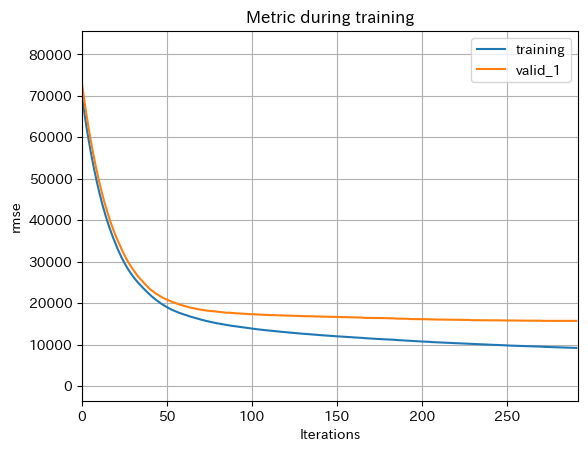

,importance
面積,4.628405e+14
L,3.996844e+14
平均地価,2.035323e+14
最寄り駅,9.248815e+13
築年数,7.267013e+13
所在地,4.263325e+13
全体の階数,3.323557e+13
契約期間,1.591052e+13
所在階,9.973092e+12
所要時間,6.414685e+12


In [174]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'S']], over100m2, bt75and100m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]], test_over100m2, test_bt75and100m2], axis=1)

category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S', '100m^2以上', '75m^2以上100m^2未満']

n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

In [175]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/GBDT_cv_result.csv',index=False)

ダメおしで「面積」が60m^2以上75m^2未満の物件にもフラグを立ててみる

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], over100m2, bt75and100m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]], test_over100m2, test_bt75and100m2], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S', '100m^2以上', '75m^2以上100m^2未満']

In [28]:
X_train['50m^2以上75m^2未満'] = 0
X_test['50m^2以上75m^2未満'] = 0
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10

for i in range(len(X_train)):
    if X_train.loc[i]['面積'] >= 50.0 and X_train.loc[i]['面積'] < 75.0:
        #X_train.loc[i]['広い物件'] = 1#この代入方法だとエラーも出ずに代入に失敗する
        X_train.loc[i,'50m^2以上75m^2未満'] = 1

for i in range(len(X_test)):
    if X_test.loc[i]['面積'] >= 50.0 and X_test.loc[i]['面積'] < 75.0:
        X_test.loc[i, '50m^2以上75m^2未満'] = 1

bt50and75m2 = X_train['50m^2以上75m^2未満']
bt50and75m2.to_csv('../data/handmade_data/bt50and75m2.csv', index=False)
test_bt50and75m2 = X_test['50m^2以上75m^2未満']
test_bt50and75m2.to_csv('../data/test_data/test_bt50and75m2.csv', index=False)

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2341
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 17
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48847.8	valid_1's rmse: 50197.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argumen

[20]	training's rmse: 34668.1	valid_1's rmse: 37861.2
[30]	training's rmse: 26289.3	valid_1's rmse: 31064
[40]	training's rmse: 21358.8	valid_1's rmse: 27236.2
[50]	training's rmse: 18136.8	valid_1's rmse: 24873.2
[60]	training's rmse: 16166.8	valid_1's rmse: 23437
[70]	training's rmse: 14802.2	valid_1's rmse: 22430.6
[80]	training's rmse: 13826.9	valid_1's rmse: 21711.2
[90]	training's rmse: 13132.1	valid_1's rmse: 21232.3
[100]	training's rmse: 12575.4	valid_1's rmse: 20842.6
[110]	training's rmse: 12071.9	valid_1's rmse: 20503.6
[120]	training's rmse: 11657.1	valid_1's rmse: 20211.7
[130]	training's rmse: 11306.1	valid_1's rmse: 19993.3
[140]	training's rmse: 10959.4	valid_1's rmse: 19756.9
[150]	training's rmse: 10660.5	valid_1's rmse: 19562.8
[160]	training's rmse: 10380.2	valid_1's rmse: 19371.2
[170]	training's rmse: 10122.9	valid_1's rmse: 19194.7
[180]	training's rmse: 9900.51	valid_1's rmse: 19050.8
[190]	training's rmse: 9695.51	valid_1's rmse: 18916.3
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argumen

[10]	training's rmse: 48970.9	valid_1's rmse: 49330.6
[20]	training's rmse: 35005.1	valid_1's rmse: 35825.9
[30]	training's rmse: 26854.2	valid_1's rmse: 28191.4
[40]	training's rmse: 22113.2	valid_1's rmse: 23925.6
[50]	training's rmse: 19226.2	valid_1's rmse: 21283.7
[60]	training's rmse: 17451.5	valid_1's rmse: 20038.5
[70]	training's rmse: 16201.8	valid_1's rmse: 19251.9
[80]	training's rmse: 15241.2	valid_1's rmse: 18744.3
[90]	training's rmse: 14470.6	valid_1's rmse: 18485.8
[100]	training's rmse: 13876.3	valid_1's rmse: 18314.7
[110]	training's rmse: 13363.4	valid_1's rmse: 18178.2
[120]	training's rmse: 12892.5	valid_1's rmse: 18081.9
[130]	training's rmse: 12481.4	valid_1's rmse: 18006.5
[140]	training's rmse: 12102.4	valid_1's rmse: 17981.2
[150]	training's rmse: 11763.4	valid_1's rmse: 17932.9
[160]	training's rmse: 11446.3	valid_1's rmse: 17911.2
[170]	training's rmse: 11151.9	valid_1's rmse: 17903.4
Early stopping, best iteration is:
[168]	training's rmse: 11208.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argumen

[10]	training's rmse: 48915.5	valid_1's rmse: 48856.3
[20]	training's rmse: 35062.1	valid_1's rmse: 34677
[30]	training's rmse: 26877.2	valid_1's rmse: 26852.5
[40]	training's rmse: 22142.6	valid_1's rmse: 22664.2
[50]	training's rmse: 19137.5	valid_1's rmse: 20326.5
[60]	training's rmse: 17376.2	valid_1's rmse: 19125.1
[70]	training's rmse: 16150.7	valid_1's rmse: 18362.4
[80]	training's rmse: 15230.2	valid_1's rmse: 18029.4
[90]	training's rmse: 14466.1	valid_1's rmse: 17780.7
[100]	training's rmse: 13874.2	valid_1's rmse: 17615.9
[110]	training's rmse: 13383.9	valid_1's rmse: 17446.4
[120]	training's rmse: 12932.1	valid_1's rmse: 17355.2
[130]	training's rmse: 12524.6	valid_1's rmse: 17285.1
[140]	training's rmse: 12164.6	valid_1's rmse: 17224.6
[150]	training's rmse: 11800.6	valid_1's rmse: 17132.3
[160]	training's rmse: 11484.6	valid_1's rmse: 17091.8
[170]	training's rmse: 11197.6	valid_1's rmse: 17035
[180]	training's rmse: 10943.9	valid_1's rmse: 17016.9
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argumen

[20]	training's rmse: 34790.5	valid_1's rmse: 35683.1
[30]	training's rmse: 26273.2	valid_1's rmse: 29038.4
[40]	training's rmse: 21440.6	valid_1's rmse: 25609.9
[50]	training's rmse: 18388.2	valid_1's rmse: 23797.2
[60]	training's rmse: 16469.3	valid_1's rmse: 22904.1
[70]	training's rmse: 15284.7	valid_1's rmse: 22445.5
[80]	training's rmse: 14403.6	valid_1's rmse: 22079.7
[90]	training's rmse: 13729.3	valid_1's rmse: 21758.7
[100]	training's rmse: 13179.3	valid_1's rmse: 21552.8
[110]	training's rmse: 12708.9	valid_1's rmse: 21322.1
[120]	training's rmse: 12327.5	valid_1's rmse: 21214.9
[130]	training's rmse: 11944.7	valid_1's rmse: 21061.8
[140]	training's rmse: 11608	valid_1's rmse: 20975.3
[150]	training's rmse: 11281.7	valid_1's rmse: 20871.1
[160]	training's rmse: 10962.1	valid_1's rmse: 20798.7
[170]	training's rmse: 10700.7	valid_1's rmse: 20716.6
[180]	training's rmse: 10449.9	valid_1's rmse: 20677.8
[190]	training's rmse: 10227.5	valid_1's rmse: 20638.6
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argumen

[10]	training's rmse: 48743.3	valid_1's rmse: 51315.8
[20]	training's rmse: 35072.5	valid_1's rmse: 37089.2
[30]	training's rmse: 27025.8	valid_1's rmse: 28762.7
[40]	training's rmse: 22418.1	valid_1's rmse: 23872.6
[50]	training's rmse: 19272.2	valid_1's rmse: 21042.3
[60]	training's rmse: 17398.2	valid_1's rmse: 19477.1
[70]	training's rmse: 16121.8	valid_1's rmse: 18570.1
[80]	training's rmse: 15184.8	valid_1's rmse: 17939.6
[90]	training's rmse: 14459.2	valid_1's rmse: 17649.2
[100]	training's rmse: 13913.1	valid_1's rmse: 17374.6
[110]	training's rmse: 13443.7	valid_1's rmse: 17171.7
[120]	training's rmse: 13031.2	valid_1's rmse: 17021.8
[130]	training's rmse: 12673.9	valid_1's rmse: 16898.8
[140]	training's rmse: 12357.1	valid_1's rmse: 16791.4
[150]	training's rmse: 12065.7	valid_1's rmse: 16691.7
[160]	training's rmse: 11743.6	valid_1's rmse: 16563.5
[170]	training's rmse: 11498.4	valid_1's rmse: 16471.9
[180]	training's rmse: 11222.9	valid_1's rmse: 16375.9
[190]	training's rm

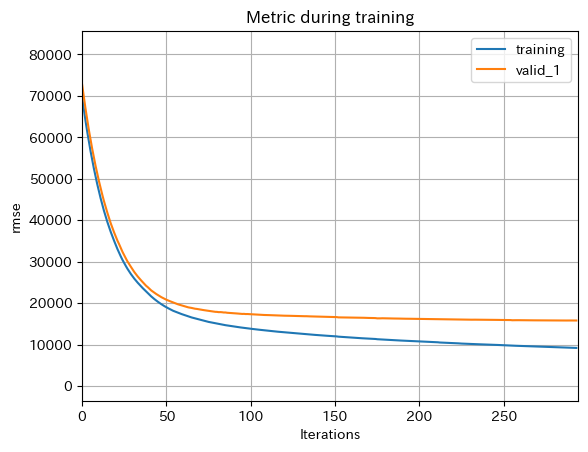

,importance
面積,4.626851e+14
L,3.996505e+14
平均地価,2.033439e+14
最寄り駅,9.305168e+13
築年数,7.334611e+13
所在地,4.219824e+13
全体の階数,3.292572e+13
契約期間,1.533196e+13
所在階,9.856342e+12
所要時間,6.464418e+12


In [29]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'S']], over100m2, bt75and100m2, bt50and75m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D","S"]], test_over100m2, test_bt75and100m2, test_bt50and75m2], axis=1)

category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S', '100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

### 面積が「90m^2以上」の特徴量を作ってみる！

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
building = pd.read_csv('../data/handmade_data/building.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
kitchen_points.drop('コンロ3口', axis=1, inplace=True)
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
latitude_longitude = pd.read_csv('../data/handmade_data/latitude_longitude.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_building = pd.read_csv('../data/test_data/test_building.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_kitchen_points.drop('コンロ3口', axis=1, inplace=True)
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_latitude_longitude = pd.read_csv('../data/test_data/test_latitude_longitude.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, area_per_rooms, 
kitchen_points[['コンロ2口']], latitude_longitude[['平均緯度', '平均経度']]], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size,test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets,test_buildings, test_over100m2, test_bt75and100m2, test_area_per_rooms, 
test_kitchen_points[['コンロ2口']], test_latitude_longitude[['平均緯度','平均経度']]], axis=1)
category_lists = ['定期借家','最寄り駅', 'L', 'D','S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', 'コンロ2口']

Duplicate key in file PosixPath('/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family : IPAexGothic')


In [2]:
X_train['90m^2以上'] = 0
X_test['90m^2以上'] = 0
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10

for i in range(len(X_train)):
    if X_train.loc[i]['面積'] >= 90.0:
        #X_train.loc[i]['広い物件'] = 1#この代入方法だとエラーも出ずに代入に失敗する
        X_train.loc[i,'90m^2以上'] = 1

for i in range(len(X_test)):
    if X_test.loc[i]['面積'] >= 90.0:
        X_test.loc[i, '90m^2以上'] = 1

over90m2 = X_train['90m^2以上']
over90m2.to_csv('../data/handmade_data/over90m2.csv', index=False)
test_over90m2 = X_test['90m^2以上']
test_over90m2.to_csv('../data/test_data/test_over90m2.csv', index=False)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
building = pd.read_csv('../data/handmade_data/building.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
over90m2 = pd.read_csv('../data/handmade_data/over90m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
kitchen_points.drop('コンロ3口', axis=1, inplace=True)
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
latitude_longitude = pd.read_csv('../data/handmade_data/latitude_longitude.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_building = pd.read_csv('../data/test_data/test_building.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_over90m2 = pd.read_csv('../data/test_data/test_over90m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_kitchen_points.drop('コンロ3口', axis=1, inplace=True)
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_latitude_longitude = pd.read_csv('../data/test_data/test_latitude_longitude.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over90m2, area_per_rooms, 
kitchen_points[['コンロ2口']], latitude_longitude[['平均緯度', '平均経度']]], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size,test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets,test_buildings, test_over90m2, test_area_per_rooms, 
test_kitchen_points[['コンロ2口']], test_latitude_longitude[['平均緯度','平均経度']]], axis=1)
category_lists = ['定期借家','最寄り駅', 'L', 'D','S', 'バス・トイレ別','建物構造','90m^2以上', 'コンロ2口']

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2558
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48919.6	valid_1's rmse: 50227.9
[20]	training's rmse: 34615.9	valid_1's rmse: 37921.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['90m^2以上', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log

[30]	training's rmse: 26164.6	valid_1's rmse: 31069.6
[40]	training's rmse: 21285.5	valid_1's rmse: 27213.8
[50]	training's rmse: 18165	valid_1's rmse: 24888.6
[60]	training's rmse: 16375	valid_1's rmse: 23547.5
[70]	training's rmse: 15102.8	valid_1's rmse: 22559
[80]	training's rmse: 14220.2	valid_1's rmse: 21917.7
[90]	training's rmse: 13492.6	valid_1's rmse: 21396.4
[100]	training's rmse: 12912.7	valid_1's rmse: 20985.6
[110]	training's rmse: 12452.4	valid_1's rmse: 20653.3
[120]	training's rmse: 12050.1	valid_1's rmse: 20353.6
[130]	training's rmse: 11681.7	valid_1's rmse: 20080.1
[140]	training's rmse: 11360.2	valid_1's rmse: 19831.3
[150]	training's rmse: 11041.7	valid_1's rmse: 19579.7
[160]	training's rmse: 10762.8	valid_1's rmse: 19365.4
[170]	training's rmse: 10494.6	valid_1's rmse: 19147.5
[180]	training's rmse: 10224.8	valid_1's rmse: 18923.6
[190]	training's rmse: 9988.33	valid_1's rmse: 18726
[200]	training's rmse: 9764.22	valid_1's rmse: 18539.1
[210]	training's rmse: 95

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['90m^2以上', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log

[40]	training's rmse: 22425.5	valid_1's rmse: 24742.4
[50]	training's rmse: 19645.5	valid_1's rmse: 22315.9
[60]	training's rmse: 17806.5	valid_1's rmse: 20881.6
[70]	training's rmse: 16574.1	valid_1's rmse: 20203.1
[80]	training's rmse: 15688	valid_1's rmse: 19744.7
[90]	training's rmse: 14956.4	valid_1's rmse: 19364.8
[100]	training's rmse: 14323.5	valid_1's rmse: 19158.9
[110]	training's rmse: 13761.7	valid_1's rmse: 18947.1
[120]	training's rmse: 13281.8	valid_1's rmse: 18853.5
[130]	training's rmse: 12841	valid_1's rmse: 18778.2
[140]	training's rmse: 12442.6	valid_1's rmse: 18659.6
[150]	training's rmse: 12073.4	valid_1's rmse: 18608.1
[160]	training's rmse: 11746.7	valid_1's rmse: 18522
[170]	training's rmse: 11451.9	valid_1's rmse: 18428.5
[180]	training's rmse: 11165.3	valid_1's rmse: 18291.2
[190]	training's rmse: 10902.5	valid_1's rmse: 18249.4
[200]	training's rmse: 10651.1	valid_1's rmse: 18161.6
Early stopping, best iteration is:
[197]	training's rmse: 10724.2	valid_1's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['90m^2以上', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log

[20]	training's rmse: 35311.5	valid_1's rmse: 34394.1
[30]	training's rmse: 27212.2	valid_1's rmse: 26601.3
[40]	training's rmse: 22568.3	valid_1's rmse: 22457.6
[50]	training's rmse: 19662.5	valid_1's rmse: 20020.9
[60]	training's rmse: 17906.4	valid_1's rmse: 18852.3
[70]	training's rmse: 16694	valid_1's rmse: 18359.4
[80]	training's rmse: 15786.6	valid_1's rmse: 18053
[90]	training's rmse: 15038.7	valid_1's rmse: 17789.2
[100]	training's rmse: 14425.3	valid_1's rmse: 17595
[110]	training's rmse: 13895.8	valid_1's rmse: 17450.9
[120]	training's rmse: 13426.5	valid_1's rmse: 17331.6
[130]	training's rmse: 12991.7	valid_1's rmse: 17237
[140]	training's rmse: 12619.2	valid_1's rmse: 17191.2
[150]	training's rmse: 12262.2	valid_1's rmse: 17112.8
[160]	training's rmse: 11918.5	valid_1's rmse: 17061.8
[170]	training's rmse: 11626.1	valid_1's rmse: 17049
[180]	training's rmse: 11342.4	valid_1's rmse: 17018.9
[190]	training's rmse: 11076.2	valid_1's rmse: 17014.9
[200]	training's rmse: 10825

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['90m^2以上', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log

[30]	training's rmse: 26416	valid_1's rmse: 29135.2
[40]	training's rmse: 21688.9	valid_1's rmse: 25603.9
[50]	training's rmse: 18868.6	valid_1's rmse: 24025.8
[60]	training's rmse: 17088.5	valid_1's rmse: 23065.7
[70]	training's rmse: 15869	valid_1's rmse: 22535.4
[80]	training's rmse: 15045.4	valid_1's rmse: 22209.4
[90]	training's rmse: 14384	valid_1's rmse: 21875
[100]	training's rmse: 13827.4	valid_1's rmse: 21601.1
[110]	training's rmse: 13342.6	valid_1's rmse: 21450.2
[120]	training's rmse: 12913.4	valid_1's rmse: 21227.2
[130]	training's rmse: 12510.4	valid_1's rmse: 21006.8
[140]	training's rmse: 12140.1	valid_1's rmse: 20833.6
[150]	training's rmse: 11825.4	valid_1's rmse: 20678.6
[160]	training's rmse: 11506.7	valid_1's rmse: 20571.8
[170]	training's rmse: 11205.4	valid_1's rmse: 20442.4
[180]	training's rmse: 10942.3	valid_1's rmse: 20326
[190]	training's rmse: 10702.7	valid_1's rmse: 20172.4
[200]	training's rmse: 10450.4	valid_1's rmse: 20073.5
[210]	training's rmse: 1024

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['90m^2以上', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49031.1	valid_1's rmse: 51562.7
[20]	training's rmse: 35314.2	valid_1's rmse: 37352.6
[30]	training's rmse: 27364.2	valid_1's rmse: 28875.2
[40]	training's rmse: 22829.2	valid_1's rmse: 24077
[50]	training's rmse: 19884.5	valid_1's rmse: 21369.8
[60]	training's rmse: 18014.1	valid_1's rmse: 19778.8
[70]	training's rmse: 16804.3	valid_1's rmse: 18786.8
[80]	training's rmse: 15934.1	valid_1's rmse: 18030.2
[90]	training's rmse: 15240.3	valid_1's rmse: 17491.5
[100]	training's rmse: 14664.8	valid_1's rmse: 17142.5
[110]	training's rmse: 14166.3	valid_1's rmse: 16829.8
[120]	training's rmse: 13713.7	valid_1's rmse: 16586.2
[130]	training's rmse: 13318.6	valid_1's rmse: 16371
[140]	training's rmse: 12982.9	valid_1's rmse: 16158.8
[150]	training's rmse: 12620.8	valid_1's rmse: 15994.8
[160]	training's rmse: 12305.5	valid_1's rmse: 15812.4
[170]	training's rmse: 12005.5	valid_1's rmse: 15668.1
[180]	training's 

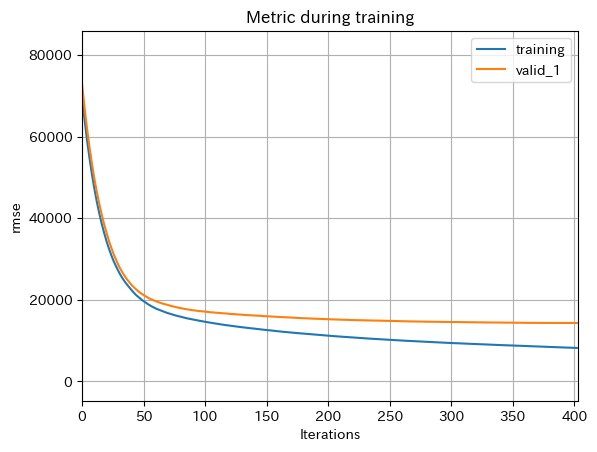

,importance
面積,4.668806e+14
L,3.759636e+14
平均地価,2.060046e+14
最寄り駅,1.074047e+14
築年数,7.259158e+13
全体の階数,3.431497e+13
一部屋あたりの面積,2.175823e+13
平均緯度,1.805804e+13
契約期間,1.450451e+13
所在階,1.053338e+13


In [11]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  2.960577442860017e-06,
        'max_bin': 333,
        'num_leaves': 70,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

### 「90m^2以上」はあまり効果なし

### 「110m^2以上」はどうか？

In [14]:
X_train['110m^2以上'] = 0
X_test['110m^2以上'] = 0
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10

for i in range(len(X_train)):
    if X_train.loc[i]['面積'] >= 110.0:
        #X_train.loc[i]['広い物件'] = 1#この代入方法だとエラーも出ずに代入に失敗する
        X_train.loc[i,'110m^2以上'] = 1

for i in range(len(X_test)):
    if X_test.loc[i]['面積'] >= 110.0:
        X_test.loc[i, '110m^2以上'] = 1

over110m2 = X_train['110m^2以上']
over110m2.to_csv('../data/handmade_data/over110m2.csv', index=False)
test_over110m2 = X_test['110m^2以上']
test_over110m2.to_csv('../data/test_data/test_over110m2.csv', index=False)

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
building = pd.read_csv('../data/handmade_data/building.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over110m2 = pd.read_csv('../data/handmade_data/over110m2.csv')
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
over90m2 = pd.read_csv('../data/handmade_data/over90m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
kitchen_points.drop('コンロ3口', axis=1, inplace=True)
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
latitude_longitude = pd.read_csv('../data/handmade_data/latitude_longitude.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_building = pd.read_csv('../data/test_data/test_building.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over110m2 = pd.read_csv('../data/test_data/test_over110m2.csv')
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_over90m2 = pd.read_csv('../data/test_data/test_over90m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_kitchen_points.drop('コンロ3口', axis=1, inplace=True)
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_latitude_longitude = pd.read_csv('../data/test_data/test_latitude_longitude.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over110m2, over100m2, area_per_rooms, 
kitchen_points[['コンロ2口']], latitude_longitude[['平均緯度', '平均経度']]], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size,test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets,test_buildings, test_over110m2,test_over100m2, test_area_per_rooms, 
test_kitchen_points[['コンロ2口']], test_latitude_longitude[['平均緯度','平均経度']]], axis=1)
category_lists = ['定期借家','最寄り駅', 'L', 'D','S', 'バス・トイレ別','建物構造','110m^2以上','100m^2以上', 'コンロ2口']

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2559
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48917.2	valid_1's rmse: 50209.3


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '110m^2以上', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument in

[20]	training's rmse: 34616.6	valid_1's rmse: 37990.9
[30]	training's rmse: 26116.6	valid_1's rmse: 31088.3
[40]	training's rmse: 21284.4	valid_1's rmse: 27226.6
[50]	training's rmse: 18204.1	valid_1's rmse: 24901.3
[60]	training's rmse: 16361.7	valid_1's rmse: 23575.7
[70]	training's rmse: 15125.5	valid_1's rmse: 22632.8
[80]	training's rmse: 14212.2	valid_1's rmse: 21997.6
[90]	training's rmse: 13531.5	valid_1's rmse: 21527
[100]	training's rmse: 12970.9	valid_1's rmse: 21136
[110]	training's rmse: 12480.8	valid_1's rmse: 20820.9
[120]	training's rmse: 12077.9	valid_1's rmse: 20499.2
[130]	training's rmse: 11689.2	valid_1's rmse: 20191.8
[140]	training's rmse: 11371.6	valid_1's rmse: 19940.6
[150]	training's rmse: 11056	valid_1's rmse: 19703.2
[160]	training's rmse: 10793.3	valid_1's rmse: 19503.9
[170]	training's rmse: 10500.3	valid_1's rmse: 19258.4
[180]	training's rmse: 10257.5	valid_1's rmse: 19048.1
[190]	training's rmse: 10023.9	valid_1's rmse: 18855.1
[200]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '110m^2以上', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument in

[30]	training's rmse: 26985.4	valid_1's rmse: 28691.3
[40]	training's rmse: 22376.7	valid_1's rmse: 24790.1
[50]	training's rmse: 19542.7	valid_1's rmse: 22347.5
[60]	training's rmse: 17736.9	valid_1's rmse: 20828.5
[70]	training's rmse: 16576.9	valid_1's rmse: 20183.2
[80]	training's rmse: 15678.5	valid_1's rmse: 19641.2
[90]	training's rmse: 14965.1	valid_1's rmse: 19218.6
[100]	training's rmse: 14323.5	valid_1's rmse: 18949.6
[110]	training's rmse: 13780.8	valid_1's rmse: 18825
[120]	training's rmse: 13303.3	valid_1's rmse: 18716.8
[130]	training's rmse: 12856.8	valid_1's rmse: 18628
[140]	training's rmse: 12457.1	valid_1's rmse: 18573
[150]	training's rmse: 12094.7	valid_1's rmse: 18531.3
[160]	training's rmse: 11772.5	valid_1's rmse: 18440.1
[170]	training's rmse: 11448.4	valid_1's rmse: 18395.1
[180]	training's rmse: 11175.4	valid_1's rmse: 18297.7
[190]	training's rmse: 10898.8	valid_1's rmse: 18259.9
[200]	training's rmse: 10649.2	valid_1's rmse: 18198.4
[210]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '110m^2以上', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument in

[30]	training's rmse: 27200.1	valid_1's rmse: 26658.7
[40]	training's rmse: 22516.4	valid_1's rmse: 22564.8
[50]	training's rmse: 19561.8	valid_1's rmse: 20056.2
[60]	training's rmse: 17812.8	valid_1's rmse: 18941.6
[70]	training's rmse: 16603.9	valid_1's rmse: 18440.6
[80]	training's rmse: 15694.3	valid_1's rmse: 18124.9
[90]	training's rmse: 14984.7	valid_1's rmse: 17849.6
[100]	training's rmse: 14359.9	valid_1's rmse: 17594.1
[110]	training's rmse: 13835.6	valid_1's rmse: 17436.5
[120]	training's rmse: 13353.1	valid_1's rmse: 17353.5
[130]	training's rmse: 12931.1	valid_1's rmse: 17248.4
[140]	training's rmse: 12522.1	valid_1's rmse: 17146.1
[150]	training's rmse: 12171.9	valid_1's rmse: 17084.1
[160]	training's rmse: 11852.8	valid_1's rmse: 17033.5
[170]	training's rmse: 11555.6	valid_1's rmse: 17013.1
[180]	training's rmse: 11254.7	valid_1's rmse: 16981.6
[190]	training's rmse: 10997.8	valid_1's rmse: 16962.5
[200]	training's rmse: 10756.4	valid_1's rmse: 16953.7
[210]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '110m^2以上', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument in

[20]	training's rmse: 34777.5	valid_1's rmse: 35763.5
[30]	training's rmse: 26476.8	valid_1's rmse: 29212.7
[40]	training's rmse: 21714.4	valid_1's rmse: 25738.9
[50]	training's rmse: 18919.1	valid_1's rmse: 24063.8
[60]	training's rmse: 17143.8	valid_1's rmse: 23176.6
[70]	training's rmse: 15994.4	valid_1's rmse: 22642
[80]	training's rmse: 15140.4	valid_1's rmse: 22337.8
[90]	training's rmse: 14486	valid_1's rmse: 22045.8
[100]	training's rmse: 13916.1	valid_1's rmse: 21723
[110]	training's rmse: 13423.3	valid_1's rmse: 21531.7
[120]	training's rmse: 12973.8	valid_1's rmse: 21271
[130]	training's rmse: 12594.9	valid_1's rmse: 21022.8
[140]	training's rmse: 12233.4	valid_1's rmse: 20836
[150]	training's rmse: 11894.3	valid_1's rmse: 20690.8
[160]	training's rmse: 11584.1	valid_1's rmse: 20522.8
[170]	training's rmse: 11284.6	valid_1's rmse: 20398
[180]	training's rmse: 11025.4	valid_1's rmse: 20264.9
[190]	training's rmse: 10775.7	valid_1's rmse: 20180.8
[200]	training's rmse: 10540.1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '110m^2以上', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument in

[30]	training's rmse: 27379.3	valid_1's rmse: 28856.3
[40]	training's rmse: 22846.4	valid_1's rmse: 24007.6
[50]	training's rmse: 19931.3	valid_1's rmse: 21294.9
[60]	training's rmse: 18038.1	valid_1's rmse: 19662.5
[70]	training's rmse: 16823.1	valid_1's rmse: 18652.1
[80]	training's rmse: 15946.7	valid_1's rmse: 17933.9
[90]	training's rmse: 15239.4	valid_1's rmse: 17478.7
[100]	training's rmse: 14651.2	valid_1's rmse: 17115.1
[110]	training's rmse: 14153	valid_1's rmse: 16820.2
[120]	training's rmse: 13701.8	valid_1's rmse: 16601.2
[130]	training's rmse: 13310.4	valid_1's rmse: 16405.2
[140]	training's rmse: 12963.7	valid_1's rmse: 16209.2
[150]	training's rmse: 12616.5	valid_1's rmse: 16026.7
[160]	training's rmse: 12276.5	valid_1's rmse: 15889.1
[170]	training's rmse: 11975.2	valid_1's rmse: 15709.8
[180]	training's rmse: 11693.9	valid_1's rmse: 15566.8
[190]	training's rmse: 11440.4	valid_1's rmse: 15408.6
[200]	training's rmse: 11204.1	valid_1's rmse: 15279.5
[210]	training's rm

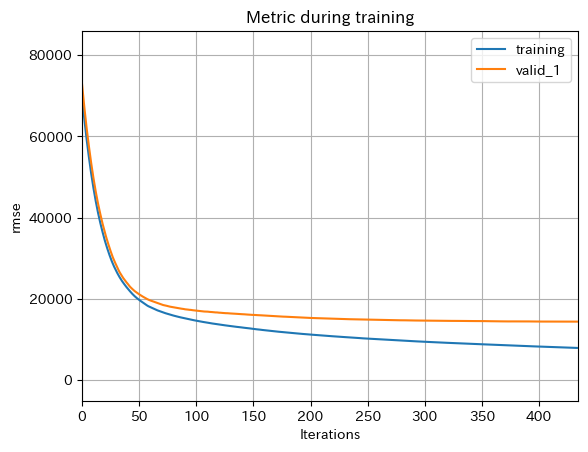

,importance
面積,4.581016e+14
L,3.828189e+14
平均地価,2.045941e+14
最寄り駅,1.078241e+14
築年数,7.228977e+13
全体の階数,3.457822e+13
一部屋あたりの面積,2.305378e+13
平均緯度,1.790064e+13
契約期間,1.323143e+13
所在階,1.076014e+13


In [23]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  2.960577442860017e-06,
        'max_bin': 333,
        'num_leaves': 70,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)